<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w2d1_d2_fixes/tutorials/W2D1_ConvnetsAndRecurrentNeuralNetworks/W2D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Introduction to CNNs

**Week 2, Day 1: Convnets And Recurrent Neural Networks**

**By Neuromatch Academy**

__Content creators:__ Dawn Estes McKnight, Richard Gerum, Cassidy Pirlot, Rohan Saha, Liam Peet-Pare, Saeed Najafi, Alona Fyshe

__Content reviewers:__ Saeed Salehi, Lily Cheng, Yu-Fang Yang, Polina Turishcheva, Bettina Hein, Kelson Shilling-Scrivo

__Content editors:__ Nina Kudryashova, Anmol Gupta, Xiaoxiong Lin, Spiros Chavlis 

__Production editors:__ Alex Tran-Van-Minh, Spiros Chavlis


*Based on material from:* Konrad Kording, Hmrishav Bandyopadhyay, Rahul Shekhar, Tejas Srivastava

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives
At the end of this tutorial, we will be able to:
- Define what convolution is
- Implement convolution as an operation

In the Bonus materials of this tutorial, you will be able to:

- train a CNN by writing your own train loop
- recognize the symptoms of overfitting and how to cure them

 

In [1]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/s8xz5/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for all videos in this tutorial. If you want to download locally the slides, click [here](https://osf.io/s8xz5/download).

---
# Setup

In [2]:
# @title Install dependencies
!pip install livelossplot --quiet
!pip install Pillow --quiet
!pip install imageio-ffmpeg --quiet

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG','W2D1_T1','https://portal.neuromatchacademy.org/api/redirect/to/9c55f6cb-cdf9-4429-ac1c-ec44fe64c303')

In [3]:
# Imports
import time
import torch
import pathlib
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm, trange
from PIL import Image

In [4]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

plt.rcParams["mpl_toolkits.legacy_colorbar"] = False
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [5]:
# @title Helper functions
from scipy.signal import convolve2d
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading for OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip
  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # remove the archive
    os.remove(fname)

    # extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # remove the extension
      fname = filename.replace('.gz', '')
      # gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been dowloaded.\n')


def check_shape_function(func, image_shape, kernel_shape):
  correct_shape = correlate2d(np.random.rand(*image_shape), np.random.rand(*kernel_shape), "valid").shape
  user_shape = func(image_shape, kernel_shape)
  if correct_shape != user_shape:
    print(f"❌ Your calculated output shape is not correct.")
  else:
    print(f"✅ Output for image_shape: {image_shape} and kernel_shape: {kernel_shape}, output_shape: {user_shape}, is correct.")


def check_conv_function(func, image, kernel):
  solution_user = func(image, kernel)
  solution_scipy = correlate2d(image, kernel, "valid")
  result_right = (solution_user == solution_scipy).all()
  if result_right:
    print("✅ The function calculated the convolution correctly.")
  else:
    print("❌ The function did not produce the right output.")
    print("For the input matrix:")
    print(image)
    print("and the kernel:")
    print(kernel)
    print("the function returned:")
    print(solution_user)
    print("the correct output would be:")
    print(solution_scipy)


def check_pooling_net(net, device='cpu'):
  x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
  output_x = net(x_img)
  output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

  right_output = [
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [9.309552, 1.6216984, 0.000000, 0.000000, 0.000000, 0.000000, 2.2708383,
      2.6654134, 1.2271233, 0.000000, 0.000000, 0.000000],
      [12.873457, 13.318945, 9.46229, 4.663746, 0.000000, 0.000000, 1.8889914,
      0.31068993, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 8.354934, 10.378724, 16.882853, 18.499334, 4.8546696, 0.000000,
      0.000000, 0.000000, 6.29296, 5.096506, 0.000000],
      [0.000000, 0.000000, 0.31068993, 5.7074604, 9.984148, 4.12916, 8.10037,
      7.667609, 0.000000, 0.000000, 1.2780352, 0.000000],
      [0.000000, 2.436305, 3.9764223, 0.000000, 0.000000, 0.000000, 12.98801,
      17.1756, 17.531992, 11.664275, 1.5453291, 0.000000],
      [4.2691708, 2.3217516, 0.000000, 0.000000, 1.3798618, 0.05612564, 0.000000,
      0.000000, 11.218788, 16.360992, 13.980816, 8.354935],
      [1.8126211, 0.000000, 0.000000, 2.9199777, 3.9382377, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 6.076582, 10.035061],
      [0.000000, 0.92164516, 4.434638, 0.7816348, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.83254766],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000]
  ]

  right_shape = (3, 12, 12)

  if output_x.shape != right_shape:
    print(f"❌ Your output does not have the right dimensions. Your output is {output_x.shape} the expected output is {right_shape}")
  elif (output_x[0] != right_output).all():
    print("❌ Your output is not right.")
  else:
    print("✅ Your network produced the correct output.")


# just returns accuracy on test data
def test(model, device, data_loader):
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

In [6]:
# @title Plotting Functions

def display_image_from_greyscale_array(matrix, title):
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  #plt.show()

In [7]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [8]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [9]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


---
# Section 0: Recap the Experience from Last Week

*Time estimate: ~15mins*

Last week you learned a lot!  Recall that overparametrized ANNs are efficient universal approximators, but also that ANNs can memorize our data.  However, regularization can help ANNs to better generalize. You were introduced to several regularization techniques such as *L1*, *L2*, *Data Augmentation*, and *Dropout*. 

Today we'll be talking about other ways to simplify ANNs, by making smart changes to their architecture. 

In [10]:
# @title Video 1: Introduction to CNNs and RNNs
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1cL411p7rz", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"5598K-hS89A", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 1: Introduction to CNNs and RNNs')

display(out)

## Think! 0: Regularization & effective number of params
Let's think back to last week, when you learned about regularization.  Recall that regularization comes in several forms. For example, L1 regularization adds a term to the loss function that penalizes based on the sum of the _absolute_ magnitude of the weights. Below are the results from training a simple multilayer perceptron with one hidden layer (b) on a simple toy dataset (a).

Below that are two graphics that show the effect of regularization on both the number of non-zero weights (d), and on the network's accuracy (c).

What do you notice?

**Note**: Dense layers are the same as fully-connected layers.  And pytorch calls them linear layers.  Confusing, but now you know!

<figure>
  <img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D1_ConvnetsAndRecurrentNeuralNetworks/static/think0.png">
  <figcaption><b>a.</b> The 2-dimensional inputs of class A (red) and B (green). <b>b.</b>The network architecture. Each Dense layer contains the (batch size, dimension), and below, the number of its trainable parameters. <b>c.</b>The train (blue) and validation (orange) accuracy as function of the regularization strength. <b>d.</b>The number of non-zero parameters as a function of the regularization strength.</figcaption>
</figure>

In [11]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [12]:
# to_remove explanation

"""
When you increase the regularization strength you can see that the test accuracy
improves (orange line in (c)),while the effective number of parameters goes down
(d).At a certain point, however, the regularization is too strong, and the
accuracy declines (1e-1).
"""

'\nWhen you increase the regularization strength you can see that the test accuracy\nimproves (orange line in (c)),while the effective number of parameters goes down\n(d).At a certain point, however, the regularization is too strong, and the\naccuracy declines (1e-1).\n'

**Coming Up**

The rest of these lectures focus on another way to reduce parameters: weight-sharing. Weight-sharing is based on the idea that some sets of weights can be used at multiple points in a network. We will focus mostly on CNNs today, where the weight-sharing is across the 2D space of an image. At the end we will touch briefly on Recurrent Neural Networks (RNNs), which share parameters across time. Both of these weight-sharing techniques (across space and time) can reduce the number of parameters and increase a network's ability to generalize.

---
# Section 1: Neuroscience motivation, General CNN structure

*Time estimate: ~25mins*

In [13]:
# @title Video 2: Representations & Visual processing in the brain
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1c64y1x7mJ", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"AXO-iflKa58", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 2: Representations & Visual processing in the brain')

display(out)

## Think! 1: What makes a representation good?
Representations have a long and storied history, having been studied by the likes of Aristotle back in 300 BC! Representations are not a new idea, and they certainly don't exist just in neural networks.

Take a moment with your pod to discuss what would make a good representation, and how that might differ depending on the task you train your CNN to do.

If there's time, you can also consider how the brain's representations might differ from a *learned* representation inside a NN.



In [14]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q2', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [15]:
# to_remove explanation

"""
A good representation captures the important aspects of an entity - Using a good
representation, we can understand the nuances of the data - for example, a good
representation of an image showing a dog would accurately capture the eyes,
ears etc and a representation of, for example, a building, would capture the
edges.
""";

---
# Section 2: Convolutions and Edge Detection

*Time estimate: ~25mins*

Fundamental to CNNs are convolutions. After all, that _is_ what the C in CNN stands for! In this section, we will define what a convolution is, practice performing a convolution, and implement it in code.  

In [16]:
# @title Video 3: Details about Convolution
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Q64y1z77p", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"pmc40WCnF-w", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 3: Details about Convolution')

display(out)

Before jumping into coding exercises, take a moment to look at this animation that steps through the process of convolution.

Recall from the video that convolution involves sliding the kernel across the image, taking the element-wise product, and adding those products together.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D1_ConvnetsAndRecurrentNeuralNetworks/static/correlation.svg">

Adopted from A. Zhang, Z. C. Lipton, M. Li and A. J. Smola, _[Dive into Deep Learning](http://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html)_.

<br>

**Note:** You need to run the cell to activate the sliders, and again to run once changing the sliders.

**Tip:** In this animation, and all the ones that follow, you can hover over the parts of the code underlined in red to change them.

**Tip:** Below, the function is called `Conv2d` because the convolutional filter is a matrix with two dimensions (2D).  There are also 1D and 3D convolutions, but we won't talk about them today.

### Interactive Demo 2: Visualization of Convolution

In [17]:
%%html

# @markdown *Run this cell to enable the widget!*

<style>
    svg {
        #border: 1px solid black;
    }
.matrix {
    font-family: sans-serif;
    transition: all 700ms ease-in-out;
}
.cell rect {
    fill:white;stroke-width:1;stroke:rgb(0,0,0)
}
.padding rect {
    stroke: rgba(0, 0, 0, 0.25);
}
.padding text {
    fill: lightgray;
}
.highlight1 {
    fill:none;stroke-width:4;stroke: rgb(236, 58, 58);stroke-dasharray:10,5;
}
.highlight2 {
    fill:rgba(229, 132, 66, 0.25);stroke-width:5;stroke: rgb(229, 132, 66);
}
.highlight3 {
    fill:rgba(236, 58, 58, 0.25);stroke-width:2;stroke: rgb(236, 58, 58);;
}
.title {
    text-anchor: middle;
}
.button_play {
    display: inline-block;
    background: none;
    border: none;
    position: relative;
    top: -3px;
}
.button_play path {
    fill: darkgray;
}
.button_play:hover path {
    fill: rgb(236, 58, 58);
}
.display_vis_input input:not(:hover)::-webkit-outer-spin-button,
.display_vis_input input:not(:hover)::-webkit-inner-spin-button {
    /* display: none; <- Crashes Chrome on hover */
    -webkit-appearance: none;
    margin: 0; /* <-- Apparently some margin are still there even though it's hidden */
}

.display_vis_input input:not(:hover)[type=number] {
    -moz-appearance:textfield; /* Firefox */
    width: 1ch;
    margin-right: 0px;
    z-index: 0;
}
.display_vis_input input[type=number] {
    width: 4ch;
    border: 0px;
    margin-right: -3ch;
    z-index: 6;
    display: inline-block;
    position: relative;
    padding: 0;
    border-bottom: 2px solid red;
    background: white;
    color: black
}
.display_vis_input .pair {
    display: inline-block;
    white-space:nowrap;
        position: relative;
}
.display_vis_input .pair .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
    display: inline-block;
    overflow: hidden;
    position: relative;
    top: 5px;
}
.pair:not(:hover) .pair_hide {
    max-width: 0;
}
.pairX .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
}

/* Dropdown Button */
.dropbtn {
  border-bottom: 2px solid red;
}

/* The container <div> - needed to position the dropdown content */
.dropdown {
  position: relative;
  display: inline-block;
}

/* Dropdown Content (Hidden by Default) */
.dropdown-content {
  display: none;
  position: absolute;
  background-color: #f1f1f1;
  min-width: 160px;
  box-shadow: 0px 8px 16px 0px rgba(0,0,0,0.2);
  z-index: 1;
}

/* Links inside the dropdown */
.dropdown-content a {
  color: black;
  padding: 5px 2px;
  text-decoration: none;
  display: block;
}

/* Change color of dropdown links on hover */
.dropdown-content a:hover {background-color: #ddd;}

/* Show the dropdown menu on hover */
.dropdown:hover .dropdown-content {display: block;}

</style>
<script src="https://d3js.org/d3.v3.min.js" charset="utf-8" > </script>


<div id="animation_conv_filters" style="background: white">
    <div class="display_vis_input language-python" style="font-family: monospace; color: black; padding: 10px;">
        <!-- default -->
        import torch<br><br>
        input = torch.rand(1, 1<input class="input_matrixz" type="hidden" min="1" max="3" value="1">, <input class="input_matrixy" type="number" min="3" max="5" value="3">, <input class="input_matrixx" type="number" min="3" max="5" value="4">)<br>
        conv = torch.nn.Conv2d(in_channels=1<input class="input_matrixzB" type="hidden" min="1" max="3" value="1">, out_channels=1<input class="input_filterz" type="hidden" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filtery" type="number" min="2" max="4" value="2"><span class="pair_hide">,
                                                                       <input class="input_filterx" type="number" min="2" max="4" value="3">)</span></span>
        <span class="pair" style="display: none"><span class="pair_hide">(</span><input class="input_stridex" type="hidden" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="hidden" min="1" max="2" value="1">)</span></span>
        <span class="pair" style="display: none"><span class="pair_hide">(</span><input class="input_paddingx" type="hidden" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="hidden" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)

        <!-- padding
        import torch<br><br>
        input = torch.rand(1, 1<input class="input_matrixz" type="hidden" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">))<br>
        conv = torch.nn.Conv2d(in_channels=1<input class="input_matrixzB" type="hidden" min="1" max="3" value="1">, out_channels=1<input class="input_filterz" type="hidden" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="3">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="1">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="1"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="1">)</span></span>)<br>
        result = conv(input)
-->
    <!-- filters -- >
        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="number" min="1" max="3" value="3">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">)<br>
        conv = torch.nn.Conv2d(in_channels=<input class="input_matrixzB" type="number" min="1" max="3" value="3">, out_channels=<input class="input_filterz" type="number" min="1" max="3" value="2">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="2"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="1">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
-->
 <!--
        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="hidden" min="1" max="3" value="1">1, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">))<br>
        conv = torch.nn.<div class="dropdown">
  <div class="dropbtn">MaxPool2d</div>
  <div class="dropdown-content">
    <a class="select_maxpool" href="#">MaxPool2d</a>
    <a class="select_avgpool" href="#">AvgPool2d</a>
  </div>
</div>(<input class="input_matrixzB" type="hidden" min="1" max="3" value="1"><input class="input_filterz" type="hidden" min="1" max="3" value="1">kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="2"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="2"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="2">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
-->
    </div>
        <button class="button_play play"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 1.5,0 9.5,5 1.5,10 z"/></svg></button>
    <button class="button_play pause" style="display: none"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 0,0 4,0 4,10, 0,10 z"/><path d="M 6,0 10,0 10,10, 6,10 z"/></svg></button>
    <input type="range" min="1" max="100" value="50" class="slider" style="width: 300px; display: inline-block">
    <button class="button_play left"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,5 4,0 4,10 z"/></svg></button>
    <button class="button_play right"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,0 4,5 0,10 z"/></svg></button>
    <input type="checkbox" class="play_fast">fast play mode
    <br/>
    <svg height="0" width="0">
        <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7"
    refX="0" refY="1.5" orient="auto" fill="rgb(236, 58, 58)">
      <polygon points="0 0, 4 1.5, 0 3" />
    </marker>
  </defs>
    </svg>
    <svg class="image" height="460" width="600">

    </svg>
</div>
<script>
(function() {
var dom_target = document.getElementById("animation_conv_filters")
const divmod = (x, y) => [Math.floor(x / y), x % y];
var svg = d3.select(dom_target).select(".image")

var box_s = 50;
var box_z = 10;
var show_single_elements = true;
var group_func = undefined;
function mulberry32(a) {
    return function() {
      var t = a += 0x6D2B79F5;
      t = Math.imul(t ^ t >>> 15, t | 1);
      t ^= t + Math.imul(t ^ t >>> 7, t | 61);
      return ((t ^ t >>> 14) >>> 0) / 4294967296;
    }
}

function numberGenerator(seed, max, digits) {
    var random = mulberry32(seed)
    return () => parseFloat((random() * max).toFixed(digits));
}
window.numberGenerator = numberGenerator
window.mulberry32 = mulberry32
function generateMatrix2(number, dims) {
    var res = [];
    for (var i = 0; i < dims[0]; i++) {
        if(dims.length == 1)
            res.push(number())
        else
            res.push(generateMatrix2(number, dims.slice(1)));
    }
    return res
}
window.generateMatrix2 = generateMatrix2

function addPadding(matrix, paddingx, paddingy) {
    matrix = JSON.parse(JSON.stringify(matrix));
    var ly = matrix.length; var lx = matrix[0].length;
    for (var i = 0; i < ly; i++) {
        for(var p = 0; p < paddingx; p++) {
            matrix[i].splice(0, 0, 0);
            matrix[i].splice(matrix[i].length, 0, 0);
        }
    }
    for(var p = 0; p < paddingy; p++) {
        matrix.splice(0, 0, []);
        matrix.splice(matrix.length, 0, []);
        for (var i = 0; i < lx + paddingx * 2; i++) {
            matrix[0].push(0);
            matrix[matrix.length - 1].push(0);
        }
    }
    matrix.paddingx = paddingx;
    matrix.paddingy = paddingy;
    return matrix;
}

var stride_x = 1;
var stride_y = 1;
function convolve(matrix, filter) {
    var ress = [];
    for(var zz = 0; zz < filter.length; zz++) {
        var res = [];
        for (var i = 0; i < parseInt((matrix[0].length - filter[0][0].length + stride_y) / stride_y); i++) {
            res.push([]);
            for (var j = 0; j < parseInt((matrix[0][0].length - filter[0][0][0].length + stride_x) / stride_x); j++) {
                var answer = 0;
                var text = "";
                for (var ii = 0; ii < filter[0][0].length; ii++) {
                    for (var jj = 0; jj < filter[0][0][0].length; jj++) {
                        for (var z = 0; z < matrix.length; z++) {
                            answer += matrix[z][i * stride_y + ii][j * stride_x + jj] * filter[zz][z][ii][jj];
                            text +=matrix[z][i * stride_y + ii][j * stride_x + jj] + "*" + filter[zz][z][ii][jj]+"+";
                        }
                    }
                }
                console.log(i, j, text, "=", answer)
                res[res.length - 1].push(answer.toFixed(1))
            }
        }
        ress.push(res)
    }
    return ress;
}
function pool(matrix, filter, func) {
    var res = [];
    for (var i = 0; i < parseInt((matrix.length - filter.length + stride_y) / stride_y); i++) {
        res.push([]);
        for (var j = 0; j < parseInt((matrix[0].length - filter[0].length + stride_x) / stride_x); j++) {
            var answer = [];
            for(var ii = 0; ii < filter.length; ii++) {
                for(var jj = 0; jj < filter[0].length; jj++) {
                    answer.push(matrix[i* stride_y + ii][j* stride_x + jj]);
                }
            }
            if(func == "max")
                res[res.length-1].push(Math.max(...answer))
            else {
                var sum = 0;
                for( var ii = 0; ii < answer.length; ii++)
                    sum += answer[ii]; //don't forget to add the base
                var avg = sum/answer.length;
                res[res.length-1].push(parseFloat(avg.toFixed(1)));
            }

        }
    }
    return res;
}

class Matrix {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`);
        for(var z = 0; z < matrix.length; z++) {
            var gg = this.g.append("g").attr("class", "matrix_layer").attr("transform", `translate(${- z*box_z}, ${+ z*box_z})`);
            for (var j = 0; j < matrix[0].length; j++) {
                for (var i = 0; i < matrix[0][0].length; i++) {
                    var element = gg.append("g").attr("class", "cell").attr("transform", `translate(${i * box_s}, ${j * box_s})`);
                    var rect = element.append("rect")
                        .attr("class", "number")
                        .attr("x", -box_s / 2 + "px")
                        .attr("y", -box_s / 2 + "px")
                        .attr("width", box_s + "px")
                        .attr("height", box_s + "px")
                    if (i < matrix.paddingx || j < matrix.paddingy || i > matrix[0][0].length - matrix.paddingx - 1 || j > matrix[0].length - matrix.paddingy - 1)
                        element.attr("class", "cell padding")
                    element.append("text").text(matrix[z][j][i]).attr("text-anchor", "middle").attr("alignment-baseline", "center").attr("dy", "0.3em")
                }
            }
            gg.append("rect").attr("class", "highlight3")
            gg.append("rect").attr("class", "highlight1")
            gg.append("rect").attr("class", "highlight2")
        }
        //<line x1="0" y1="50" x2="250" y2="50" stroke="#000" stroke-width="8" marker-end="url(#arrowhead)" />
        this.arrow = gg.append("line").attr("transform", `translate(${(-0.5)*box_s}, ${(-0.5+filter.length/2)*box_s})`).attr("marker-end", "url(#arrowhead)").attr("x1", 0).attr("y1", 0).attr("x2", 50).attr("y2", 0)
            .attr("stroke", "#000").attr("stroke-width", 8).attr("stroke", "rgb(236, 58, 58)").style("opacity", 0)


        gg.append("text").attr("class", "title").text(title)
            .attr("x", (matrix[0][0].length/2-0.5)*box_s+"px")
            .attr("y", (matrix[0].length)*box_s+"px")
            .attr("dy", "0em")
        this.highlight2_hidden = true
    }

    setHighlight1(i, j, w, h) {
        if(this.old_i == i && this.old_j == j && this.old_w == w)
            return
        if(i == this.old_i+stride_x || j == this.old_j+stride_y) {
            if (this.old_j == j)
                this.arrow.attr("x1", this.old_i * box_s).attr("y1", j * box_s)
                    .attr("x2", i * box_s - 30).attr("y2", j * box_s).attr("transform", `translate(${(-0.5) * box_s}, ${(-0.5 + h / 2) * box_s})`)
            else
                this.arrow.attr("x1", i * box_s).attr("y1", this.old_j * box_s)
                    .attr("x2", i * box_s).attr("y2", j * box_s - 30).attr("transform", `translate(${(-0.5 + w / 2) * box_s}, ${(-0.5) * box_s})`)
            this.arrow.transition().style("opacity", 1)
                .transition()
                .duration(1000)
                .style("opacity", 0)
        }
        this.old_i = i; this.old_j = j; this.old_w = w;
        this.g.selectAll(".highlight1")
            .style("fill", "rgba(236, 58, 58, 0)")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .style("fill", "rgba(236, 58, 58, 0.25)")
        this.g.selectAll(".highlight3")
            .style("opacity", 1)
            .transition()
            .duration(1000)
            .style("opacity", 0)
        this.g.selectAll(".highlight3")
            .transition()
            .delay(900)
            .duration(0)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
//            .style("opacity", 1)
    }

    setHighlight2(i, j, w, h) {
        if(this.highlight2_hidden == true) {
            this.g.selectAll(".highlight2")
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .transition()
            .duration(1000)
            .style("opacity", 1)
            this.highlight2_hidden = false
            return
        }
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px");
    }
    hideHighlight2() {
        this.highlight2_hidden = true
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .style("opacity", 0)
    }
    //m.g.selectAll(".cell text").style("opacity", (d, i)=>{console.log(i>4); return 1*(i>5)})
}

class Calculation {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-1.5em").attr("dx", "2em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text(i+"·"+j)
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0)
                    .text(" = 12 ")
                }
                else {
                    a = element.append("tspan")
                        .text(" + ")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

class CalculationPool {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-3em").attr("dx", "-2em")
        this.g.append("text").text(group_func+"([").attr("dy", "-1.5em").attr("dx", "-0.5em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text("")
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0).attr("dx", "-0.5em")
                    .text("")
                }
                else {
                    a = element.append("tspan")
                        .text("")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

var matrix, res, m, f, r, c, last_pos, index_max;
function init() {
    show_single_elements = dom_target.querySelector(".play_fast").checked == false
    /*
    tuple_or_single = (x, y) => x == y ? x : `(${x}, ${y})`
    if(group_func == "max")
        dom_target.querySelector(".torch_name").innerText = `torch.nn.MaxPool2d(kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else if(group_func == "mean")
            dom_target.querySelector(".torch_name").innerHTML = `torch.nn.AvgPool2d(x=<input class="input_filterx" type="number" min="2" max="4" value="3">, kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else
        dom_target.querySelector(".torch_name").innerText = `torch.nn.Conv2d(in_channels=1, out_channels=1,  kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`

    if(window.hljs != undefined)
        hljs.highlightElement(dom_target.querySelector(".torch_name"))
    */
    svg.selectAll("*").remove();

    dom_target.querySelector(".input_matrixzB").value = dom_target.querySelector(".input_matrixz").value

    console.log("dom_target", dom_target)
    console.log("dom_target.querySelector(\".input_filterx\").value)", dom_target.querySelector(".input_filterx").value)
    filter = generateMatrix2(numberGenerator(17, 0.9, 1), [parseInt(dom_target.querySelector(".input_filterz").value), parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_filtery").value), parseInt(dom_target.querySelector(".input_filterx").value)]);
    if(dom_target.querySelector(".input_filterx").value == dom_target.querySelector(".input_filtery").value)
        dom_target.querySelector(".input_filtery").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_filtery").parentElement.className = "pairX"
    matrix_raw = generateMatrix2(numberGenerator(4, 9, 0), [parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_matrixy").value), parseInt(dom_target.querySelector(".input_matrixx").value)]);

    matrix = JSON.parse(JSON.stringify(matrix_raw));
    for(var z = 0; z < matrix.length; z++)
        matrix[z] = addPadding(matrix_raw[z], parseInt(dom_target.querySelector(".input_paddingx").value), parseInt(dom_target.querySelector(".input_paddingy").value));
    matrix.paddingx = matrix[0].paddingx
    matrix.paddingy = matrix[0].paddingy
    stride_x = parseInt(dom_target.querySelector(".input_stridex").value)
    stride_y = parseInt(dom_target.querySelector(".input_stridey").value)

    if(dom_target.querySelector(".input_stridex").value == dom_target.querySelector(".input_stridey").value)
        dom_target.querySelector(".input_stridey").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_stridey").parentElement.className = "pairX"
        if(dom_target.querySelector(".input_paddingx").value == dom_target.querySelector(".input_paddingy").value)
        dom_target.querySelector(".input_paddingy").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_paddingy").parentElement.className = "pairX"

    res = convolve(matrix, filter);
        window.matrix = matrix
        window.filter = filter
        window.res = res
    if(group_func != undefined)
        res = [pool(matrix[0], filter[0][0], group_func)]

    m = new Matrix(1*box_s, (1+filter[0][0].length+1.5)*box_s, matrix, "Matrix");

    f = []
    for(var zz = 0; zz < filter.length; zz++)
        f.push(new Matrix((1+(matrix[0][0].length-filter[zz][0][0].length)/2 + zz*(1+filter[zz][0][0].length))*box_s, 1*box_s, filter[zz], group_func == undefined ? (filter.length != 1? `Filter ${zz}` : `Filter`) : "Pooling"));
    if(group_func != undefined)
        f[0].g.selectAll(".cell text").attr("fill", "white")

    console.log("res", res)
    r = new Matrix((2+(matrix[0][0].length)+1)*box_s, (1+filter[0][0].length+1.5)*box_s, res, "Result");

    var c_x = Math.max((1+(matrix[0][0].length))*box_s, (3+filter.length*(1+(filter[0][0].length)))*box_s)
    console.log("m,ax", (1+(matrix[0][0].length)), filter.length*(1+(filter[0][0].length)))
    if(group_func != undefined)
        c = new CalculationPool(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");
    else
        c = new Calculation(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");

    last_pos = undefined;
    if(show_single_elements)
        index_max = filter.length*res[0].length*res[0][0].length*(filter[0][0].length * filter[0][0][0].length * filter[0].length + 2)
    else
        index_max = filter.length*res[0].length*res[0][0].length
    window.index_max = index_max
    window.filter = filter
    setHighlights(0, 0)
    svg.attr("width", box_s*(matrix[0][0].length+res[0][0].length+4)+(c.g.node().getBoundingClientRect().width)+"px");
    svg.attr("height", box_s*(matrix[0].length+filter[0][0].length+3.0)+"px");
}
init()

function setHighlights(pos_zz, subpos) {
    var [zz, pos] = divmod(pos_zz, res[0].length*res[0][0].length)
    var [i, j] = divmod(pos, res[0][0].length)
    i *= stride_y;
    j *= stride_x;
    var [j2, i2] = divmod(subpos, filter[0][0][0].length * filter[0].length)
    var [i2, z2] = divmod(i2, filter[0].length)
    subpos = Math.floor(subpos/filter[0].length)
    console.log(zz, i, j, j2, i2, z2)
    if(last_pos != pos || 1) {
        var answer = 0;
        for(var ii = 0; ii < filter[0][0].length; ii++) {
            for(var jj = 0; jj < filter[0][0][0].length; jj++) {
                var text = []
                if(filter[0].length == 1) {
                    for(var z = 0; z < filter[0].length; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + " · " + filter[zz][z][ii][jj]);
                    }
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, text.join("+"));
                }
                else {
                    let max_z = (ii == j2 && jj == i2) ? z2+1 : filter[0].length
                    for (var z = 0; z < max_z; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + "·" + filter[zz][z][ii][jj]);
                        console.log(z, z2, text)
                    }
                    console.log("----------")
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, "(" + text.join("+") + ((filter[0].length==max_z)?")":""));
                }
            }
        }
        if(group_func != undefined)
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   ]) = "+res[zz][i/stride_y][j/stride_x])
        else
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   = "+res[zz][i/stride_y][j/stride_x])
        if(last_pos != pos)
            c.hideAll();
        last_pos = pos;
    }
    m.setHighlight1(j, i, filter[0][0][0].length, filter[0][0].length)
    for(var zzz = 0; zzz < filter.length; zzz++) {
        console.log(zzz, zz, zzz == zz)
        if (zzz == zz)
            f[zzz].setHighlight1(0, 0, filter[0][0][0].length, filter[0][0].length)
        else
            f[zzz].setHighlight1(0, 0, 0, 0)
    }
    window.f = f

    r.setHighlight1(j/stride_x, i/stride_y, 1, 1)
    r.g.selectAll(".matrix_layer").attr("opacity", (d,i) => i > zz ? 0.2 : 1 )
    r.g.selectAll(".matrix_layer .highlight1").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    r.g.selectAll(".matrix_layer .highlight3").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    window.r = r

    let matrixpos = (i + j2) * matrix[0][0].length + (j + i2)
    m.g.selectAll(".matrix_layer").each(function(p, j){
        console.log(d3.select(this).select("highlight2"))
        d3.select(this).selectAll(".cell").attr("opacity", (d,i) => (i == matrixpos && j > z2 && subpos < filter[0][0].length * filter[0][0][0].length) ? 0 : 1 );
        d3.select(this).select(".highlight2").style("stroke", (d,i) => (j != z2) ? "transparent" : "rgb(229, 132, 66)");
    })
    f[zz].g.selectAll(".matrix_layer").each(function(p, j){
        console.log(d3.select(this).select("highlight2"), subpos, i2, j2, z2)
        d3.select(this).selectAll(".cell").attr("opacity", (d,i) => (i == subpos && j > z2 && subpos < filter[0][0].length * filter[0][0][0].length) ? 0 : 1 );
        d3.select(this).select(".highlight2").style("stroke", (d,i) => (j != z2) ? "transparent" : "rgb(229, 132, 66)");
        //d3.select(this).select(".highlight1").style("stroke", (d,i) => (j == z2) ? "visible" : "hidden");
        //d3.select(this).select(".highlight3").style("stroke", (d,i) => (j == z2) ? "visible" : "hidden");
    })

    if(subpos < filter[0][0].length * filter[0][0][0].length) {
        m.setHighlight2(j + i2, i + j2, 1, 1)
        if(group_func == undefined)
            for(var zzz = 0; zzz < filter.length; zzz++) {
                if (zzz == zz)
                    f[zzz].setHighlight2(i2, j2, 1, 1)
                else
                    f[zzz].hideHighlight2()
            }
        r.g.selectAll(".cell text").attr("fill", (d, i) => i >= pos_zz ? "white" : "black")
        c.setHighlight1(subpos);
    }
    else {
        m.hideHighlight2()
        for(var zzz = 0; zzz < filter.length; zzz++)
            f[zzz].hideHighlight2()
        r.g.selectAll(".cell text").attr("fill", (d, i) => i > pos_zz ? "white" : "black")
        if(subpos > filter[0][0].length * filter[0][0][0].length) {
            c.hideAll()
        }
        else
            c.setHighlight1(subpos);
    }

    function p(x) { console.log(x); return x}
}
function animate(frame) {
    dom_target.querySelector("input[type=range]").value = index;
    dom_target.querySelector("input[type=range]").max = index_max - 1;
    dom_target.querySelector("input[type=range]").min = 0;
    if(show_single_elements) {
        var [pos, subpos] = divmod(frame, filter[0][0].length * filter[0][0][0].length * filter[0].length + 2)
        setHighlights(pos, subpos);
    }
    else
        setHighlights(frame, filter[0][0].length * filter[0][0][0].length * filter[0].length);
}
var index = -1
animate(0)
var interval = undefined;

function PlayStep() {
    index += 1;
    if(index >= index_max)
        index = 0;
    animate(index);
}

function playPause() {
    if(interval === undefined) {
        dom_target.querySelector(".play").style.display = "none"
        dom_target.querySelector(".pause").style.display = "inline-block"
        interval = window.setInterval(PlayStep, 1000);
        PlayStep();
    }
    else {
        dom_target.querySelector(".play").style.display = "inline-block"
        dom_target.querySelector(".pause").style.display = "none"
        window.clearInterval(interval);
        interval = undefined;
    }
}
dom_target.querySelector("input[type=range]").value = 0;
dom_target.querySelector("input[type=range]").max = index_max;
dom_target.querySelector("input[type=range]").onchange = (i)=>{var v = parseInt(i.target.value); index = v; animate(v);};
dom_target.querySelector(".play").onclick = playPause;
dom_target.querySelector(".pause").onclick = playPause;
dom_target.querySelector(".left").onclick = ()=>{index > 0 ? index -= 1 : index = index_max-1; animate(index);};
dom_target.querySelector(".right").onclick = ()=>{index < index_max-1 ? index += 1 : index = 0; animate(index);};

dom_target.querySelector(".input_filterx").onchange = ()=>{init()}
dom_target.querySelector(".input_filtery").onchange = ()=>{init()}
dom_target.querySelector(".input_filterz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixx").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixy").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixzB").onchange = (i)=>{dom_target.querySelector(".input_matrixz").value = parseInt(i.target.value); init();};
dom_target.querySelector(".input_paddingx").onchange = ()=>{init()}
dom_target.querySelector(".input_paddingy").onchange = ()=>{init()}
dom_target.querySelector(".input_stridex").onchange = ()=>{init()}
dom_target.querySelector(".input_stridey").onchange = ()=>{init()}
dom_target.querySelector(".play_fast").onchange = ()=>{init()}

//dom_target.querySelector(".select_maxpool").onclick = ()=>{group_func="max"; dom_target.querySelector(".dropbtn").innerText = "MaxPool2d"; init()}
//dom_target.querySelector(".select_avgpool").onclick = ()=>{group_func="avg"; dom_target.querySelector(".dropbtn").innerText = "AvgPool2d"; init()}

})();
</script>

#### Definitional Note


If you have a background in signal processing or math, you may have already heard of convolution. However, the definitions in other domains and the one we use here are slightly different. The more common definition involves flipping the kernel horizontally and vertically before sliding.

**For our purposes, no flipping is needed. If you are familiar with conventions involving flipping, just assume the kernel is pre-flipped.**

In more general usage, the no-flip operation that we call convolution is known as _cross-correlation_ (hence the usage of `scipy.signal.correlate2d` in the next exercise). Early papers used the more common definition of convolution, but not using a flip is easier to visualize, and in fact the lack of flip does not impact a CNN's ability to learn.

## Coding Exercise 2.1: Convolution of a Simple Kernel
At its core, convolution is just repeatedly multiplying a matrix, known as a _kernel_ or _filter_, with some other, larger matrix (in our case the pixels of an image). Consider the below image and kernel:

\begin{align}
\textbf{Image} &= 
\begin{bmatrix}0 & 200 & 200 \\0 & 0 & 200 \\ 0 & 0 & 0  
\end{bmatrix} \\ \\
\textbf{Kernel} &= 
\begin{bmatrix} \frac{1}{4} &\frac{1}{4} \\\frac{1}{4} & \frac{1}{4}
\end{bmatrix} 
\end{align}

Perform (by hand) the operations needed to convolve the kernel and image above. Afterwards enter your results in the "solution" section in the code below. Think about what this specific kernel is doing to the original image.


In [18]:
def conv_check():
  ####################################################################
  # Fill in missing code below (the elements of the matrix),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Fill in the solution matrix, then delete this")
  ####################################################################
  # Write the solution array and call the function to verify it!
  solution = ...

  original = np.array([
                       [0, 200, 200],
                       [0,   0, 200],
                       [0,   0,   0]
                       ])

  kernel = np.array([
                     [0.25, 0.25],
                     [0.25, 0.25]
                     ])

  actual_convolution = scipy.signal.correlate2d(original, kernel, mode="valid")

  if (solution == actual_convolution).all():
    print("✅ Your solution is correct!\n")
  else:
    print("❌ Your solution is incorrect.\n")

  return original, kernel, actual_convolution, solution


# add event to airtable
atform.add_event('Coding Exercise 2.1: Convolution of a Simple Kernel')

## Uncomment to test your solution!
# original, kernel, actual_convolution, solution = conv_check()
# make_plots(original, actual_convolution, solution)

✅ Your solution is correct!



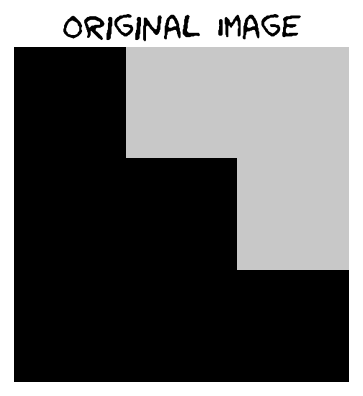

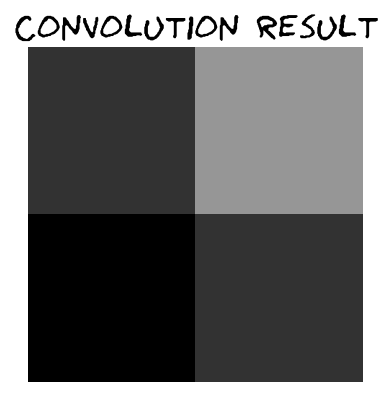

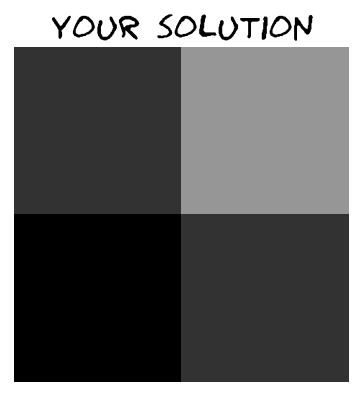

In [19]:
# to_remove solution
def conv_check():
  # Write the solution array and call the function to verify it!
  solution = np.array([
                       [50, 150],
                       [0,   50]
                       ])

  original = np.array([
                       [0, 200, 200],
                       [0,   0, 200],
                       [0,   0,   0]
                       ])

  kernel = np.array([
                     [0.25, 0.25],
                     [0.25, 0.25]
                     ])

  actual_convolution = scipy.signal.correlate2d(original, kernel, mode="valid")

  if (solution == actual_convolution).all():
    print("✅ Your solution is correct!\n")
  else:
    print("❌ Your solution is incorrect.\n")

  return original, kernel, actual_convolution, solution


# add event to airtable
atform.add_event('Coding Exercise 2.1: Convolution of a Simple Kernel')

## Uncomment to test your solution!
original, kernel, actual_convolution, solution = conv_check()
with plt.xkcd():
  make_plots(original, actual_convolution, solution)

## Coding Exercise 2.2: Convolution Output Size

Now, you have manually calculated a convolution. How did this change the shape of the output? When you know the shapes of the input matrix and kernel, what is the shape of the output?

**Hint:** If you have problems figuring out what the output shape should look like, go back to the visualisation and see how the output shape changes as you modify the image and kernel size.

In [20]:
def calculate_output_shape(image_shape, kernel_shape):
  image_height, image_width = image_shape
  kernel_height, kernel_width = kernel_shape
  ####################################################################
  # Fill in missing code below, then remove or comment the line below to test your function
  raise NotImplementedError("Fill in the lines below, then delete this")
  ####################################################################
  output_height = ...
  output_width = ...
  return output_height, output_width


# add event to airtable
atform.add_event('Coding Exercise 2.2: Convolution Output Size')

# here we check if your function works correcly by applying it to different image
# and kernel shapes
# check_shape_function(calculate_output_shape, image_shape=(3, 3), kernel_shape=(2, 2))
# check_shape_function(calculate_output_shape, image_shape=(3, 4), kernel_shape=(2, 3))
# check_shape_function(calculate_output_shape, image_shape=(5, 5), kernel_shape=(5, 5))
# check_shape_function(calculate_output_shape, image_shape=(10, 20), kernel_shape=(3, 2))
# check_shape_function(calculate_output_shape, image_shape=(100, 200), kernel_shape=(40, 30))

In [21]:
# to_remove solution
def calculate_output_shape(image_shape, kernel_shape):
  image_height, image_width = image_shape
  kernel_height, kernel_width = kernel_shape
  output_height = image_height - kernel_height + 1
  output_width = image_width - kernel_width + 1
  return output_height, output_width


# add event to airtable
atform.add_event('Coding Exercise 2.2: Convolution Output Size')

# here we check if your function works correcly by applying it to different image
# and kernel shapes
check_shape_function(calculate_output_shape, image_shape=(3, 3), kernel_shape=(2, 2))
check_shape_function(calculate_output_shape, image_shape=(3, 4), kernel_shape=(2, 3))
check_shape_function(calculate_output_shape, image_shape=(5, 5), kernel_shape=(5, 5))
check_shape_function(calculate_output_shape, image_shape=(10, 20), kernel_shape=(3, 2))
check_shape_function(calculate_output_shape, image_shape=(100, 200), kernel_shape=(40, 30))

✅ Output for image_shape: (3, 3) and kernel_shape: (2, 2), output_shape: (2, 2), is correct.
✅ Output for image_shape: (3, 4) and kernel_shape: (2, 3), output_shape: (2, 2), is correct.
✅ Output for image_shape: (5, 5) and kernel_shape: (5, 5), output_shape: (1, 1), is correct.
✅ Output for image_shape: (10, 20) and kernel_shape: (3, 2), output_shape: (8, 19), is correct.
✅ Output for image_shape: (100, 200) and kernel_shape: (40, 30), output_shape: (61, 171), is correct.


## Coding Exercise 2.3: Coding a Convolution

Here, we have the skeleton of a function that performs convolution using the provided image and kernel matrices. 

*Exercise:* Fill in the missing lines of code. You can test your function by uncommenting the sections beneath it.

Note: in more general situations, once you understand convolutions, you can use functions already available in `pytorch`/`numpy` to perform convolution (such as `scipy.signal.correlate2d` or `scipy.signal.convolve2d`).

In [22]:
def convolution2d(image, kernel):
  """Convolves a 2D image matrix with a kernel matrix. Both are numpy arrays."""

  # get the height/width of the image, kernel, and output
  im_h, im_w = image.shape
  ker_h, ker_w = kernel.shape
  out_h = im_h - ker_h + 1
  out_w = im_w - ker_w + 1

  # create an empty matrix in which to store the output
  output = np.zeros((out_h, out_w))

  # iterate over the different positions at which to apply the kernel,
  #   storing the results in the output matrix
  for out_row in range(out_h):
    for out_col in range(out_w):
      # overlay the kernel on part of the image
      #   (multiply each element of the kernel with some element of the image, then sum)
      #   to determine the output of the matrix at a point
      current_product = 0
      for i in range(ker_h):
        for j in range(ker_w):
          ####################################################################
          # Fill in missing code below (...),
          # then remove or comment the line below to test your function
          raise NotImplementedError("Implement the convolution function")
          ####################################################################
          current_product += ...

      output[out_row, out_col] = current_product

  return output


# add event to airtable
atform.add_event('Coding Exercise 2.3: Coding a Convolution')

## Tests
# first, we test the parameters we used before in the manual-calculation example
image = np.array([[0,  200, 200], [0,   0,  200], [0,   0,   0]])
kernel = np.array([[0.25, 0.25], [0.25, 0.25]])
# check_conv_function(convolution2d, image, kernel)

# next, we test with a different input and kernel (the numbers 1-9 and 1-4)
image = np.arange(9).reshape(3, 3)
kernel = np.arange(4).reshape(2, 2)
# check_conv_function(convolution2d, image, kernel)

In [23]:
# to_remove_solution
def convolution2d(image, kernel):
  """Convolves a 2D image matrix with a kernel matrix. Both are numpy arrays."""

  # get the height/width of the image, kernel, and output
  im_h, im_w = image.shape
  ker_h, ker_w = kernel.shape
  out_h = im_h - ker_h + 1
  out_w = im_w - ker_w + 1

  # create an empty matrix in which to store the output
  output = np.zeros((out_h, out_w))

  # iterate over the different positions at which to apply the kernel,
  #   storing the results in the output matrix
  for out_row in range(out_h):
    for out_col in range(out_w):
      # overlay the kernel on part of the image
      #   (multiply each element of the kernel with some element of the image, then sum)
      #   to determine the output of the matrix at a point
      current_product = 0
      for i in range(ker_h):
        for j in range(ker_w):
          current_product += image[out_row + i, out_col + j] * kernel[i, j]

      output[out_row, out_col] = current_product

  return output


# add event to airtable
atform.add_event('Coding Exercise 2.3: Coding a Convolution')

## Tests
# first, we test the parameters we used before in the manual-calculation example
image = np.array([[0,  200, 200], [0,   0,  200], [0,   0,   0]])
kernel = np.array([[0.25, 0.25], [0.25, 0.25]])
check_conv_function(convolution2d, image, kernel)

# next, we test with a different input and kernel (the numbers 1-9 and 1-4)
image = np.arange(9).reshape(3, 3)
kernel = np.arange(4).reshape(2, 2)
check_conv_function(convolution2d, image, kernel)

✅ The function calculated the convolution correctly.
✅ The function calculated the convolution correctly.


### Convolution on the Chicago Skyline

After you have finished programming the above convolution function, run the below coding cell, which applies two different kernels to a greyscale picture of Chicago and takes the geometric average of the results.

**Make sure you remove all print statements from your convolution2d implementation, or this will run for a _very_ long time.** It should take somewhere between 10 seconds and 1 minute.



In [24]:
# @markdown ### Load images (run me)

import requests, os

if not os.path.exists('images/'):
  os.mkdir('images/')

url = "https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D1_ConvnetsAndRecurrentNeuralNetworks/static/chicago_skyline_shrunk_v2.bmp"
r = requests.get(url, allow_redirects=True)
with open("images/chicago_skyline_shrunk_v2.bmp", 'wb') as fd:
  fd.write(r.content)

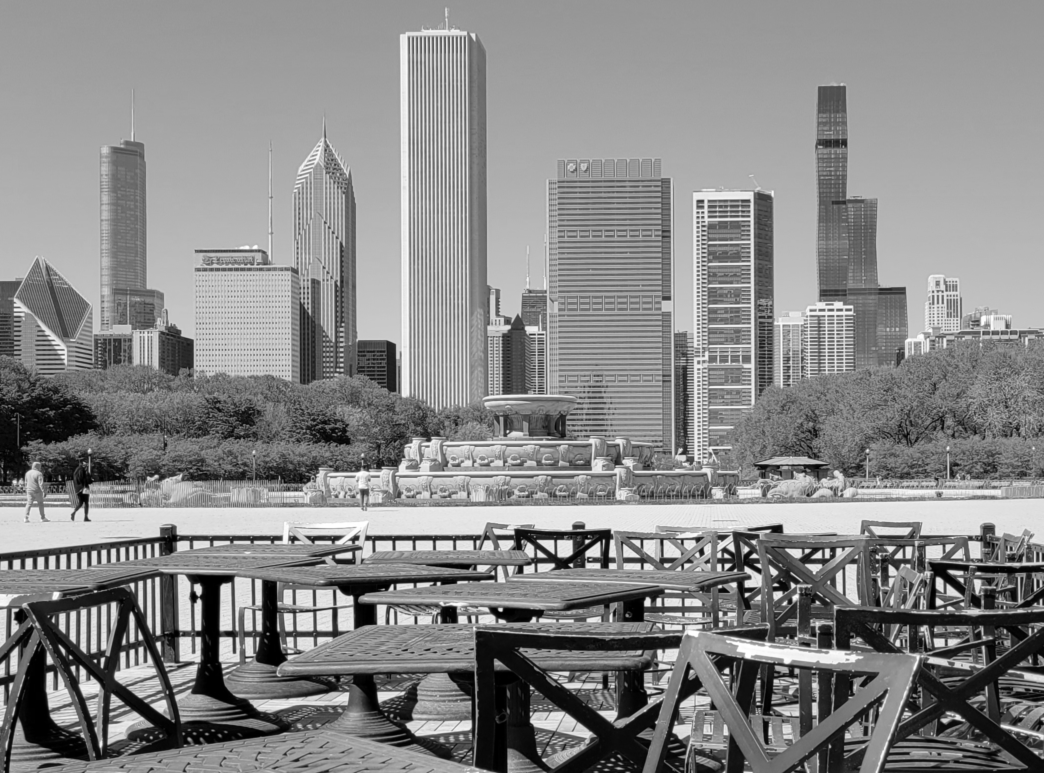

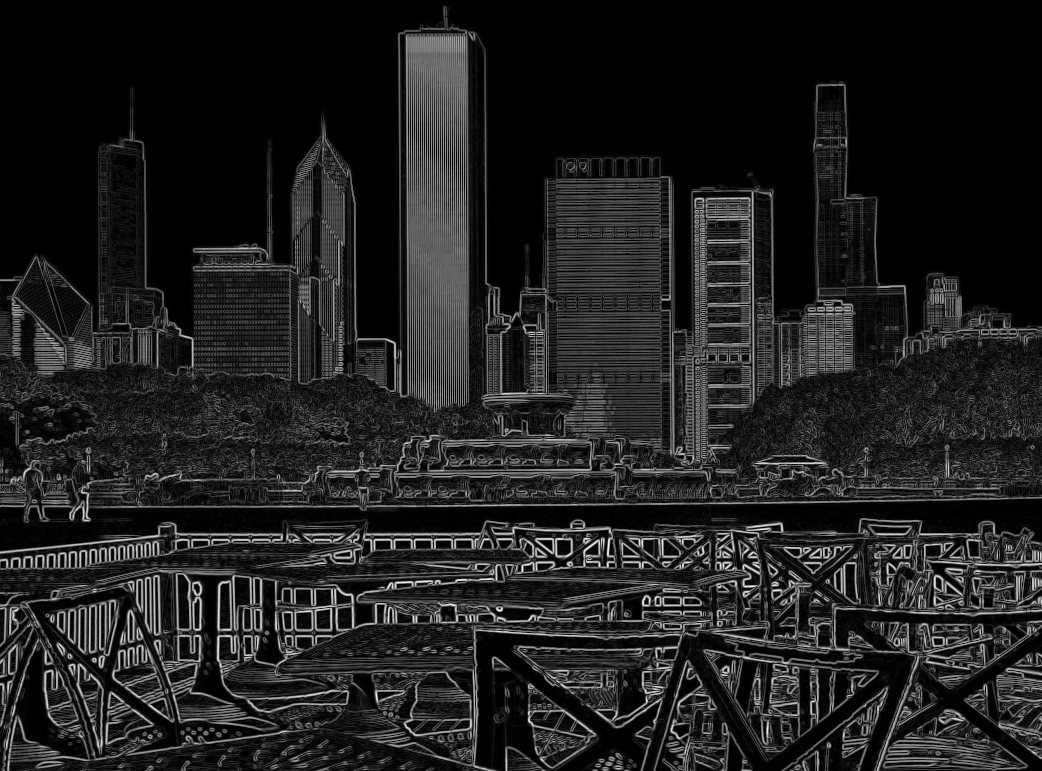

In [25]:
# Visualize the output of your function
with open("images/chicago_skyline_shrunk_v2.bmp", 'rb') as skyline_image_file:
  img_skyline_orig = Image.open(skyline_image_file)
  img_skyline_mat = np.asarray(img_skyline_orig)
  kernel_ver = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  kernel_hor = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).T
  img_processed_mat_ver = convolution2d(img_skyline_mat, kernel_ver)
  img_processed_mat_hor = convolution2d(img_skyline_mat, kernel_hor)
  img_processed_mat = np.sqrt(np.multiply(img_processed_mat_ver,
                                          img_processed_mat_ver) + \
                              np.multiply(img_processed_mat_hor,
                                          img_processed_mat_hor))

  img_processed_mat *= 255.0/img_processed_mat.max()
  img_processed_mat = img_processed_mat.astype(np.uint8)
  img_processed = Image.fromarray(img_processed_mat, 'L')
  display(img_skyline_orig)
  display(img_processed)

Pretty cool, right? We will go into more detail on what's happening in the next section.

## Section 2.1: Demonstration of a CNN in PyTorch
At this point, you should have a fair idea of how to perform a convolution on an image given a kernel. In the following cell, we provide a code snippet that demonstrates setting up a convolutional network using PyTorch.

We look at the `nn` module in PyTorch. The `nn` module contains a plethora of functions that will make implementing a neural network easier. In particular we will look at the `nn.Conv2d()` function, which creates a convolutional layer that is applied to whatever image that you feed the resulting network. 

Look at the code below. In it, we define a `Net` class that you can instantiate with a kernel to create a Neural Network object. When you apply the network object to an image (or anything in the form of a matrix), it convolves the kernel over that image.

In [26]:
class Net(nn.Module):
  """
  A convolutional neural network class.
  When an instance of it is constructed with a kernel, you can apply that instance
    to a matrix and it will convolve the kernel over that image.
  i.e. Net(kernel)(image)
  """
  def __init__(self, kernel=None, padding=0):
    super(Net, self).__init__()
    # Summary of the nn.conv2d parameters (you can also get this by hovering
    # over the method):
    # in_channels (int): Number of channels in the input image
    # out_channels (int): Number of channels produced by the convolution
    # kernel_size (int or tuple): Size of the convolving kernel
    # padding (int or tuple, optional): Zero-padding added to both sides of
    #     the input. Default: 0
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, \
                           padding=padding)

    # set up a default kernel if a default one isn't provided
    if kernel is not None:
      dim1, dim2 = kernel.shape[0], kernel.shape[1]
      kernel = kernel.reshape(1, 1, dim1, dim2)

      self.conv1.weight = torch.nn.Parameter(kernel)
      self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))

  def forward(self, x):
    x = self.conv1(x)
    return x

In [27]:
# Format a default 2x2 kernel of numbers from 0 through 3
kernel = torch.Tensor(np.arange(4).reshape(2, 2))
# Prepare the network with that default kernel
net = Net(kernel=kernel, padding=0).to(DEVICE)

# set up a 3x3 image matrix of numbers from 0 through 8
image = torch.Tensor(np.arange(9).reshape(3, 3))
image = image.reshape(1, 1, 3, 3).to(DEVICE) # BatchSizeXChannelsXHeightXWidth

print("Image:\n" + str(image))
print("Kernel:\n" + str(kernel))
output = net(image) # Apply the convolution
print("Output:\n" + str(output))

Image:
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]], device='cuda:0')
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[19., 25.],
          [37., 43.]]]], device='cuda:0', grad_fn=<AddBackward0>)


As a quick aside, notice the difference in the input and output size. The input had a size of 3×3, and the output is of size 2×2. This is because of the fact that the kernel can't produce values for the edges of the image - when it slides to an end of the image and is centered on a border pixel, it overlaps space outside of the image that is undefined. If we don't want to lose that information, we will have to pad the image with some defaults (such as 0s) on the border. This process is, somewhat predictably, called *padding*. We will talk more about padding in the next section.

In [28]:
print("Image (before padding):\n" + str(image))
print("Kernel:\n" + str(kernel))

# Prepare the network with the aforementioned default kernel, but this
# time with padding
net = Net(kernel=kernel, padding=1).to(DEVICE)
output = net(image)  # Apply the convolution onto the padded image
print("Output:\n" + str(output))

Image (before padding):
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]], device='cuda:0')
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[ 0.,  3.,  8.,  4.],
          [ 9., 19., 25., 10.],
          [21., 37., 43., 16.],
          [ 6.,  7.,  8.,  0.]]]], device='cuda:0', grad_fn=<AddBackward0>)


## Section 2.2: Padding and Edge Detection

Before we start in on the exercises, here's a visualization to help you think about padding.

### Interactive Demo 2.2: Visualization of Convolution with Padding and Stride


Recall that 
* Padding adds rows and columns of zeros to the outside edge of an image
* Stride length adjusts the distance by which a filter is shifted after each convolution.

Change the padding and stride and see how this affects the shape of the output. How does the padding need to be configured to maintain the shape of the input?

In [29]:
%%html

# @markdown *Run this cell to enable the widget!*

<style>
  svg {
      #border: 1px solid black;
  }
  .matrix {
      font-family: sans-serif;
      transition: all 700ms ease-in-out;
  }
  .cell rect {
      fill:white;stroke-width:1;stroke:rgb(0,0,0)
  }
  .padding rect {
      stroke: rgba(0, 0, 0, 0.25);
  }
  .padding text {
      fill: lightgray;
  }
  .highlight1 {
      fill:none;stroke-width:4;stroke: rgb(236, 58, 58);stroke-dasharray:10,5;
  }
  .highlight2 {
      fill:rgba(229, 132, 66, 0.25);stroke-width:5;stroke: rgb(229, 132, 66);
  }
  .highlight3 {
      fill:rgba(236, 58, 58, 0.25);stroke-width:2;stroke: rgb(236, 58, 58);;
  }
  .title {
      text-anchor: middle;
  }
  .button_play {
      display: inline-block;
      background: none;
      border: none;
      position: relative;
      top: -3px;
  }
  .button_play path {
      fill: darkgray;
  }
  .button_play:hover path {
      fill: rgb(236, 58, 58);
  }
  .display_vis_input input:not(:hover)::-webkit-outer-spin-button,
  .display_vis_input input:not(:hover)::-webkit-inner-spin-button {
      -webkit-appearance: none;
      margin: 0;
  }

  .display_vis_input input:not(:hover)[type=number] {
      -moz-appearance:textfield;
      width: 1ch;
      margin-right: 0px;
      z-index: 0;
  }
  .display_vis_input input[type=number] {
      width: 4ch;
      border: 0px;
      margin-right: -3ch;
      z-index: 6;
      display: inline-block;
      position: relative;
      padding: 0;
      border-bottom: 2px solid red;
      background: white;
      color: black
  }
  .display_vis_input .pair {
      display: inline-block;
      white-space:nowrap;
          position: relative;
  }
  .display_vis_input .pair .pair_hide {
      max-width: 4em;
      transition: max-width 1s ease-in;
      display: inline-block;
      overflow: hidden;
      position: relative;
      top: 5px;
  }
  .pair:not(:hover) .pair_hide {
      max-width: 0;
  }
  .pairX .pair_hide {
      max-width: 4em;
      transition: max-width 1s ease-in;
  }

  /* Dropdown Button */
  .dropbtn {
    border-bottom: 2px solid red;
  }

  /* The container <div> - needed to position the dropdown content */
  .dropdown {
    position: relative;
    display: inline-block;
  }

  /* Dropdown Content (Hidden by Default) */
  .dropdown-content {
    display: none;
    position: absolute;
    background-color: #f1f1f1;
    min-width: 160px;
    box-shadow: 0px 8px 16px 0px rgba(0,0,0,0.2);
    z-index: 1;
  }

  /* Links inside the dropdown */
  .dropdown-content a {
    color: black;
    padding: 5px 2px;
    text-decoration: none;
    display: block;
  }

  /* Change color of dropdown links on hover */
  .dropdown-content a:hover {background-color: #ddd;}

  /* Show the dropdown menu on hover */
  .dropdown:hover .dropdown-content {display: block;}
</style>

<script src="https://d3js.org/d3.v3.min.js" charset="utf-8" > </script>


<div id="animation_conv_padding" style="background: white">
  <div class="display_vis_input language-python" style="font-family: monospace; color: black; padding: 10px;">

      <!-- padding -->
      import torch<br><br>
      input = torch.rand(1, 1<input class="input_matrixz" type="hidden" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">)<br>
      conv = torch.nn.Conv2d(in_channels=1<input class="input_matrixzB" type="hidden" min="1" max="3" value="1">, out_channels=1<input class="input_filterz" type="hidden" min="1" max="3" value="1">,
      kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                      <input class="input_filtery" type="number" min="2" max="4" value="3">)</span></span>,
      stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="1"><span class="pair_hide">,
                                                                <input class="input_stridey" type="number" min="1" max="2" value="1">)</span></span>,
      padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="1"><span class="pair_hide">,
                                                                  <input class="input_paddingy" type="number" min="0" max="4" value="1">)</span></span>)<br>
      result = conv(input)

  </div>
      <button class="button_play play"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 1.5,0 9.5,5 1.5,10 z"/></svg></button>
  <button class="button_play pause" style="display: none"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 0,0 4,0 4,10, 0,10 z"/><path d="M 6,0 10,0 10,10, 6,10 z"/></svg></button>
  <input type="range" min="1" max="100" value="50" class="slider" style="width: 300px; display: inline-block">
  <button class="button_play left"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,5 4,0 4,10 z"/></svg></button>
  <button class="button_play right"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,0 4,5 0,10 z"/></svg></button>
  <input type="checkbox" class="play_fast">fast play mode
  <br/>
  <svg height="0" width="0">
      <defs>
  <marker id="arrowhead" markerWidth="10" markerHeight="7"
  refX="0" refY="1.5" orient="auto" fill="rgb(236, 58, 58)">
    <polygon points="0 0, 4 1.5, 0 3" />
  </marker>
</defs>
  </svg>
  <svg class="image" height="460" width="600">

  </svg>
</div>

<script>
  (function() {
  var dom_target = document.getElementById("animation_conv_padding")
  const divmod = (x, y) => [Math.floor(x / y), x % y];
  var svg = d3.select(dom_target).select(".image")

  var box_s = 50;
  var box_z = 10;
  var show_single_elements = true;
  var group_func = undefined;
  function mulberry32(a) {
      return function() {
        var t = a += 0x6D2B79F5;
        t = Math.imul(t ^ t >>> 15, t | 1);
        t ^= t + Math.imul(t ^ t >>> 7, t | 61);
        return ((t ^ t >>> 14) >>> 0) / 4294967296;
      }
  }

  function numberGenerator(seed, max, digits) {
      var random = mulberry32(seed)
      return () => parseFloat((random() * max).toFixed(digits));
  }
  window.numberGenerator = numberGenerator
  window.mulberry32 = mulberry32
  function generateMatrix2(number, dims) {
      var res = [];
      for (var i = 0; i < dims[0]; i++) {
          if(dims.length == 1)
              res.push(number())
          else
              res.push(generateMatrix2(number, dims.slice(1)));
      }
      return res
  }
  window.generateMatrix2 = generateMatrix2

  function addPadding(matrix, paddingx, paddingy) {
      matrix = JSON.parse(JSON.stringify(matrix));
      var ly = matrix.length; var lx = matrix[0].length;
      for (var i = 0; i < ly; i++) {
          for(var p = 0; p < paddingx; p++) {
              matrix[i].splice(0, 0, 0);
              matrix[i].splice(matrix[i].length, 0, 0);
          }
      }
      for(var p = 0; p < paddingy; p++) {
          matrix.splice(0, 0, []);
          matrix.splice(matrix.length, 0, []);
          for (var i = 0; i < lx + paddingx * 2; i++) {
              matrix[0].push(0);
              matrix[matrix.length - 1].push(0);
          }
      }
      matrix.paddingx = paddingx;
      matrix.paddingy = paddingy;
      return matrix;
  }

  var stride_x = 1;
  var stride_y = 1;
  function convolve(matrix, filter) {
      var ress = [];
      for(var zz = 0; zz < filter.length; zz++) {
          var res = [];
          for (var i = 0; i < parseInt((matrix[0].length - filter[0][0].length + stride_y) / stride_y); i++) {
              res.push([]);
              for (var j = 0; j < parseInt((matrix[0][0].length - filter[0][0][0].length + stride_x) / stride_x); j++) {
                  var answer = 0;
                  var text = "";
                  for (var ii = 0; ii < filter[0][0].length; ii++) {
                      for (var jj = 0; jj < filter[0][0][0].length; jj++) {
                          for (var z = 0; z < matrix.length; z++) {
                              answer += matrix[z][i * stride_y + ii][j * stride_x + jj] * filter[zz][z][ii][jj];
                              text +=matrix[z][i * stride_y + ii][j * stride_x + jj] + "*" + filter[zz][z][ii][jj]+"+";
                          }
                      }
                  }
                  console.log(i, j, text, "=", answer)
                  res[res.length - 1].push(answer.toFixed(1))
              }
          }
          ress.push(res)
      }
      return ress;
  }
  function pool(matrix, filter, func) {
      var res = [];
      for (var i = 0; i < parseInt((matrix.length - filter.length + stride_y) / stride_y); i++) {
          res.push([]);
          for (var j = 0; j < parseInt((matrix[0].length - filter[0].length + stride_x) / stride_x); j++) {
              var answer = [];
              for(var ii = 0; ii < filter.length; ii++) {
                  for(var jj = 0; jj < filter[0].length; jj++) {
                      answer.push(matrix[i* stride_y + ii][j* stride_x + jj]);
                  }
              }
              if(func == "max")
                  res[res.length-1].push(Math.max(...answer))
              else {
                  var sum = 0;
                  for( var ii = 0; ii < answer.length; ii++)
                      sum += answer[ii]; //don't forget to add the base
                  var avg = sum/answer.length;
                  res[res.length-1].push(parseFloat(avg.toFixed(1)));
              }

          }
      }
      return res;
  }

  class Matrix {
      constructor(x, y, matrix, title) {
          this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`);
          for(var z = 0; z < matrix.length; z++) {
              var gg = this.g.append("g").attr("class", "matrix_layer").attr("transform", `translate(${- z*box_z}, ${+ z*box_z})`);
              for (var j = 0; j < matrix[0].length; j++) {
                  for (var i = 0; i < matrix[0][0].length; i++) {
                      var element = gg.append("g").attr("class", "cell").attr("transform", `translate(${i * box_s}, ${j * box_s})`);
                      var rect = element.append("rect")
                          .attr("class", "number")
                          .attr("x", -box_s / 2 + "px")
                          .attr("y", -box_s / 2 + "px")
                          .attr("width", box_s + "px")
                          .attr("height", box_s + "px")
                      if (i < matrix.paddingx || j < matrix.paddingy || i > matrix[0][0].length - matrix.paddingx - 1 || j > matrix[0].length - matrix.paddingy - 1)
                          element.attr("class", "cell padding")
                      element.append("text").text(matrix[z][j][i]).attr("text-anchor", "middle").attr("alignment-baseline", "center").attr("dy", "0.3em")
                  }
              }
              gg.append("rect").attr("class", "highlight3")
              gg.append("rect").attr("class", "highlight1")
              gg.append("rect").attr("class", "highlight2")
          }
          this.arrow = gg.append("line").attr("transform", `translate(${(-0.5)*box_s}, ${(-0.5+filter.length/2)*box_s})`).attr("marker-end", "url(#arrowhead)").attr("x1", 0).attr("y1", 0).attr("x2", 50).attr("y2", 0)
              .attr("stroke", "#000").attr("stroke-width", 8).attr("stroke", "rgb(236, 58, 58)").style("opacity", 0)


          gg.append("text").attr("class", "title").text(title)
              .attr("x", (matrix[0][0].length/2-0.5)*box_s+"px")
              .attr("y", (matrix[0].length)*box_s+"px")
              .attr("dy", "0em")
          this.highlight2_hidden = true
      }

      setHighlight1(i, j, w, h) {
          if(this.old_i == i && this.old_j == j && this.old_w == w)
              return
          if(i == this.old_i+stride_x || j == this.old_j+stride_y) {
              if (this.old_j == j)
                  this.arrow.attr("x1", this.old_i * box_s).attr("y1", j * box_s)
                      .attr("x2", i * box_s - 30).attr("y2", j * box_s).attr("transform", `translate(${(-0.5) * box_s}, ${(-0.5 + h / 2) * box_s})`)
              else
                  this.arrow.attr("x1", i * box_s).attr("y1", this.old_j * box_s)
                      .attr("x2", i * box_s).attr("y2", j * box_s - 30).attr("transform", `translate(${(-0.5 + w / 2) * box_s}, ${(-0.5) * box_s})`)
              this.arrow.transition().style("opacity", 1)
                  .transition()
                  .duration(1000)
                  .style("opacity", 0)
          }
          this.old_i = i; this.old_j = j; this.old_w = w;
          this.g.selectAll(".highlight1")
              .style("fill", "rgba(236, 58, 58, 0)")
              .transition()
              .duration(1000)
              .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
              .attr("width", box_s*w+"px")
              .attr("height", box_s*h+"px")
              .style("fill", "rgba(236, 58, 58, 0.25)")
          this.g.selectAll(".highlight3")
              .style("opacity", 1)
              .transition()
              .duration(1000)
              .style("opacity", 0)
          this.g.selectAll(".highlight3")
              .transition()
              .delay(900)
              .duration(0)
              .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
              .attr("width", box_s*w+"px")
              .attr("height", box_s*h+"px")
  //            .style("opacity", 1)
      }

      setHighlight2(i, j, w, h) {
          if(this.highlight2_hidden == true) {
              this.g.selectAll(".highlight2")
              .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
              .attr("width", box_s*w+"px")
              .attr("height", box_s*h+"px")
              .transition()
              .duration(1000)
              .style("opacity", 1)
              this.highlight2_hidden = false
              return
          }
          this.g.selectAll(".highlight2")
              .transition()
              .duration(1000)
              .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
              .attr("width", box_s*w+"px")
              .attr("height", box_s*h+"px");
      }
      hideHighlight2() {
          this.highlight2_hidden = true
          this.g.selectAll(".highlight2")
              .transition()
              .duration(1000)
              .style("opacity", 0)
      }
  }

  class Calculation {
      constructor(x, y, matrix, title) {
          this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
          this.g.append("text").text(title).attr("dy", "-1.5em").attr("dx", "2em")
          this.g = this.g.append("text")
          for (var j in matrix) {
              for (var i in matrix[j]) {
                  var element = this.g;
                  var a = element.append("tspan")
                      .text(i+"·"+j)
                  if(i == 0 && j > 0)
                      a.attr("dy", "1.5em").attr("x", 0)
                  if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                      a = element.append("tspan")
                      .attr("dy", "1.5em").attr("x", 0)
                      .text(" = 12 ")
                  }
                  else {
                      a = element.append("tspan")
                          .text(" + ")
                  }
              }
          }
      }
      setText(i, text) {
          d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
      }
      hideAll() {
          this.g.selectAll("tspan")
              .attr("fill", "white")
      }
      setHighlight1(i) {
          this.g.selectAll("tspan")
              .transition()
              .duration(1000)
              .attr("fill",
              (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

      }
  }

  class CalculationPool {
      constructor(x, y, matrix, title) {
          this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
          this.g.append("text").text(title).attr("dy", "-3em").attr("dx", "-2em")
          this.g.append("text").text(group_func+"([").attr("dy", "-1.5em").attr("dx", "-0.5em")
          this.g = this.g.append("text")
          for (var j in matrix) {
              for (var i in matrix[j]) {
                  var element = this.g;
                  var a = element.append("tspan")
                      .text("")
                  if(i == 0 && j > 0)
                      a.attr("dy", "1.5em").attr("x", 0)
                  if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                      a = element.append("tspan")
                      .attr("dy", "1.5em").attr("x", 0).attr("dx", "-0.5em")
                      .text("")
                  }
                  else {
                      a = element.append("tspan")
                          .text("")
                  }
              }
          }
      }
      setText(i, text) {
          d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
      }
      hideAll() {
          this.g.selectAll("tspan")
              .attr("fill", "white")
      }
      setHighlight1(i) {
          this.g.selectAll("tspan")
              .transition()
              .duration(1000)
              .attr("fill",
              (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

      }
  }

  var matrix, res, m, f, r, c, last_pos, index_max;
  function init() {
      show_single_elements = dom_target.querySelector(".play_fast").checked == false

      svg.selectAll("*").remove();

      dom_target.querySelector(".input_matrixzB").value = dom_target.querySelector(".input_matrixz").value

      console.log("dom_target", dom_target)
      console.log("dom_target.querySelector(\".input_filterx\").value)", dom_target.querySelector(".input_filterx").value)
      filter = generateMatrix2(numberGenerator(17, 0.9, 1), [parseInt(dom_target.querySelector(".input_filterz").value), parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_filtery").value), parseInt(dom_target.querySelector(".input_filterx").value)]);
      if(dom_target.querySelector(".input_filterx").value == dom_target.querySelector(".input_filtery").value)
          dom_target.querySelector(".input_filterx").parentElement.className = "pair"
      else
          dom_target.querySelector(".input_filterx").parentElement.className = "pairX"
      matrix_raw = generateMatrix2(numberGenerator(4, 9, 0), [parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_matrixy").value), parseInt(dom_target.querySelector(".input_matrixx").value)]);

      matrix = JSON.parse(JSON.stringify(matrix_raw));
      for(var z = 0; z < matrix.length; z++)
          matrix[z] = addPadding(matrix_raw[z], parseInt(dom_target.querySelector(".input_paddingx").value), parseInt(dom_target.querySelector(".input_paddingy").value));
      matrix.paddingx = matrix[0].paddingx
      matrix.paddingy = matrix[0].paddingy
      stride_x = parseInt(dom_target.querySelector(".input_stridex").value)
      stride_y = parseInt(dom_target.querySelector(".input_stridey").value)

      if(dom_target.querySelector(".input_stridex").value == dom_target.querySelector(".input_stridey").value)
          dom_target.querySelector(".input_stridex").parentElement.className = "pair"
      else
          dom_target.querySelector(".input_stridex").parentElement.className = "pairX"
          if(dom_target.querySelector(".input_paddingx").value == dom_target.querySelector(".input_paddingy").value)
          dom_target.querySelector(".input_paddingx").parentElement.className = "pair"
      else
          dom_target.querySelector(".input_paddingx").parentElement.className = "pairX"

      res = convolve(matrix, filter);
          window.matrix = matrix
          window.filter = filter
          window.res = res
      if(group_func != undefined)
          res = [pool(matrix[0], filter[0][0], group_func)]

      m = new Matrix(1*box_s, (1+filter[0][0].length+1.5)*box_s, matrix, "Matrix");

      f = []
      for(var zz = 0; zz < filter.length; zz++)
          f.push(new Matrix((1+(matrix[0][0].length-filter[zz][0][0].length)/2 + zz*(1+filter[zz][0][0].length))*box_s, 1*box_s, filter[zz], group_func == undefined ? (filter.length != 1? `Filter ${zz}` : `Filter`) : "Pooling"));
      if(group_func != undefined)
          f[0].g.selectAll(".cell text").attr("fill", "white")

      console.log("res", res)
      r = new Matrix((2+(matrix[0][0].length)+1)*box_s, (1+filter[0][0].length+1.5)*box_s, res, "Result");

      var c_x = Math.max((1+(matrix[0][0].length))*box_s, (3+filter.length*(1+(filter[0][0].length)))*box_s)
      console.log("m,ax", (1+(matrix[0][0].length)), filter.length*(1+(filter[0][0].length)))
      if(group_func != undefined)
          c = new CalculationPool(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");
      else
          c = new Calculation(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");

      last_pos = undefined;
      if(show_single_elements)
          index_max = filter.length*res[0].length*res[0][0].length*(filter[0][0].length * filter[0][0][0].length + 2)
      else
          index_max = filter.length*res[0].length*res[0][0].length
      window.index_max = index_max
      window.filter = filter
      setHighlights(0, 0)
      svg.attr("width", box_s*(matrix[0][0].length+res[0][0].length+4)+(c.g.node().getBoundingClientRect().width)+"px");
      svg.attr("height", box_s*(matrix[0].length+filter[0][0].length+3.0)+"px");
  }
  init()

  function setHighlights(pos_zz, subpos) {
      var [zz, pos] = divmod(pos_zz, res[0].length*res[0][0].length)
      var [i, j] = divmod(pos, res[0][0].length)
      i *= stride_y;
      j *= stride_x;
      var [j2, i2] = divmod(subpos, filter[0][0][0].length)
      if(last_pos != pos) {
          var answer = 0;
          for(var ii = 0; ii < filter[0][0].length; ii++) {
              for(var jj = 0; jj < filter[0][0][0].length; jj++) {
                  var text = []
                  if(filter[0].length == 1) {
                      for(var z = 0; z < filter[0].length; z++) {
                          if (group_func != undefined)
                              text.push(matrix[0][i + ii][j + jj] + ", ");
                          else
                              text.push(matrix[z][i + ii][j + jj] + " · " + filter[zz][z][ii][jj]);
                      }
                      if (group_func != undefined)
                          c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                      else
                          c.setText(ii * filter[0][0][0].length + jj, text.join("+"));
                  }
                  else {
                      for (var z = 0; z < filter[0].length; z++) {
                          if (group_func != undefined)
                              text.push(matrix[0][i + ii][j + jj] + ", ");
                          else
                              text.push(matrix[z][i + ii][j + jj] + "·" + filter[zz][z][ii][jj]);
                      }
                      if (group_func != undefined)
                          c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                      else
                          c.setText(ii * filter[0][0][0].length + jj, "(" + text.join("+") + ")");
                  }
              }
          }
          if(group_func != undefined)
              c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   ]) = "+res[zz][i/stride_y][j/stride_x])
          else
              c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   = "+res[zz][i/stride_y][j/stride_x])
          c.hideAll();
          last_pos = pos;
      }
      m.setHighlight1(j, i, filter[0][0][0].length, filter[0][0].length)
      for(var zzz = 0; zzz < filter.length; zzz++) {
          console.log(zzz, zz, zzz == zz)
          if (zzz == zz)
              f[zzz].setHighlight1(0, 0, filter[0][0][0].length, filter[0][0].length)
          else
              f[zzz].setHighlight1(0, 0, 0, 0)
      }
      window.f = f

      r.setHighlight1(j/stride_x, i/stride_y, 1, 1)
      r.g.selectAll(".matrix_layer").attr("opacity", (d,i) => i > zz ? 0.2 : 1 )
      r.g.selectAll(".matrix_layer .highlight1").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
      r.g.selectAll(".matrix_layer .highlight3").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
      window.r = r

      if(subpos < filter[0][0].length * filter[0][0][0].length) {
          m.setHighlight2(j + i2, i + j2, 1, 1)
          if(group_func == undefined)
              for(var zzz = 0; zzz < filter.length; zzz++) {
                  if (zzz == zz)
                      f[zzz].setHighlight2(i2, j2, 1, 1)
                  else
                      f[zzz].hideHighlight2()
              }
          r.g.selectAll(".cell text").attr("fill", (d, i) => i >= pos_zz ? "white" : "black")
          c.setHighlight1(subpos);
      }
      else {
          m.hideHighlight2()
          for(var zzz = 0; zzz < filter.length; zzz++)
              f[zzz].hideHighlight2()
          r.g.selectAll(".cell text").attr("fill", (d, i) => i > pos_zz ? "white" : "black")
          if(subpos > filter[0][0].length * filter[0][0][0].length) {
              c.hideAll()
          }
          else
              c.setHighlight1(subpos);
      }

      function p(x) { console.log(x); return x}
  }
  function animate(frame) {
      dom_target.querySelector("input[type=range]").value = index;
      dom_target.querySelector("input[type=range]").max = index_max - 1;
      dom_target.querySelector("input[type=range]").min = 0;
      if(show_single_elements) {
          var [pos, subpos] = divmod(frame, filter[0][0].length * filter[0][0][0].length + 2)
          setHighlights(pos, subpos);
      }
      else
          setHighlights(frame, filter[0][0].length * filter[0][0][0].length);
  }
  var index = -1
  animate(0)
  var interval = undefined;

  function PlayStep() {
      index += 1;
      if(index >= index_max)
          index = 0;
      animate(index);
  }

  function playPause() {
      if(interval === undefined) {
          dom_target.querySelector(".play").style.display = "none"
          dom_target.querySelector(".pause").style.display = "inline-block"
          interval = window.setInterval(PlayStep, 1000);
          PlayStep();
      }
      else {
          dom_target.querySelector(".play").style.display = "inline-block"
          dom_target.querySelector(".pause").style.display = "none"
          window.clearInterval(interval);
          interval = undefined;
      }
  }
  dom_target.querySelector("input[type=range]").value = 0;
  dom_target.querySelector("input[type=range]").max = index_max;
  dom_target.querySelector("input[type=range]").onchange = (i)=>{var v = parseInt(i.target.value); index = v; animate(v);};
  dom_target.querySelector(".play").onclick = playPause;
  dom_target.querySelector(".pause").onclick = playPause;
  dom_target.querySelector(".left").onclick = ()=>{index > 0 ? index -= 1 : index = index_max-1; animate(index);};
  dom_target.querySelector(".right").onclick = ()=>{index < index_max-1 ? index += 1 : index = 0; animate(index);};

  dom_target.querySelector(".input_filterx").onchange = ()=>{init()}
  dom_target.querySelector(".input_filtery").onchange = ()=>{init()}
  dom_target.querySelector(".input_filterz").onchange = ()=>{init()}
  dom_target.querySelector(".input_matrixx").onchange = ()=>{init()}
  dom_target.querySelector(".input_matrixy").onchange = ()=>{init()}
  dom_target.querySelector(".input_matrixz").onchange = ()=>{init()}
  dom_target.querySelector(".input_matrixzB").onchange = (i)=>{dom_target.querySelector(".input_matrixz").value = parseInt(i.target.value); init();};
  dom_target.querySelector(".input_paddingx").onchange = ()=>{init()}
  dom_target.querySelector(".input_paddingy").onchange = ()=>{init()}
  dom_target.querySelector(".input_stridex").onchange = ()=>{init()}
  dom_target.querySelector(".input_stridey").onchange = ()=>{init()}
  dom_target.querySelector(".play_fast").onchange = ()=>{init()}
      <!--
  dom_target.querySelector(".select_maxpool").onclick = ()=>{group_func="max"; dom_target.querySelector(".dropbtn").innerText = "MaxPool2d"; init()}
  dom_target.querySelector(".select_avgpool").onclick = ()=>{group_func="avg"; dom_target.querySelector(".dropbtn").innerText = "AvgPool2d"; init()}
  -->
  })();
</script>

### Think! 2.2.1: Edge Detection

One of the simpler tasks performed by a convolutional layer is edge detection; that is, finding a place in the image where there is a large and abrupt change in color. Edge-detecting filters are usually learned by the first layers in a CNN. Observe the following simple kernel and discuss whether this will detect vertical edges (where the trace of the edge is vertical; i.e. there is a boundary between left and right), or whether it will detect horizontal edges (where the trace of the edge is horizontal; i.e., there is a boundary between top and bottom).

\begin{equation}
\textbf{Kernel} = 
\begin{bmatrix} 1 & -1 \\ 1 & -1
\end{bmatrix} 
\end{equation}

In [30]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q3', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [31]:
# to_remove explanation

"""
It will detect vertical edges.

Consider a part of the image where values on the left are high and values on the
right are low. In this case, applying the kernel, the high values will be
maintained and the low values will be inverted, yielding a very-positive sum.

Now reverse the situation - values on the left are low and values on the right
are high. In this case, applying the kernel, the low values will be maintained
and the high values will be inverted, yielding a very-negative sum.

In any situation on the image where the left and right sides of a 2x2 block
/aren't/ much different, applying the kernel will result in decent degree of
cancellation - i.e. if it's all, say, 5, (5 + -5 + 5 + -5) = 0.

In other words, the only situations where you'll have an extremely positive or
extremely negative score are when you have a high value on either the left/right
and a low value on the other side.
""";

Consider the image below, which has a black vertical stripe with white on the side. This is like a very zoomed-in vertical edge within an image!

[[1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]]


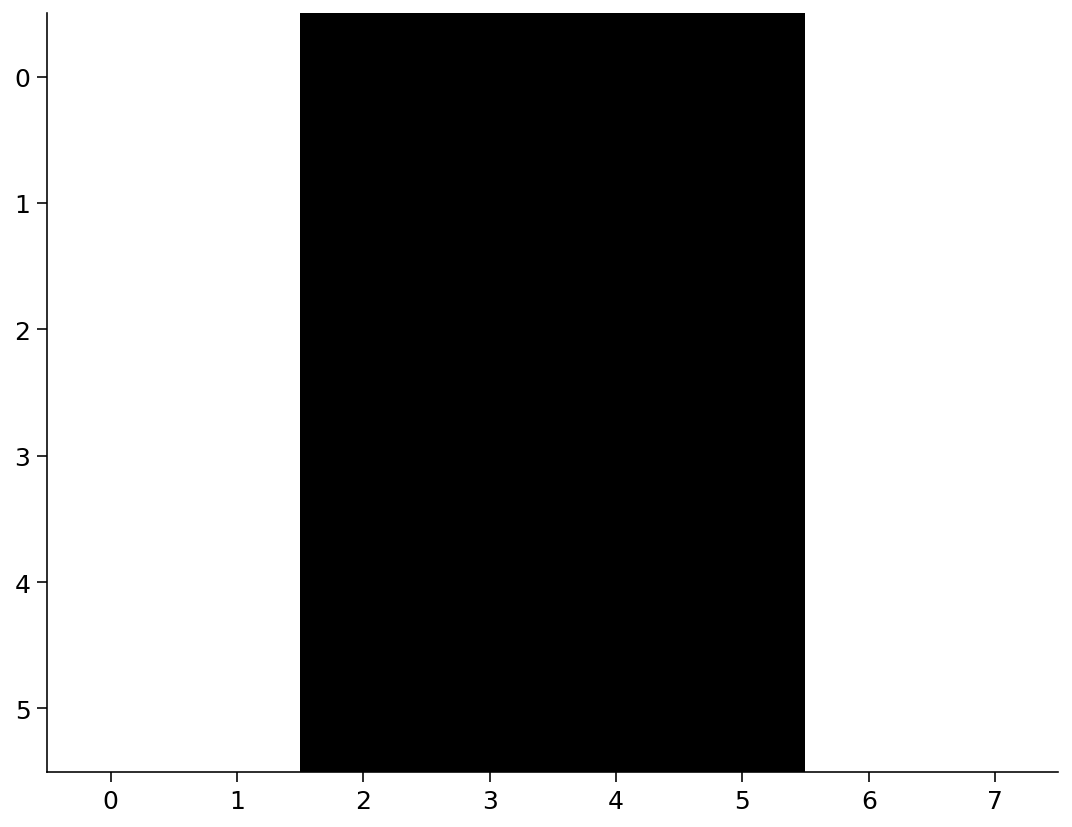

In [32]:
# Prepare an image that's basically just a vertical black stripe
X = np.ones((6, 8))
X[:, 2:6] = 0
print(X)
plt.imshow(X, cmap=plt.get_cmap('gray'))
plt.show()

[[ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]]


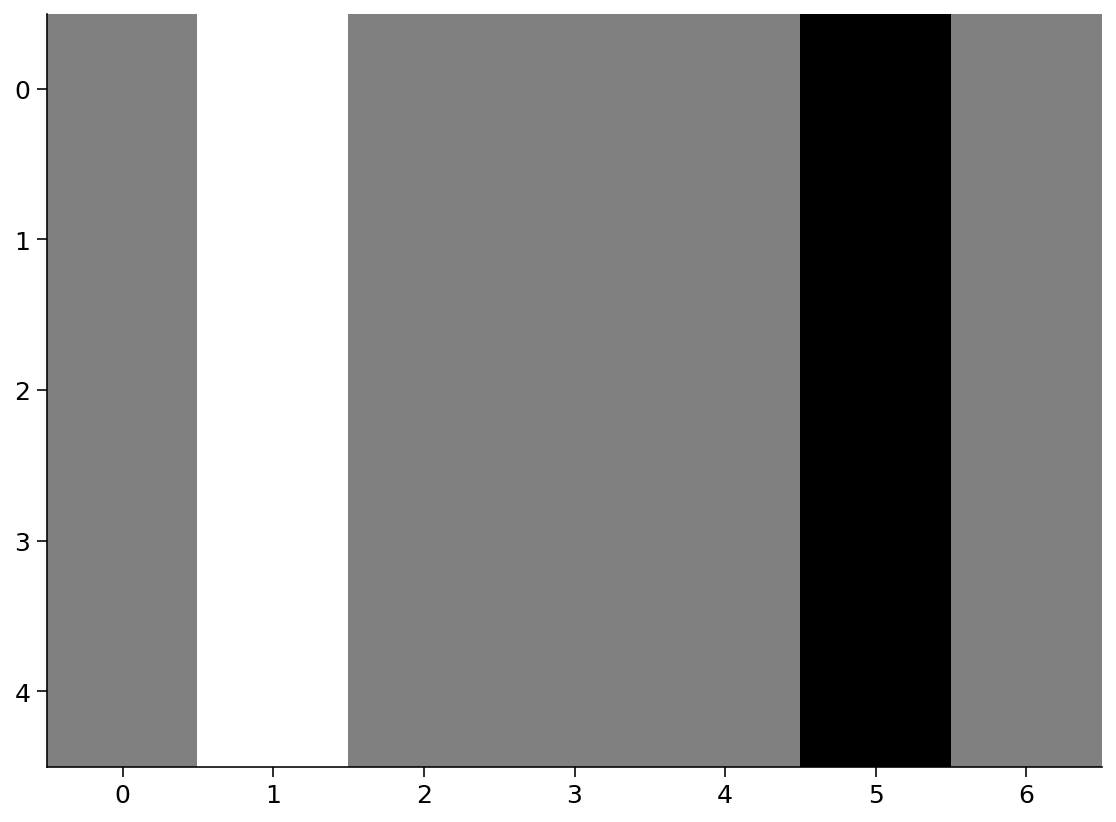

In [33]:
# Format the image that's basically just a vertical stripe
image = torch.from_numpy(X)
image = image.reshape(1, 1, 6, 8) # BatchSize X Channels X Height X Width

# Prepare a 2x2 kernel with 1s in the first column and -1s in the
# This exact kernel was discussed above!
kernel = torch.Tensor([[1.0, -1.0], [1.0, -1.0]])
net = Net(kernel=kernel)

# Apply the kernel to the image and prepare for display
processed_image = net(image.float())
processed_image = processed_image.reshape(5, 7).detach().numpy()
print(processed_image)
plt.imshow(processed_image, cmap=plt.get_cmap('gray'))
plt.show()

As you can see, this kernel detects vertical edges (the black stripe corresponds to a highly positive result, while the white stripe corresponds to a highly negative result. However, to display the image, all the pixels are normalized between 0=black and 1=white).

### Think! 2.2.2 Kernel structure

If the kernel were transposed (i.e., the columns become rows and the rows become columns), what would the kernel detect? What would be produced by running this kernel on the vertical edge image above?

In [34]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q4', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [35]:
# to_remove explanation

"""
If the kernel were transposed, it would detect horizontal edges.

Running it on the vertical edge would result in 0s - you'd have no change
going from top to bottom, so you'd be adding and subtracting the same value.

(If you're confused as to why this shows up as black, rather than gray,
it's because of how the image is normalized)
""";

---
# Section 3: Pooling and Subsampling

*Time estimate: ~50mins*

In [36]:
# @title Video 4: Pooling
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1264y1z7JZ", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"XOss-NUlpo0", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 4: Pooling')

display(out)

To visualize the various components of a CNN, we will build a simple CNN step by step. Recall that the MNIST dataset consists of binarized images of handwritten digits. This time, we will use the EMNIST letters dataset, which consists of binarized images of handwritten characters $(A, ..., Z)$.

We will simplify the problem further by only keeping the images that correspond to $X$ (labeled as `24` in the dataset) and $O$ (labeled as `15` in the dataset). Then, we will train a CNN to classify an image either an $X$ or an $O$.

In [37]:
# @title Download EMNIST dataset

# webpage: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
fname = 'EMNIST.zip'
folder = 'EMNIST'
url = "https://osf.io/xwfaj/download"
download_data(fname, folder, url, tar=False)

EMNIST dataset has already been dowloaded.



In [38]:
# @title Dataset/DataLoader Functions (run me)

# loading the dataset
def get_Xvs0_dataset(normalize=False, download=False):
  if normalize:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        ])

  emnist_train = datasets.EMNIST(root='.',
                                 split='letters',
                                 download=download,
                                 train=True,
                                 transform=transform)
  emnist_test = datasets.EMNIST(root='.',
                                split='letters',
                                download=download,
                                train=False,
                                transform=transform)

  # only want O (15) and X (24) labels
  train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
  emnist_train.targets = emnist_train.targets[train_idx]
  emnist_train.data = emnist_train.data[train_idx]

  # convert Xs predictions to 1, Os predictions to 0
  emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

  test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
  emnist_test.targets = emnist_test.targets[test_idx]
  emnist_test.data = emnist_test.data[test_idx]

  # convert Xs predictions to 1, Os predictions to 0
  emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

  return emnist_train, emnist_test



def get_data_loaders(train_dataset, test_dataset, batch_size=32, seed=0):

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, test_loader

In [39]:
emnist_train, emnist_test = get_Xvs0_dataset(normalize=False, download=False)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

# index of an image in the dataset that corresponds to an X and O
x_img_idx = 4
o_img_idx = 15

Let's view a couple samples from the dataset.

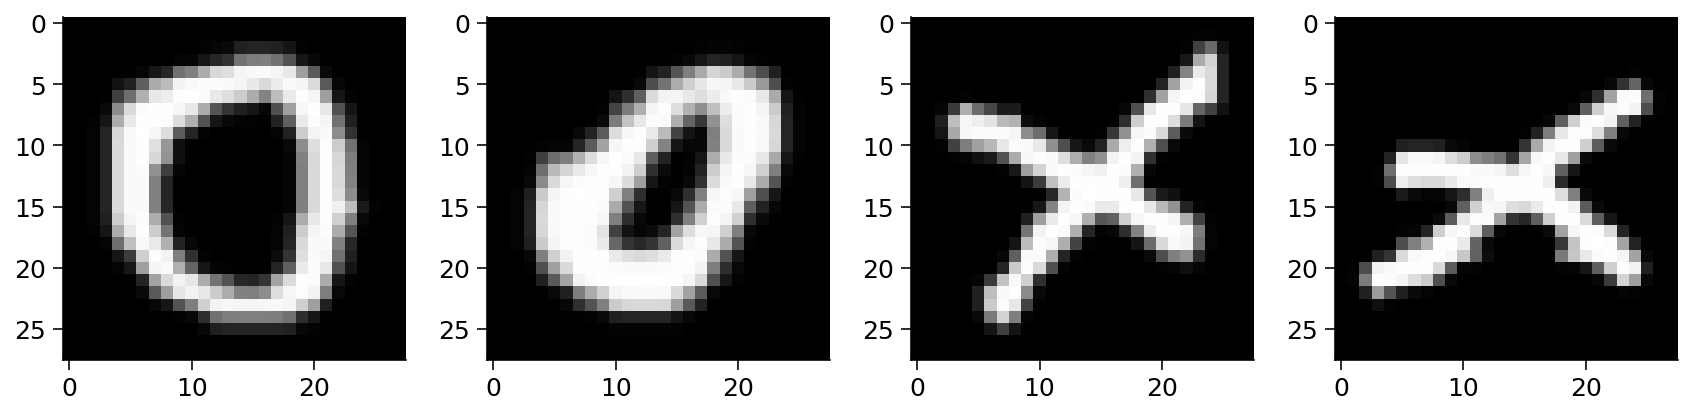

In [40]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))
ax1.imshow(emnist_train[0][0].reshape(28, 28), cmap='gray')
ax2.imshow(emnist_train[10][0].reshape(28, 28), cmap='gray')
ax3.imshow(emnist_train[4][0].reshape(28, 28), cmap='gray')
ax4.imshow(emnist_train[6][0].reshape(28, 28), cmap='gray')
plt.show()

In [41]:
# @markdown ### Visualization of Convolution with Multiple Filters

# @markdown Change the number of input channels (e.g., the color channels of an image or the output channels of a previous layer) and the output channels (number of different filters to apply).

%%html

<style>
    svg {
        #border: 1px solid black;
    }
.matrix {
    font-family: sans-serif;
    transition: all 700ms ease-in-out;
}
.cell rect {
    fill:white;stroke-width:1;stroke:rgb(0,0,0)
}
.padding rect {
    stroke: rgba(0, 0, 0, 0.25);
}
.padding text {
    fill: lightgray;
}
.highlight1 {
    fill:none;stroke-width:4;stroke: rgb(236, 58, 58);stroke-dasharray:10,5;
}
.highlight2 {
    fill:rgba(229, 132, 66, 0.25);stroke-width:5;stroke: rgb(229, 132, 66);
}
.highlight3 {
    fill:rgba(236, 58, 58, 0.25);stroke-width:2;stroke: rgb(236, 58, 58);;
}
.title {
    text-anchor: middle;
}
.button_play {
    display: inline-block;
    background: none;
    border: none;
    position: relative;
    top: -3px;
}
.button_play path {
    fill: darkgray;
}
.button_play:hover path {
    fill: rgb(236, 58, 58);
}
.display_vis_input input:not(:hover)::-webkit-outer-spin-button,
.display_vis_input input:not(:hover)::-webkit-inner-spin-button {
    /* display: none; <- Crashes Chrome on hover */
    -webkit-appearance: none;
    margin: 0; /* <-- Apparently some margin are still there even though it's hidden */
}

.display_vis_input input:not(:hover)[type=number] {
    -moz-appearance:textfield; /* Firefox */
    width: 1ch;
    margin-right: 0px;
    z-index: 0;
}
.display_vis_input input[type=number] {
    width: 4ch;
    border: 0px;
    margin-right: -3ch;
    z-index: 6;
    display: inline-block;
    position: relative;
    padding: 0;
    border-bottom: 2px solid red;
    background: white;
    color: black
}
.display_vis_input .pair {
    display: inline-block;
    white-space:nowrap;
        position: relative;
}
.display_vis_input .pair .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
    display: inline-block;
    overflow: hidden;
    position: relative;
    top: 5px;
}
.pair:not(:hover) .pair_hide {
    max-width: 0;
}
.pairX .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
}

/* Dropdown Button */
.dropbtn {
  border-bottom: 2px solid red;
}

/* The container <div> - needed to position the dropdown content */
.dropdown {
  position: relative;
  display: inline-block;
}

/* Dropdown Content (Hidden by Default) */
.dropdown-content {
  display: none;
  position: absolute;
  background-color: #f1f1f1;
  min-width: 160px;
  box-shadow: 0px 8px 16px 0px rgba(0,0,0,0.2);
  z-index: 1;
}

/* Links inside the dropdown */
.dropdown-content a {
  color: black;
  padding: 5px 2px;
  text-decoration: none;
  display: block;
}

/* Change color of dropdown links on hover */
.dropdown-content a:hover {background-color: #ddd;}

/* Show the dropdown menu on hover */
.dropdown:hover .dropdown-content {display: block;}

</style>
<script src="https://d3js.org/d3.v3.min.js" charset="utf-8" > </script>


<div id="animation_conv_filters" style="background: white">
    <div class="display_vis_input language-python" style="font-family: monospace; color: black; padding: 10px;">
        <!-- default -- >
        import torch<br><br>
        input = torch.rand(1, 1<input class="input_matrixz" type="hidden" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="3">))<br>
        conv = torch.nn.Conv2d(in_channels=1<input class="input_matrixzB" type="hidden" min="1" max="3" value="1">, out_channels=1<input class="input_filterz" type="hidden" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=1<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="hidden" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="hidden" min="1" max="2" value="1">)</span></span>,
        padding=0<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="hidden" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="hidden" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
        -->
        <!-- padding
        import torch<br><br>
        input = torch.rand(1, 1<input class="input_matrixz" type="hidden" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">))<br>
        conv = torch.nn.Conv2d(in_channels=1<input class="input_matrixzB" type="hidden" min="1" max="3" value="1">, out_channels=1<input class="input_filterz" type="hidden" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="3">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="1">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="1"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="1">)</span></span>)<br>
        result = conv(input)
-->
    <!-- filters -->
        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="number" min="1" max="3" value="3">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">)<br>
        conv = torch.nn.Conv2d(in_channels=<input class="input_matrixzB" type="number" min="1" max="3" value="3">, out_channels=<input class="input_filterz" type="number" min="1" max="3" value="2">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="2"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="1">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)

 <!--
        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="hidden" min="1" max="3" value="1">1, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">))<br>
        conv = torch.nn.<div class="dropdown">
  <div class="dropbtn">MaxPool2d</div>
  <div class="dropdown-content">
    <a class="select_maxpool" href="#">MaxPool2d</a>
    <a class="select_avgpool" href="#">AvgPool2d</a>
  </div>
</div>(<input class="input_matrixzB" type="hidden" min="1" max="3" value="1"><input class="input_filterz" type="hidden" min="1" max="3" value="1">kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="2"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="2"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="2">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
-->
    </div>
        <button class="button_play play"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 1.5,0 9.5,5 1.5,10 z"/></svg></button>
    <button class="button_play pause" style="display: none"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 0,0 4,0 4,10, 0,10 z"/><path d="M 6,0 10,0 10,10, 6,10 z"/></svg></button>
    <input type="range" min="1" max="100" value="50" class="slider" style="width: 300px; display: inline-block">
    <button class="button_play left"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,5 4,0 4,10 z"/></svg></button>
    <button class="button_play right"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,0 4,5 0,10 z"/></svg></button>
    <input type="checkbox" class="play_fast">fast play mode
    <br/>
    <svg height="0" width="0">
        <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7"
    refX="0" refY="1.5" orient="auto" fill="rgb(236, 58, 58)">
      <polygon points="0 0, 4 1.5, 0 3" />
    </marker>
  </defs>
    </svg>
    <svg class="image" height="460" width="600">

    </svg>
</div>
<script>
(function() {
var dom_target = document.getElementById("animation_conv_filters")
const divmod = (x, y) => [Math.floor(x / y), x % y];
var svg = d3.select(dom_target).select(".image")

var box_s = 50;
var box_z = 10;
var show_single_elements = true;
var group_func = undefined;
function mulberry32(a) {
    return function() {
      var t = a += 0x6D2B79F5;
      t = Math.imul(t ^ t >>> 15, t | 1);
      t ^= t + Math.imul(t ^ t >>> 7, t | 61);
      return ((t ^ t >>> 14) >>> 0) / 4294967296;
    }
}

function numberGenerator(seed, max, digits) {
    var random = mulberry32(seed)
    return () => parseFloat((random() * max).toFixed(digits));
}
window.numberGenerator = numberGenerator
window.mulberry32 = mulberry32
function generateMatrix2(number, dims) {
    var res = [];
    for (var i = 0; i < dims[0]; i++) {
        if(dims.length == 1)
            res.push(number())
        else
            res.push(generateMatrix2(number, dims.slice(1)));
    }
    return res
}
window.generateMatrix2 = generateMatrix2

function addPadding(matrix, paddingx, paddingy) {
    matrix = JSON.parse(JSON.stringify(matrix));
    var ly = matrix.length; var lx = matrix[0].length;
    for (var i = 0; i < ly; i++) {
        for(var p = 0; p < paddingx; p++) {
            matrix[i].splice(0, 0, 0);
            matrix[i].splice(matrix[i].length, 0, 0);
        }
    }
    for(var p = 0; p < paddingy; p++) {
        matrix.splice(0, 0, []);
        matrix.splice(matrix.length, 0, []);
        for (var i = 0; i < lx + paddingx * 2; i++) {
            matrix[0].push(0);
            matrix[matrix.length - 1].push(0);
        }
    }
    matrix.paddingx = paddingx;
    matrix.paddingy = paddingy;
    return matrix;
}

var stride_x = 1;
var stride_y = 1;
function convolve(matrix, filter) {
    var ress = [];
    for(var zz = 0; zz < filter.length; zz++) {
        var res = [];
        for (var i = 0; i < parseInt((matrix[0].length - filter[0][0].length + stride_y) / stride_y); i++) {
            res.push([]);
            for (var j = 0; j < parseInt((matrix[0][0].length - filter[0][0][0].length + stride_x) / stride_x); j++) {
                var answer = 0;
                var text = "";
                for (var ii = 0; ii < filter[0][0].length; ii++) {
                    for (var jj = 0; jj < filter[0][0][0].length; jj++) {
                        for (var z = 0; z < matrix.length; z++) {
                            answer += matrix[z][i * stride_y + ii][j * stride_x + jj] * filter[zz][z][ii][jj];
                            text +=matrix[z][i * stride_y + ii][j * stride_x + jj] + "*" + filter[zz][z][ii][jj]+"+";
                        }
                    }
                }
                console.log(i, j, text, "=", answer)
                res[res.length - 1].push(answer.toFixed(1))
            }
        }
        ress.push(res)
    }
    return ress;
}
function pool(matrix, filter, func) {
    var res = [];
    for (var i = 0; i < parseInt((matrix.length - filter.length + stride_y) / stride_y); i++) {
        res.push([]);
        for (var j = 0; j < parseInt((matrix[0].length - filter[0].length + stride_x) / stride_x); j++) {
            var answer = [];
            for(var ii = 0; ii < filter.length; ii++) {
                for(var jj = 0; jj < filter[0].length; jj++) {
                    answer.push(matrix[i* stride_y + ii][j* stride_x + jj]);
                }
            }
            if(func == "max")
                res[res.length-1].push(Math.max(...answer))
            else {
                var sum = 0;
                for( var ii = 0; ii < answer.length; ii++)
                    sum += answer[ii]; //don't forget to add the base
                var avg = sum/answer.length;
                res[res.length-1].push(parseFloat(avg.toFixed(1)));
            }

        }
    }
    return res;
}

class Matrix {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`);
        for(var z = 0; z < matrix.length; z++) {
            var gg = this.g.append("g").attr("class", "matrix_layer").attr("transform", `translate(${- z*box_z}, ${+ z*box_z})`);
            for (var j = 0; j < matrix[0].length; j++) {
                for (var i = 0; i < matrix[0][0].length; i++) {
                    var element = gg.append("g").attr("class", "cell").attr("transform", `translate(${i * box_s}, ${j * box_s})`);
                    var rect = element.append("rect")
                        .attr("class", "number")
                        .attr("x", -box_s / 2 + "px")
                        .attr("y", -box_s / 2 + "px")
                        .attr("width", box_s + "px")
                        .attr("height", box_s + "px")
                    if (i < matrix.paddingx || j < matrix.paddingy || i > matrix[0][0].length - matrix.paddingx - 1 || j > matrix[0].length - matrix.paddingy - 1)
                        element.attr("class", "cell padding")
                    element.append("text").text(matrix[z][j][i]).attr("text-anchor", "middle").attr("alignment-baseline", "center").attr("dy", "0.3em")
                }
            }
            gg.append("rect").attr("class", "highlight3")
            gg.append("rect").attr("class", "highlight1")
            gg.append("rect").attr("class", "highlight2")
        }
        //<line x1="0" y1="50" x2="250" y2="50" stroke="#000" stroke-width="8" marker-end="url(#arrowhead)" />
        this.arrow = gg.append("line").attr("transform", `translate(${(-0.5)*box_s}, ${(-0.5+filter.length/2)*box_s})`).attr("marker-end", "url(#arrowhead)").attr("x1", 0).attr("y1", 0).attr("x2", 50).attr("y2", 0)
            .attr("stroke", "#000").attr("stroke-width", 8).attr("stroke", "rgb(236, 58, 58)").style("opacity", 0)


        gg.append("text").attr("class", "title").text(title)
            .attr("x", (matrix[0][0].length/2-0.5)*box_s+"px")
            .attr("y", (matrix[0].length)*box_s+"px")
            .attr("dy", "0em")
        this.highlight2_hidden = true
    }

    setHighlight1(i, j, w, h) {
        if(this.old_i == i && this.old_j == j && this.old_w == w)
            return
        if(i == this.old_i+stride_x || j == this.old_j+stride_y) {
            if (this.old_j == j)
                this.arrow.attr("x1", this.old_i * box_s).attr("y1", j * box_s)
                    .attr("x2", i * box_s - 30).attr("y2", j * box_s).attr("transform", `translate(${(-0.5) * box_s}, ${(-0.5 + h / 2) * box_s})`)
            else
                this.arrow.attr("x1", i * box_s).attr("y1", this.old_j * box_s)
                    .attr("x2", i * box_s).attr("y2", j * box_s - 30).attr("transform", `translate(${(-0.5 + w / 2) * box_s}, ${(-0.5) * box_s})`)
            this.arrow.transition().style("opacity", 1)
                .transition()
                .duration(1000)
                .style("opacity", 0)
        }
        this.old_i = i; this.old_j = j; this.old_w = w;
        this.g.selectAll(".highlight1")
            .style("fill", "rgba(236, 58, 58, 0)")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .style("fill", "rgba(236, 58, 58, 0.25)")
        this.g.selectAll(".highlight3")
            .style("opacity", 1)
            .transition()
            .duration(1000)
            .style("opacity", 0)
        this.g.selectAll(".highlight3")
            .transition()
            .delay(900)
            .duration(0)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
//            .style("opacity", 1)
    }

    setHighlight2(i, j, w, h) {
        if(this.highlight2_hidden == true) {
            this.g.selectAll(".highlight2")
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .transition()
            .duration(1000)
            .style("opacity", 1)
            this.highlight2_hidden = false
            return
        }
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px");
    }
    hideHighlight2() {
        this.highlight2_hidden = true
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .style("opacity", 0)
    }
    //m.g.selectAll(".cell text").style("opacity", (d, i)=>{console.log(i>4); return 1*(i>5)})
}

class Calculation {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-1.5em").attr("dx", "2em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text(i+"·"+j)
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0)
                    .text(" = 12 ")
                }
                else {
                    a = element.append("tspan")
                        .text(" + ")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

class CalculationPool {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-3em").attr("dx", "-2em")
        this.g.append("text").text(group_func+"([").attr("dy", "-1.5em").attr("dx", "-0.5em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text("")
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0).attr("dx", "-0.5em")
                    .text("")
                }
                else {
                    a = element.append("tspan")
                        .text("")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

var matrix, res, m, f, r, c, last_pos, index_max;
function init() {
    show_single_elements = dom_target.querySelector(".play_fast").checked == false
    /*
    tuple_or_single = (x, y) => x == y ? x : `(${x}, ${y})`
    if(group_func == "max")
        dom_target.querySelector(".torch_name").innerText = `torch.nn.MaxPool2d(kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else if(group_func == "mean")
            dom_target.querySelector(".torch_name").innerHTML = `torch.nn.AvgPool2d(x=<input class="input_filterx" type="number" min="2" max="4" value="3">, kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else
        dom_target.querySelector(".torch_name").innerText = `torch.nn.Conv2d(in_channels=1, out_channels=1,  kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`

    if(window.hljs != undefined)
        hljs.highlightElement(dom_target.querySelector(".torch_name"))
    */
    svg.selectAll("*").remove();

    dom_target.querySelector(".input_matrixzB").value = dom_target.querySelector(".input_matrixz").value

    console.log("dom_target", dom_target)
    console.log("dom_target.querySelector(\".input_filterx\").value)", dom_target.querySelector(".input_filterx").value)
    filter = generateMatrix2(numberGenerator(17, 0.9, 1), [parseInt(dom_target.querySelector(".input_filterz").value), parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_filtery").value), parseInt(dom_target.querySelector(".input_filterx").value)]);
    if(dom_target.querySelector(".input_filterx").value == dom_target.querySelector(".input_filtery").value)
        dom_target.querySelector(".input_filterx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_filterx").parentElement.className = "pairX"
    matrix_raw = generateMatrix2(numberGenerator(4, 9, 0), [parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_matrixy").value), parseInt(dom_target.querySelector(".input_matrixx").value)]);

    matrix = JSON.parse(JSON.stringify(matrix_raw));
    for(var z = 0; z < matrix.length; z++)
        matrix[z] = addPadding(matrix_raw[z], parseInt(dom_target.querySelector(".input_paddingx").value), parseInt(dom_target.querySelector(".input_paddingy").value));
    matrix.paddingx = matrix[0].paddingx
    matrix.paddingy = matrix[0].paddingy
    stride_x = parseInt(dom_target.querySelector(".input_stridex").value)
    stride_y = parseInt(dom_target.querySelector(".input_stridey").value)

    if(dom_target.querySelector(".input_stridex").value == dom_target.querySelector(".input_stridey").value)
        dom_target.querySelector(".input_stridex").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_stridex").parentElement.className = "pairX"
        if(dom_target.querySelector(".input_paddingx").value == dom_target.querySelector(".input_paddingy").value)
        dom_target.querySelector(".input_paddingx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_paddingx").parentElement.className = "pairX"

    res = convolve(matrix, filter);
        window.matrix = matrix
        window.filter = filter
        window.res = res
    if(group_func != undefined)
        res = [pool(matrix[0], filter[0][0], group_func)]

    m = new Matrix(1*box_s, (1+filter[0][0].length+1.5)*box_s, matrix, "Matrix");

    f = []
    for(var zz = 0; zz < filter.length; zz++)
        f.push(new Matrix((1+(matrix[0][0].length-filter[zz][0][0].length)/2 + zz*(1+filter[zz][0][0].length))*box_s, 1*box_s, filter[zz], group_func == undefined ? (filter.length != 1? `Filter ${zz}` : `Filter`) : "Pooling"));
    if(group_func != undefined)
        f[0].g.selectAll(".cell text").attr("fill", "white")

    console.log("res", res)
    r = new Matrix((2+(matrix[0][0].length)+1)*box_s, (1+filter[0][0].length+1.5)*box_s, res, "Result");

    var c_x = Math.max((1+(matrix[0][0].length))*box_s, (3+filter.length*(1+(filter[0][0].length)))*box_s)
    console.log("m,ax", (1+(matrix[0][0].length)), filter.length*(1+(filter[0][0].length)))
    if(group_func != undefined)
        c = new CalculationPool(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");
    else
        c = new Calculation(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");

    last_pos = undefined;
    if(show_single_elements)
        index_max = filter.length*res[0].length*res[0][0].length*(filter[0][0].length * filter[0][0][0].length * filter[0].length + 2)
    else
        index_max = filter.length*res[0].length*res[0][0].length
    window.index_max = index_max
    window.filter = filter
    setHighlights(0, 0)
    svg.attr("width", box_s*(matrix[0][0].length+res[0][0].length+4)+(c.g.node().getBoundingClientRect().width)+"px");
    svg.attr("height", box_s*(matrix[0].length+filter[0][0].length+3.0)+"px");
}
init()

function setHighlights(pos_zz, subpos) {
    var [zz, pos] = divmod(pos_zz, res[0].length*res[0][0].length)
    var [i, j] = divmod(pos, res[0][0].length)
    i *= stride_y;
    j *= stride_x;
    var [j2, i2] = divmod(subpos, filter[0][0][0].length * filter[0].length)
    var [i2, z2] = divmod(i2, filter[0].length)
    subpos = Math.floor(subpos/filter[0].length)
    console.log(zz, i, j, j2, i2, z2)
    if(last_pos != pos || 1) {
        var answer = 0;
        for(var ii = 0; ii < filter[0][0].length; ii++) {
            for(var jj = 0; jj < filter[0][0][0].length; jj++) {
                var text = []
                if(filter[0].length == 1) {
                    for(var z = 0; z < filter[0].length; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + " · " + filter[zz][z][ii][jj]);
                    }
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, text.join("+"));
                }
                else {
                    let max_z = (ii == j2 && jj == i2) ? z2+1 : filter[0].length
                    for (var z = 0; z < max_z; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + "·" + filter[zz][z][ii][jj]);
                        console.log(z, z2, text)
                    }
                    console.log("----------")
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, "(" + text.join("+") + ((filter[0].length==max_z)?")":""));
                }
            }
        }
        if(group_func != undefined)
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   ]) = "+res[zz][i/stride_y][j/stride_x])
        else
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   = "+res[zz][i/stride_y][j/stride_x])
        if(last_pos != pos)
            c.hideAll();
        last_pos = pos;
    }
    m.setHighlight1(j, i, filter[0][0][0].length, filter[0][0].length)
    for(var zzz = 0; zzz < filter.length; zzz++) {
        console.log(zzz, zz, zzz == zz)
        if (zzz == zz)
            f[zzz].setHighlight1(0, 0, filter[0][0][0].length, filter[0][0].length)
        else
            f[zzz].setHighlight1(0, 0, 0, 0)
    }
    window.f = f

    r.setHighlight1(j/stride_x, i/stride_y, 1, 1)
    r.g.selectAll(".matrix_layer").attr("opacity", (d,i) => i > zz ? 0.2 : 1 )
    r.g.selectAll(".matrix_layer .highlight1").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    r.g.selectAll(".matrix_layer .highlight3").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    window.r = r

    let matrixpos = (i + j2) * matrix[0][0].length + (j + i2)
    m.g.selectAll(".matrix_layer").each(function(p, j){
        console.log(d3.select(this).select("highlight2"))
        d3.select(this).selectAll(".cell").attr("opacity", (d,i) => (i == matrixpos && j > z2 && subpos < filter[0][0].length * filter[0][0][0].length) ? 0 : 1 );
        d3.select(this).select(".highlight2").style("stroke", (d,i) => (j != z2) ? "transparent" : "rgb(229, 132, 66)");
    })
    f[zz].g.selectAll(".matrix_layer").each(function(p, j){
        console.log(d3.select(this).select("highlight2"), subpos, i2, j2, z2)
        d3.select(this).selectAll(".cell").attr("opacity", (d,i) => (i == subpos && j > z2 && subpos < filter[0][0].length * filter[0][0][0].length) ? 0 : 1 );
        d3.select(this).select(".highlight2").style("stroke", (d,i) => (j != z2) ? "transparent" : "rgb(229, 132, 66)");
        //d3.select(this).select(".highlight1").style("stroke", (d,i) => (j == z2) ? "visible" : "hidden");
        //d3.select(this).select(".highlight3").style("stroke", (d,i) => (j == z2) ? "visible" : "hidden");
    })

    if(subpos < filter[0][0].length * filter[0][0][0].length) {
        m.setHighlight2(j + i2, i + j2, 1, 1)
        if(group_func == undefined)
            for(var zzz = 0; zzz < filter.length; zzz++) {
                if (zzz == zz)
                    f[zzz].setHighlight2(i2, j2, 1, 1)
                else
                    f[zzz].hideHighlight2()
            }
        r.g.selectAll(".cell text").attr("fill", (d, i) => i >= pos_zz ? "white" : "black")
        c.setHighlight1(subpos);
    }
    else {
        m.hideHighlight2()
        for(var zzz = 0; zzz < filter.length; zzz++)
            f[zzz].hideHighlight2()
        r.g.selectAll(".cell text").attr("fill", (d, i) => i > pos_zz ? "white" : "black")
        if(subpos > filter[0][0].length * filter[0][0][0].length) {
            c.hideAll()
        }
        else
            c.setHighlight1(subpos);
    }

    function p(x) { console.log(x); return x}
}
function animate(frame) {
    dom_target.querySelector("input[type=range]").value = index;
    dom_target.querySelector("input[type=range]").max = index_max - 1;
    dom_target.querySelector("input[type=range]").min = 0;
    if(show_single_elements) {
        var [pos, subpos] = divmod(frame, filter[0][0].length * filter[0][0][0].length * filter[0].length + 2)
        setHighlights(pos, subpos);
    }
    else
        setHighlights(frame, filter[0][0].length * filter[0][0][0].length * filter[0].length);
}
var index = -1
animate(0)
var interval = undefined;

function PlayStep() {
    index += 1;
    if(index >= index_max)
        index = 0;
    animate(index);
}

function playPause() {
    if(interval === undefined) {
        dom_target.querySelector(".play").style.display = "none"
        dom_target.querySelector(".pause").style.display = "inline-block"
        interval = window.setInterval(PlayStep, 1000);
        PlayStep();
    }
    else {
        dom_target.querySelector(".play").style.display = "inline-block"
        dom_target.querySelector(".pause").style.display = "none"
        window.clearInterval(interval);
        interval = undefined;
    }
}
dom_target.querySelector("input[type=range]").value = 0;
dom_target.querySelector("input[type=range]").max = index_max;
dom_target.querySelector("input[type=range]").onchange = (i)=>{var v = parseInt(i.target.value); index = v; animate(v);};
dom_target.querySelector(".play").onclick = playPause;
dom_target.querySelector(".pause").onclick = playPause;
dom_target.querySelector(".left").onclick = ()=>{index > 0 ? index -= 1 : index = index_max-1; animate(index);};
dom_target.querySelector(".right").onclick = ()=>{index < index_max-1 ? index += 1 : index = 0; animate(index);};

dom_target.querySelector(".input_filterx").onchange = ()=>{init()}
dom_target.querySelector(".input_filtery").onchange = ()=>{init()}
dom_target.querySelector(".input_filterz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixx").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixy").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixzB").onchange = (i)=>{dom_target.querySelector(".input_matrixz").value = parseInt(i.target.value); init();};
dom_target.querySelector(".input_paddingx").onchange = ()=>{init()}
dom_target.querySelector(".input_paddingy").onchange = ()=>{init()}
dom_target.querySelector(".input_stridex").onchange = ()=>{init()}
dom_target.querySelector(".input_stridey").onchange = ()=>{init()}
dom_target.querySelector(".play_fast").onchange = ()=>{init()}

//dom_target.querySelector(".select_maxpool").onclick = ()=>{group_func="max"; dom_target.querySelector(".dropbtn").innerText = "MaxPool2d"; init()}
//dom_target.querySelector(".select_avgpool").onclick = ()=>{group_func="avg"; dom_target.querySelector(".dropbtn").innerText = "AvgPool2d"; init()}

})();
</script>

## Section 3.1: Multiple Filters

The following network sets up 3 filters and runs them on an image of the dataset from the $X$ class. Note that we are using "thicker" filters than those presented in the videos. Here, the filters are $5 \times 5$, whereas in the videos $3 \times 3$.

In [42]:
class Net2(nn.Module):
  def __init__(self, padding=0):
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # first kernel - leading diagonal
    kernel_1 = torch.Tensor([[[ 1.,  1., -1., -1., -1.],
                              [ 1.,  1.,  1., -1., -1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [-1., -1.,  1.,  1.,  1.],
                              [-1., -1., -1.,  1.,  1.]]])

    # second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1.,  1.,  1.],
                              [-1., -1.,  1.,  1.,  1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [ 1.,  1.,  1., -1., -1.],
                              [ 1.,  1., -1., -1., -1.]]])

    # third kernel - checkerboard pattern
    kernel_3 = torch.Tensor([[[ 1.,  1., -1.,  1.,  1.],
                              [ 1.,  1.,  1.,  1.,  1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [ 1.,  1.,  1.,  1.,  1.],
                              [ 1.,  1., -1.,  1.,  1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)
    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    x = self.conv1(x)
    return x

**Note:** We add a negative bias to give a threshold to select the high output value, which corresponds to the features we want to detect (e.g., 45 degree oriented bar).

Now, let's visualize the filters using the code given below.

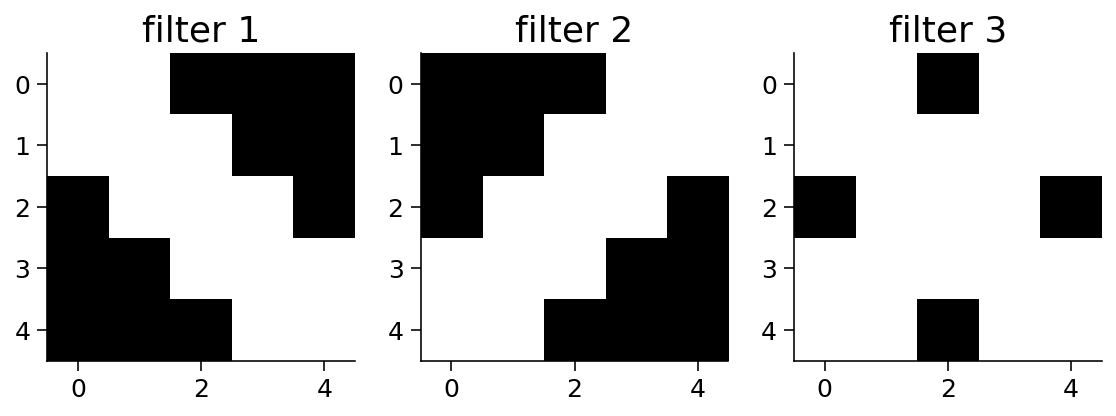

In [43]:
net2 = Net2().to(DEVICE)
fig, (ax11, ax12, ax13) = plt.subplots(1, 3)
# show the filters
ax11.set_title("filter 1")
ax11.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax12.set_title("filter 2")
ax12.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 3")
ax13.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

### Think! 3.1: Do you see how these filters would help recognize an `X`?

In [44]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q5', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [45]:
# to_remove explanation

"""
These filters are tailored to have strong responses to the features of an X and
weaker responses to the features of an O. The diagonal edge filters emphasize
the diagonal edges of the X and the checkerboard pattern reacts strongly to the
center of the X, while the more round edges of the O evoke weaker responses.

So the images which have strong downward (filter 1) and upward diagonals
(filter 3), as well as an intersection of both (filter 2) are probably an X.
"""

'\nThese filters are tailored to have strong responses to the features of an X and\nweaker responses to the features of an O. The diagonal edge filters emphasize\nthe diagonal edges of the X and the checkerboard pattern reacts strongly to the\ncenter of the X, while the more round edges of the O evoke weaker responses.\n\nSo the images which have strong downward (filter 1) and upward diagonals\n(filter 3), as well as an intersection of both (filter 2) are probably an X.\n'

We apply the filters to the images.

In [46]:
net2 = Net2().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x = net2(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o = net2(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

Let us view the image of $X$ and $O$ and what the output of the filters applied to them looks like. Pay special attention to the areas with very high vs. very low output patterns.

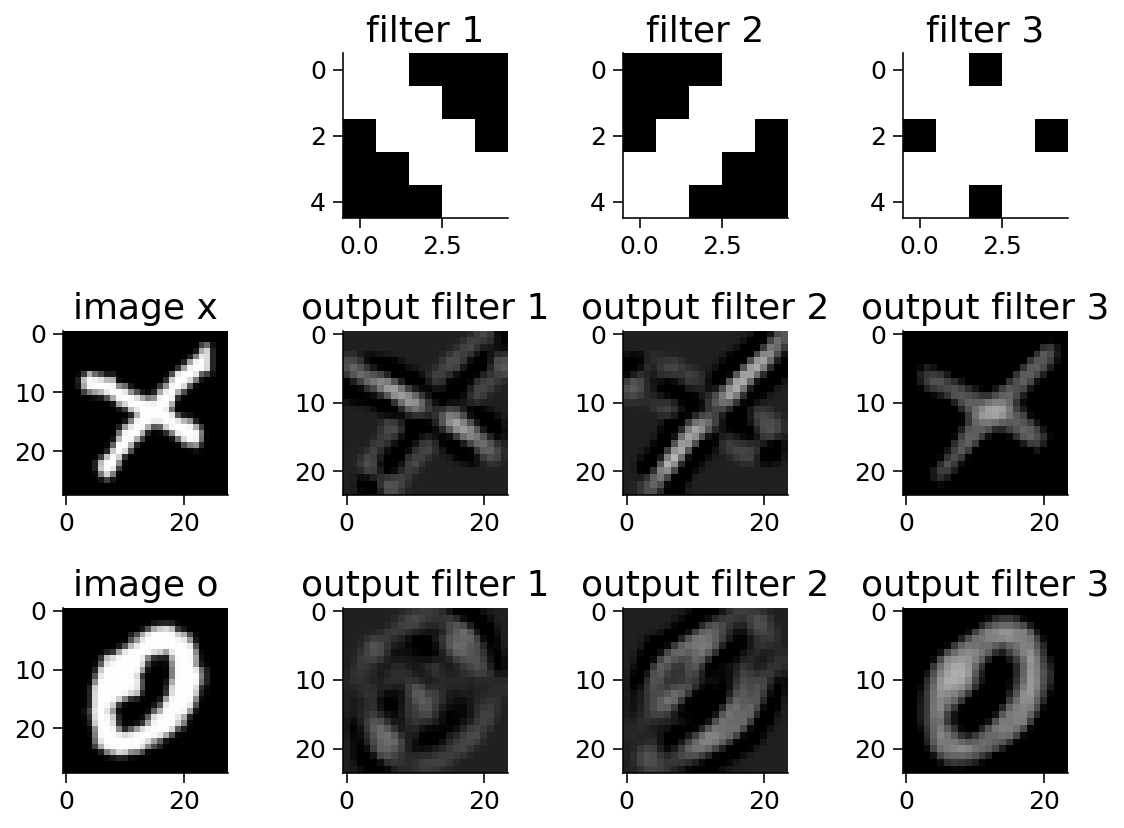

In [47]:
fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4)

# show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

# show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

## Section 3.2: ReLU after convolutions

Up until now we've talked about the convolution operation, which is linear. But the real strength of neural networks comes from the incorporation of non-linear functions.  Furthermore, in the real world, we often have learning problems where the relationship between the input and output is non-linear and complex. 

The ReLU (Rectified Linear Unit) introduces non-linearity into our model, allowing us to learn a more complex function that can better predict the class of an image.

The ReLU function is shown below.

<br>

<figure>
  <center><img src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D1_ConvnetsAndRecurrentNeuralNetworks/static/relu.png width=400px>
  <figcaption>The Rectified Linear Unit (ReLU) Activation Function<figcaption>
  </center>
</figure>

Now let us incorporate ReLU into our previous model and visualize the output.

In [48]:
class Net3(nn.Module):
  def __init__(self, padding=0):
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # first kernel - leading diagonal
    kernel_1 = torch.Tensor([[[ 1.,  1., -1., -1., -1.],
                              [ 1.,  1.,  1., -1., -1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [-1., -1.,  1.,  1.,  1.],
                              [-1., -1., -1.,  1.,  1.]]])

    # second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1.,  1.,  1.],
                              [-1., -1.,  1.,  1.,  1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [ 1.,  1.,  1., -1., -1.],
                              [ 1.,  1., -1., -1., -1.]]])

    # third kernel -checkerboard pattern
    kernel_3 = torch.Tensor([[[ 1.,  1., -1.,  1.,  1.],
                              [ 1.,  1.,  1.,  1.,  1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [ 1.,  1.,  1.,  1.,  1.],
                              [ 1.,  1., -1.,  1.,  1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)
    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    return x

We apply the filters and relus to the images.

In [49]:
net3 = Net3().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_relu = net3(x_img)
output_x_relu = output_x_relu.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_relu = net3(o_img)
output_o_relu = output_o_relu.squeeze(dim=0).detach().cpu().numpy()

Let us view the image of $X$ and $O$ and what the output of the filters applied to them look like.

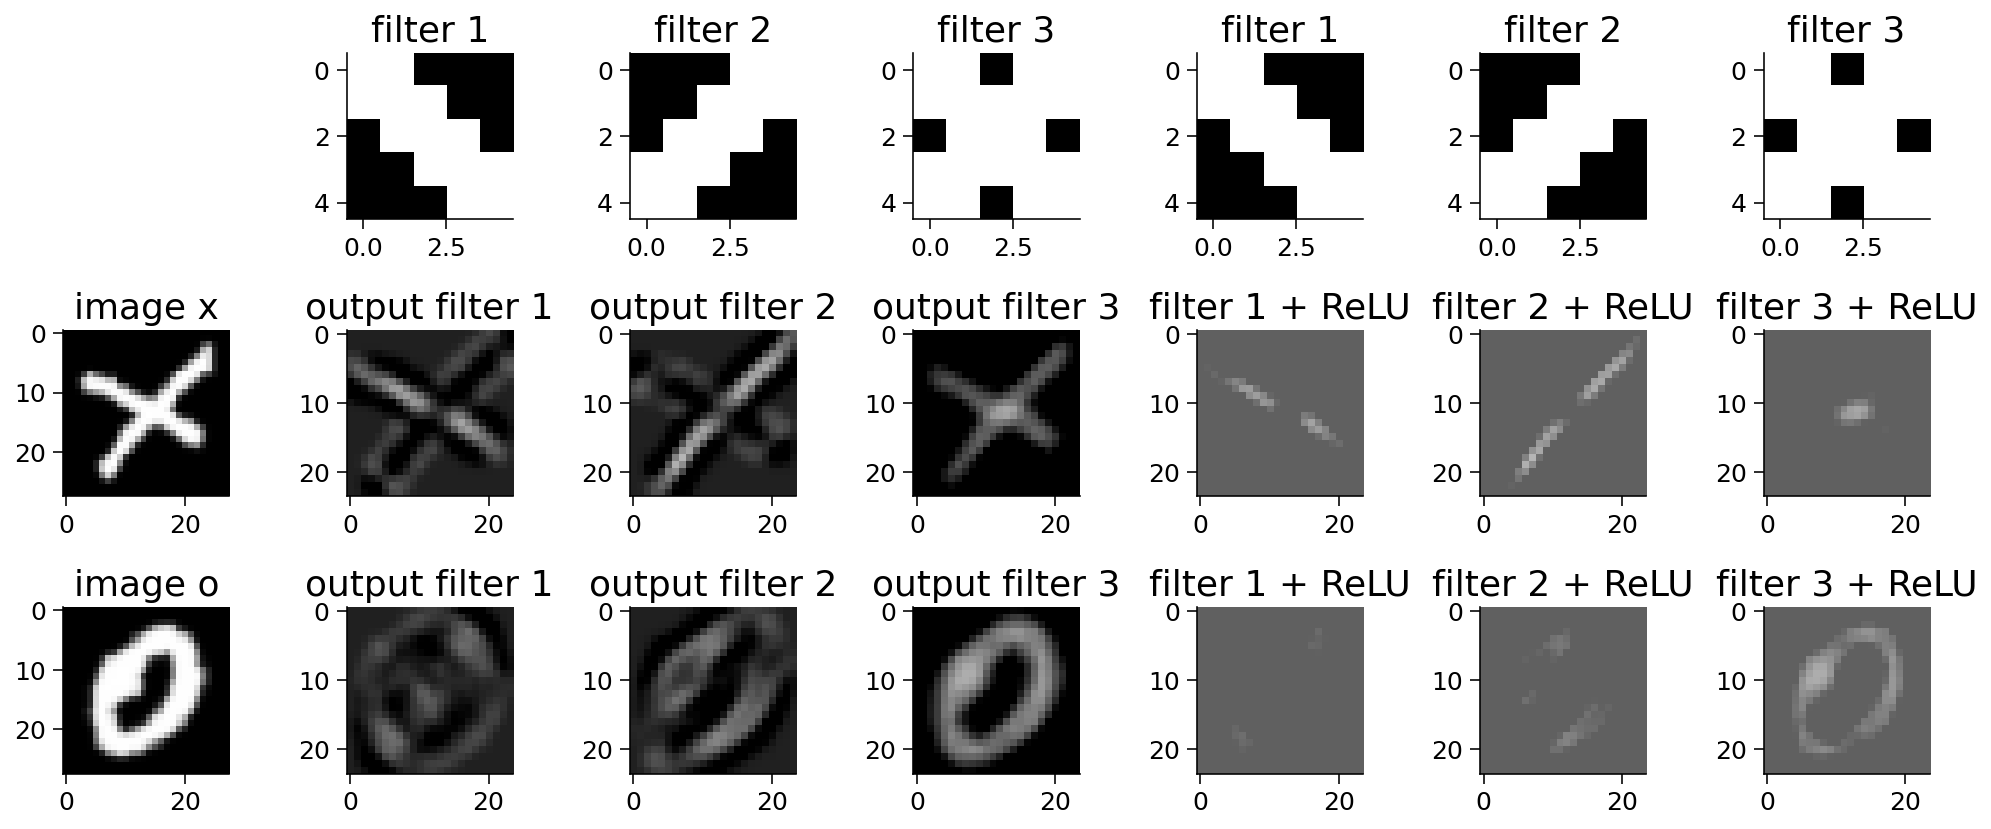

In [50]:
# @markdown *Execute this cell to view the filtered images*
fig, ((ax11, ax12, ax13, ax14, ax15, ax16, ax17),
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27),
      (ax31, ax32, ax33, ax34, ax35, ax36, ax37)) = plt.subplots(3, 4 + 3,
                                                                 figsize=(14, 6))
# show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

ax15.set_title("filter 1")
ax15.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax16.set_title("filter 2")
ax16.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax17.set_title("filter 3")
ax17.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# show x and the filters applied to `x`
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

ax25.set_title("filter 1 + ReLU")
ax25.imshow(output_x_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax26.set_title("filter 2 + ReLU")
ax26.imshow(output_x_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax27.set_title("filter 3 + ReLU")
ax27.imshow(output_x_relu[2], cmap='gray', vmin=vmin, vmax=vmax)

# show o and the filters applied to `o`
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)

ax35.set_title("filter 1 + ReLU")
ax35.imshow(output_o_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax36.set_title("filter 2 + ReLU")
ax36.imshow(output_o_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax37.set_title("filter 3 + ReLU")
ax37.imshow(output_o_relu[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

Discuss with your pod how the ReLU activations help strengthen the features necessary to detect an $X$.

[Here](https://stats.stackexchange.com/a/226927)'s an discussion which talks about how ReLU is useful as an activation funciton. 

[Here](https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks?sfb=2)'s another excellent discussion about the advantages of using ReLU.

## Section 3.3: Pooling

Convolutional layers create feature maps that summarize the presence of particular features (e.g. edges) in the input. However, these feature maps record the _precise_ position of features in the input. That means that small changes to the position of an object in an image can result in a very different feature map. But a cup is a cup (and an $X$ is an $X$) no matter where it appears in the image!  We need to achieve _translational invariance_.

A common approach to this problem is called downsampling. Downsampling creates a lower-resolution version of an image, retaining the large structural elements and removing some of the fine detail that may be less relevant to the task. In CNNs, Max-Pooling and Average-Pooling are used to downsample.  These operations shrink the size of the hidden layers, and produce features that are more translationally invariant, which can be better leveraged by subsequent layers.

Like convolutional layers, pooling layers have fixed-shape windows (pooling windows) that are systematically applied to the input.  As with filters, we can change the shape of the window and the size of the stride.  And, just like with filters, every time we apply a pooling operation we produce a single output. 

Pooling performs a kind of information compression that provides summary statistics for a _neighborhood_ of the input.
- In Maxpooling, we compute the maximum value of all pixels in the pooling window.
- In Avgpooling, we compute the average value of all pixels in the pooling window.

The example below shows the result of Maxpooling within the yellow pooling windows to create the red pooling output matrix.

<figure>
    <center><img src=https://developers.google.com/machine-learning/glossary/images/PoolingConvolution.svg?hl=fr width=400px>
    <figcaption>An Example of Pooling with a kernel size of 2</figcaption>
    </center>
</figure>

Pooling gives our network translational invariance by providing a summary of the values in each pooling window. Thus, A small change in the features of the underlying image won't make a huge difference to the output.

Note that, unlike a convolutional layer, the pooling layer contains no learned parameters! Pooling just computes a pre-determined summary of the input and passes that along.  This is in contrast to the convolutional layer, where there are filters to be learned. 


### Interactive Demo 3.3: The effect of the stride

The following animation depicts how changing the stride changes the output. The stride defines how much the pooling region is moved over the input matrix to produce the next output (red arrows in the animation).  Give it a try! Change the stride and see how it affects the output shape.  You can also try MaxPool or AvgPool.


In [51]:
# @markdown *Run this cell to enable the widget!*

%%html


<style>
    svg {
        #border: 1px solid black;
    }
.matrix {
    font-family: sans-serif;
    transition: all 700ms ease-in-out;
}
.cell rect {
    fill:white;stroke-width:1;stroke:rgb(0,0,0)
}
.padding rect {
    stroke: rgba(0, 0, 0, 0.25);
}
.padding text {
    fill: lightgray;
}
.highlight1 {
    fill:none;stroke-width:4;stroke: rgb(236, 58, 58);stroke-dasharray:10,5;
}
.highlight2 {
    fill:rgba(229, 132, 66, 0.25);stroke-width:5;stroke: rgb(229, 132, 66);
}
.highlight3 {
    fill:rgba(236, 58, 58, 0.25);stroke-width:2;stroke: rgb(236, 58, 58);;
}
.title {
    text-anchor: middle;
}
.button_play {
    display: inline-block;
    background: none;
    border: none;
    position: relative;
    top: -3px;
}
.button_play path {
    fill: darkgray;
}
.button_play:hover path {
    fill: rgb(236, 58, 58);
}
.display_vis_input input:not(:hover)::-webkit-outer-spin-button,
.display_vis_input input:not(:hover)::-webkit-inner-spin-button {
    /* display: none; <- Crashes Chrome on hover */
    -webkit-appearance: none;
    margin: 0; /* <-- Apparently some margin are still there even though it's hidden */
}

.display_vis_input input:not(:hover)[type=number] {
    -moz-appearance:textfield; /* Firefox */
    width: 1ch;
    margin-right: 0px;
    z-index: 0;
}
.display_vis_input input[type=number] {
    width: 4ch;
    border: 0px;
    margin-right: -3ch;
    z-index: 6;
    display: inline-block;
    position: relative;
    padding: 0;
    border-bottom: 2px solid red;
    background: white;
    color: black
}
.display_vis_input .pair {
    display: inline-block;
    white-space:nowrap;
        position: relative;
}
.display_vis_input .pair .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
    display: inline-block;
    overflow: hidden;
    position: relative;
    top: 5px;
}
.pair:not(:hover) .pair_hide {
    max-width: 0;
}
.pairX .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
}

/* Dropdown Button */
.dropbtn {
  border-bottom: 2px solid red;
}

/* The container <div> - needed to position the dropdown content */
.dropdown {
  position: relative;
  display: inline-block;
}

/* Dropdown Content (Hidden by Default) */
.dropdown-content {
  display: none;
  position: absolute;
  background-color: #f1f1f1;
  min-width: 160px;
  box-shadow: 0px 8px 16px 0px rgba(0,0,0,0.2);
  z-index: 1;
}

/* Links inside the dropdown */
.dropdown-content a {
  color: black;
  padding: 5px 2px;
  text-decoration: none;
  display: block;
}

/* Change color of dropdown links on hover */
.dropdown-content a:hover {background-color: #ddd;}

/* Show the dropdown menu on hover */
.dropdown:hover .dropdown-content {display: block;}

</style>
<script src="https://d3js.org/d3.v3.min.js" charset="utf-8" > </script>


<div id="animation_conv_pool" style="background: white">
    <div class="display_vis_input language-python" style="font-family: monospace; color: black; padding: 10px;">
        <!--
        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="number" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="3">))<br>
        conv = torch.nn.Conv2d(in_channels=<input class="input_matrixzB" type="number" min="1" max="3" value="1">, out_channels=<input class="input_filterz" type="number" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="1">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
        -->

        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="hidden" min="1" max="3" value="1">1, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">)<br>
        conv = torch.nn.<div class="dropdown">
  <div class="dropbtn">MaxPool2d</div>
  <div class="dropdown-content">
    <a class="select_maxpool">MaxPool2d</a>
    <a class="select_avgpool">AvgPool2d</a>
  </div>
</div>(<input class="input_matrixzB" type="hidden" min="1" max="3" value="1"><input class="input_filterz" type="hidden" min="1" max="3" value="1">kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="2"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="2"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="2">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)

    </div>
        <button class="button_play play"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 1.5,0 9.5,5 1.5,10 z"/></svg></button>
    <button class="button_play pause" style="display: none"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 0,0 4,0 4,10, 0,10 z"/><path d="M 6,0 10,0 10,10, 6,10 z"/></svg></button>
    <input type="range" min="1" max="100" value="50" class="slider" style="width: 300px; display: inline-block">
    <button class="button_play left"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,5 4,0 4,10 z"/></svg></button>
    <button class="button_play right"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,0 4,5 0,10 z"/></svg></button>
    <input type="checkbox" class="play_fast">fast play mode
    <br/>
    <svg height="0" width="0">
        <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7"
    refX="0" refY="1.5" orient="auto" fill="rgb(236, 58, 58)">
      <polygon points="0 0, 4 1.5, 0 3" />
    </marker>
  </defs>
    </svg>
    <svg class="image" height="460" width="600">

    </svg>
</div>
<script>
(function() {
var dom_target = document.getElementById("animation_conv_pool")
const divmod = (x, y) => [Math.floor(x / y), x % y];
var svg = d3.select(dom_target).select(".image")

var box_s = 50;
var box_z = 10;
var show_single_elements = true;
var group_func = "max";
function mulberry32(a) {
    return function() {
      var t = a += 0x6D2B79F5;
      t = Math.imul(t ^ t >>> 15, t | 1);
      t ^= t + Math.imul(t ^ t >>> 7, t | 61);
      return ((t ^ t >>> 14) >>> 0) / 4294967296;
    }
}

function numberGenerator(seed, max, digits) {
    var random = mulberry32(seed)
    return () => parseFloat((random() * max).toFixed(digits));
}
window.numberGenerator = numberGenerator
window.mulberry32 = mulberry32
function generateMatrix2(number, dims) {
    var res = [];
    for (var i = 0; i < dims[0]; i++) {
        if(dims.length == 1)
            res.push(number())
        else
            res.push(generateMatrix2(number, dims.slice(1)));
    }
    return res
}
window.generateMatrix2 = generateMatrix2

function addPadding(matrix, paddingx, paddingy) {
    matrix = JSON.parse(JSON.stringify(matrix));
    var ly = matrix.length; var lx = matrix[0].length;
    for (var i = 0; i < ly; i++) {
        for(var p = 0; p < paddingx; p++) {
            matrix[i].splice(0, 0, 0);
            matrix[i].splice(matrix[i].length, 0, 0);
        }
    }
    for(var p = 0; p < paddingy; p++) {
        matrix.splice(0, 0, []);
        matrix.splice(matrix.length, 0, []);
        for (var i = 0; i < lx + paddingx * 2; i++) {
            matrix[0].push(0);
            matrix[matrix.length - 1].push(0);
        }
    }
    matrix.paddingx = paddingx;
    matrix.paddingy = paddingy;
    return matrix;
}

var stride_x = 1;
var stride_y = 1;
function convolve(matrix, filter) {
    var ress = [];
    for(var zz = 0; zz < filter.length; zz++) {
        var res = [];
        for (var i = 0; i < parseInt((matrix[0].length - filter[0][0].length + stride_y) / stride_y); i++) {
            res.push([]);
            for (var j = 0; j < parseInt((matrix[0][0].length - filter[0][0][0].length + stride_x) / stride_x); j++) {
                var answer = 0;
                var text = "";
                for (var ii = 0; ii < filter[0][0].length; ii++) {
                    for (var jj = 0; jj < filter[0][0][0].length; jj++) {
                        for (var z = 0; z < matrix.length; z++) {
                            answer += matrix[z][i * stride_y + ii][j * stride_x + jj] * filter[zz][z][ii][jj];
                            text +=matrix[z][i * stride_y + ii][j * stride_x + jj] + "*" + filter[zz][z][ii][jj]+"+";
                        }
                    }
                }
                console.log(i, j, text, "=", answer)
                res[res.length - 1].push(answer.toFixed(1))
            }
        }
        ress.push(res)
    }
    return ress;
}
function pool(matrix, filter, func) {
    var res = [];
    for (var i = 0; i < parseInt((matrix.length - filter.length + stride_y) / stride_y); i++) {
        res.push([]);
        for (var j = 0; j < parseInt((matrix[0].length - filter[0].length + stride_x) / stride_x); j++) {
            var answer = [];
            for(var ii = 0; ii < filter.length; ii++) {
                for(var jj = 0; jj < filter[0].length; jj++) {
                    answer.push(matrix[i* stride_y + ii][j* stride_x + jj]);
                }
            }
            if(func == "max")
                res[res.length-1].push(Math.max(...answer))
            else {
                var sum = 0;
                for( var ii = 0; ii < answer.length; ii++)
                    sum += answer[ii]; //don't forget to add the base
                var avg = sum/answer.length;
                res[res.length-1].push(parseFloat(avg.toFixed(1)));
            }

        }
    }
    return res;
}

class Matrix {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`);
        for(var z = 0; z < matrix.length; z++) {
            var gg = this.g.append("g").attr("class", "matrix_layer").attr("transform", `translate(${- z*box_z}, ${+ z*box_z})`);
            for (var j = 0; j < matrix[0].length; j++) {
                for (var i = 0; i < matrix[0][0].length; i++) {
                    var element = gg.append("g").attr("class", "cell").attr("transform", `translate(${i * box_s}, ${j * box_s})`);
                    var rect = element.append("rect")
                        .attr("class", "number")
                        .attr("x", -box_s / 2 + "px")
                        .attr("y", -box_s / 2 + "px")
                        .attr("width", box_s + "px")
                        .attr("height", box_s + "px")
                    if (i < matrix.paddingx || j < matrix.paddingy || i > matrix[0][0].length - matrix.paddingx - 1 || j > matrix[0].length - matrix.paddingy - 1)
                        element.attr("class", "cell padding")
                    element.append("text").text(matrix[z][j][i]).attr("text-anchor", "middle").attr("alignment-baseline", "center").attr("dy", "0.3em")
                }
            }
            gg.append("rect").attr("class", "highlight3")
            gg.append("rect").attr("class", "highlight1")
            gg.append("rect").attr("class", "highlight2")
        }
        //<line x1="0" y1="50" x2="250" y2="50" stroke="#000" stroke-width="8" marker-end="url(#arrowhead)" />
        this.arrow = gg.append("line").attr("transform", `translate(${(-0.5)*box_s}, ${(-0.5+filter.length/2)*box_s})`).attr("marker-end", "url(#arrowhead)").attr("x1", 0).attr("y1", 0).attr("x2", 50).attr("y2", 0)
            .attr("stroke", "#000").attr("stroke-width", 8).attr("stroke", "rgb(236, 58, 58)").style("opacity", 0)


        gg.append("text").attr("class", "title").text(title)
            .attr("x", (matrix[0][0].length/2-0.5)*box_s+"px")
            .attr("y", (matrix[0].length)*box_s+"px")
            .attr("dy", "0em")
        this.highlight2_hidden = true
    }

    setHighlight1(i, j, w, h) {
        if(this.old_i == i && this.old_j == j && this.old_w == w)
            return
        if(i == this.old_i+stride_x || j == this.old_j+stride_y) {
            if (this.old_j == j)
                this.arrow.attr("x1", this.old_i * box_s).attr("y1", j * box_s)
                    .attr("x2", i * box_s - 30).attr("y2", j * box_s).attr("transform", `translate(${(-0.5) * box_s}, ${(-0.5 + h / 2) * box_s})`)
            else
                this.arrow.attr("x1", i * box_s).attr("y1", this.old_j * box_s)
                    .attr("x2", i * box_s).attr("y2", j * box_s - 30).attr("transform", `translate(${(-0.5 + w / 2) * box_s}, ${(-0.5) * box_s})`)
            this.arrow.transition().style("opacity", 1)
                .transition()
                .duration(1000)
                .style("opacity", 0)
        }
        this.old_i = i; this.old_j = j; this.old_w = w;
        this.g.selectAll(".highlight1")
            .style("fill", "rgba(236, 58, 58, 0)")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .style("fill", "rgba(236, 58, 58, 0.25)")
        this.g.selectAll(".highlight3")
            .style("opacity", 1)
            .transition()
            .duration(1000)
            .style("opacity", 0)
        this.g.selectAll(".highlight3")
            .transition()
            .delay(900)
            .duration(0)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
//            .style("opacity", 1)
    }

    setHighlight2(i, j, w, h) {
        if(this.highlight2_hidden == true) {
            this.g.selectAll(".highlight2")
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .transition()
            .duration(1000)
            .style("opacity", 1)
            this.highlight2_hidden = false
            return
        }
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px");
    }
    hideHighlight2() {
        this.highlight2_hidden = true
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .style("opacity", 0)
    }
    //m.g.selectAll(".cell text").style("opacity", (d, i)=>{console.log(i>4); return 1*(i>5)})
}

class Calculation {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-1.5em").attr("dx", "2em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text(i+"·"+j)
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0)
                    .text(" = 12 ")
                }
                else {
                    a = element.append("tspan")
                        .text(" + ")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

class CalculationPool {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-3em").attr("dx", "-2em")
        this.g.append("text").text(group_func+"([").attr("dy", "-1.5em").attr("dx", "-0.5em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text("")
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0).attr("dx", "-0.5em")
                    .text("")
                }
                else {
                    a = element.append("tspan")
                        .text("")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

var matrix, res, m, f, r, c, last_pos, index_max;
function init() {
    show_single_elements = dom_target.querySelector(".play_fast").checked == false
    /*
    tuple_or_single = (x, y) => x == y ? x : `(${x}, ${y})`
    if(group_func == "max")
        dom_target.querySelector(".torch_name").innerText = `torch.nn.MaxPool2d(kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else if(group_func == "mean")
            dom_target.querySelector(".torch_name").innerHTML = `torch.nn.AvgPool2d(x=<input class="input_filterx" type="number" min="2" max="4" value="3">, kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else
        dom_target.querySelector(".torch_name").innerText = `torch.nn.Conv2d(in_channels=1, out_channels=1,  kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`

    if(window.hljs != undefined)
        hljs.highlightElement(dom_target.querySelector(".torch_name"))
    */
    svg.selectAll("*").remove();

    dom_target.querySelector(".input_matrixzB").value = dom_target.querySelector(".input_matrixz").value

    console.log("dom_target", dom_target)
    console.log("dom_target.querySelector(\".input_filterx\").value)", dom_target.querySelector(".input_filterx").value)
    filter = generateMatrix2(numberGenerator(17, 0.9, 1), [parseInt(dom_target.querySelector(".input_filterz").value), parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_filtery").value), parseInt(dom_target.querySelector(".input_filterx").value)]);
    if(dom_target.querySelector(".input_filterx").value == dom_target.querySelector(".input_filtery").value)
        dom_target.querySelector(".input_filterx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_filterx").parentElement.className = "pairX"
    matrix_raw = generateMatrix2(numberGenerator(4, 9, 0), [parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_matrixy").value), parseInt(dom_target.querySelector(".input_matrixx").value)]);

    matrix = JSON.parse(JSON.stringify(matrix_raw));
    for(var z = 0; z < matrix.length; z++)
        matrix[z] = addPadding(matrix_raw[z], parseInt(dom_target.querySelector(".input_paddingx").value), parseInt(dom_target.querySelector(".input_paddingy").value));
    matrix.paddingx = matrix[0].paddingx
    matrix.paddingy = matrix[0].paddingy
    stride_x = parseInt(dom_target.querySelector(".input_stridex").value)
    stride_y = parseInt(dom_target.querySelector(".input_stridey").value)

    if(dom_target.querySelector(".input_stridex").value == dom_target.querySelector(".input_stridey").value)
        dom_target.querySelector(".input_stridex").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_stridex").parentElement.className = "pairX"
        if(dom_target.querySelector(".input_paddingx").value == dom_target.querySelector(".input_paddingy").value)
        dom_target.querySelector(".input_paddingx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_paddingx").parentElement.className = "pairX"

    res = convolve(matrix, filter);
        window.matrix = matrix
        window.filter = filter
        window.res = res
    if(group_func != undefined)
        res = [pool(matrix[0], filter[0][0], group_func)]

    m = new Matrix(1*box_s, (1+filter[0][0].length+1.5)*box_s, matrix, "Matrix");

    f = []
    for(var zz = 0; zz < filter.length; zz++)
        f.push(new Matrix((1+(matrix[0][0].length-filter[zz][0][0].length)/2 + zz*(1+filter[zz][0][0].length))*box_s, 1*box_s, filter[zz], group_func == undefined ? `Filter ${zz}` : "Pooling"));
    if(group_func != undefined)
        f[0].g.selectAll(".cell text").attr("fill", "white")

    console.log("res", res)
    r = new Matrix((2+(matrix[0][0].length)+1)*box_s, (1+filter[0][0].length+1.5)*box_s, res, "Result");

    var c_x = Math.max((1+(matrix[0][0].length))*box_s, (3+filter.length*(1+(filter[0][0].length)))*box_s)
    console.log("m,ax", (1+(matrix[0][0].length)), filter.length*(1+(filter[0][0].length)))
    if(group_func != undefined)
        c = new CalculationPool(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");
    else
        c = new Calculation(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");

    last_pos = undefined;
    if(show_single_elements)
        index_max = filter.length*res[0].length*res[0][0].length*(filter[0][0].length * filter[0][0][0].length + 2)
    else
        index_max = filter.length*res[0].length*res[0][0].length
    window.index_max = index_max
    window.filter = filter
    setHighlights(0, 0)
    svg.attr("width", box_s*(matrix[0][0].length+res[0][0].length+4)+(c.g.node().getBoundingClientRect().width)+"px");
    svg.attr("height", box_s*(matrix[0].length+filter[0][0].length+3.0)+"px");
}
init()

function setHighlights(pos_zz, subpos) {
    var [zz, pos] = divmod(pos_zz, res[0].length*res[0][0].length)
    var [i, j] = divmod(pos, res[0][0].length)
    i *= stride_y;
    j *= stride_x;
    var [j2, i2] = divmod(subpos, filter[0][0][0].length)
    if(last_pos != pos) {
        var answer = 0;
        for(var ii = 0; ii < filter[0][0].length; ii++) {
            for(var jj = 0; jj < filter[0][0][0].length; jj++) {
                var text = []
                if(filter[0].length == 1) {
                    for(var z = 0; z < filter[0].length; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + " · " + filter[zz][z][ii][jj]);
                    }
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, text.join("+"));
                }
                else {
                    for (var z = 0; z < filter[0].length; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + "·" + filter[zz][z][ii][jj]);
                    }
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, "(" + text.join("+") + ")");
                }
            }
        }
        if(group_func != undefined)
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   ]) = "+res[zz][i/stride_y][j/stride_x])
        else
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   = "+res[zz][i/stride_y][j/stride_x])
        c.hideAll();
        last_pos = pos;
    }
    m.setHighlight1(j, i, filter[0][0][0].length, filter[0][0].length)
    for(var zzz = 0; zzz < filter.length; zzz++) {
        console.log(zzz, zz, zzz == zz)
        if (zzz == zz)
            f[zzz].setHighlight1(0, 0, filter[0][0][0].length, filter[0][0].length)
        else
            f[zzz].setHighlight1(0, 0, 0, 0)
    }
    window.f = f

    r.setHighlight1(j/stride_x, i/stride_y, 1, 1)
    r.g.selectAll(".matrix_layer").attr("opacity", (d,i) => i > zz ? 0.2 : 1 )
    r.g.selectAll(".matrix_layer .highlight1").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    r.g.selectAll(".matrix_layer .highlight3").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    window.r = r

    if(subpos < filter[0][0].length * filter[0][0][0].length) {
        m.setHighlight2(j + i2, i + j2, 1, 1)
        if(group_func == undefined)
            for(var zzz = 0; zzz < filter.length; zzz++) {
                if (zzz == zz)
                    f[zzz].setHighlight2(i2, j2, 1, 1)
                else
                    f[zzz].hideHighlight2()
            }
        r.g.selectAll(".cell text").attr("fill", (d, i) => i >= pos_zz ? "white" : "black")
        c.setHighlight1(subpos);
    }
    else {
        m.hideHighlight2()
        for(var zzz = 0; zzz < filter.length; zzz++)
            f[zzz].hideHighlight2()
        r.g.selectAll(".cell text").attr("fill", (d, i) => i > pos_zz ? "white" : "black")
        if(subpos > filter[0][0].length * filter[0][0][0].length) {
            c.hideAll()
        }
        else
            c.setHighlight1(subpos);
    }

    function p(x) { console.log(x); return x}
}
function animate(frame) {
    dom_target.querySelector("input[type=range]").value = index;
    dom_target.querySelector("input[type=range]").max = index_max - 1;
    dom_target.querySelector("input[type=range]").min = 0;
    if(show_single_elements) {
        var [pos, subpos] = divmod(frame, filter[0][0].length * filter[0][0][0].length + 2)
        setHighlights(pos, subpos);
    }
    else
        setHighlights(frame, filter[0][0].length * filter[0][0][0].length);
}
var index = -1
animate(0)
var interval = undefined;

function PlayStep() {
    index += 1;
    if(index >= index_max)
        index = 0;
    animate(index);
}

function playPause() {
    if(interval === undefined) {
        dom_target.querySelector(".play").style.display = "none"
        dom_target.querySelector(".pause").style.display = "inline-block"
        interval = window.setInterval(PlayStep, 1000);
        PlayStep();
    }
    else {
        dom_target.querySelector(".play").style.display = "inline-block"
        dom_target.querySelector(".pause").style.display = "none"
        window.clearInterval(interval);
        interval = undefined;
    }
}
dom_target.querySelector("input[type=range]").value = 0;
dom_target.querySelector("input[type=range]").max = index_max;
dom_target.querySelector("input[type=range]").onchange = (i)=>{var v = parseInt(i.target.value); index = v; animate(v);};
dom_target.querySelector(".play").onclick = playPause;
dom_target.querySelector(".pause").onclick = playPause;
dom_target.querySelector(".left").onclick = ()=>{index > 0 ? index -= 1 : index = index_max-1; animate(index);};
dom_target.querySelector(".right").onclick = ()=>{index < index_max-1 ? index += 1 : index = 0; animate(index);};

dom_target.querySelector(".input_filterx").onchange = ()=>{init()}
dom_target.querySelector(".input_filtery").onchange = ()=>{init()}
dom_target.querySelector(".input_filterz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixx").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixy").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixzB").onchange = (i)=>{dom_target.querySelector(".input_matrixz").value = parseInt(i.target.value); init();};
dom_target.querySelector(".input_paddingx").onchange = ()=>{init()}
dom_target.querySelector(".input_paddingy").onchange = ()=>{init()}
dom_target.querySelector(".input_stridex").onchange = ()=>{init()}
dom_target.querySelector(".input_stridey").onchange = ()=>{init()}
dom_target.querySelector(".play_fast").onchange = ()=>{init()}
dom_target.querySelector(".select_maxpool").onclick = ()=>{group_func="max"; dom_target.querySelector(".dropbtn").innerText = "MaxPool2d"; init()}
dom_target.querySelector(".select_avgpool").onclick = ()=>{group_func="avg"; dom_target.querySelector(".dropbtn").innerText = "AvgPool2d"; init()}

})();
</script>

### Coding Exercise 3.3: Implement MaxPooling 

Let us now implement MaxPooling in PyTorch and observe the effects of Pooling on the dimension of the input image. Use a kernel of size 2 and stride of 2 for the MaxPooling layer.

In [52]:
class Net4(nn.Module):
  def __init__(self, padding=0, stride=2):
    super(Net4, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                            padding=padding)

    # first kernel - leading diagonal
    kernel_1 = torch.Tensor([[[ 1.,  1., -1., -1., -1.],
                              [ 1.,  1.,  1., -1., -1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [-1., -1.,  1.,  1.,  1.],
                              [-1., -1., -1.,  1.,  1.]]])

    # second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1.,  1.,  1.],
                              [-1., -1.,  1.,  1.,  1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [ 1.,  1.,  1., -1., -1.],
                              [ 1.,  1., -1., -1., -1.]]])

    # third kernel -checkerboard pattern
    kernel_3 = torch.Tensor([[[ 1.,  1., -1.,  1.,  1.],
                              [ 1.,  1.,  1.,  1.,  1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [ 1.,  1.,  1.,  1.,  1.],
                              [ 1.,  1., -1.,  1.,  1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)
    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    self.pool = nn.MaxPool2d(kernel_size=..., stride=...)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    x = ...  # pass through a max pool layer
    return x


# add event to airtable
atform.add_event('Coding Exercise 3.3: Implement MaxPooling')

## check if your implementation is correct
# net4 = Net4().to(DEVICE)
# check_pooling_net(net4, device=DEVICE)

In [53]:
# to_remove solution
class Net4(nn.Module):
  def __init__(self, padding=0, stride=2):
    super(Net4, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                            padding=padding)

    # first kernel - leading diagonal
    kernel_1 = torch.Tensor([[[ 1.,  1., -1., -1., -1.],
                              [ 1.,  1.,  1., -1., -1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [-1., -1.,  1.,  1.,  1.],
                              [-1., -1., -1.,  1.,  1.]]])

    # second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1.,  1.,  1.],
                              [-1., -1.,  1.,  1.,  1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [ 1.,  1.,  1., -1., -1.],
                              [ 1.,  1., -1., -1., -1.]]])

    # third kernel -checkerboard pattern
    kernel_3 = torch.Tensor([[[ 1.,  1., -1.,  1.,  1.],
                              [ 1.,  1.,  1.,  1.,  1.],
                              [-1.,  1.,  1.,  1., -1.],
                              [ 1.,  1.,  1.,  1.,  1.],
                              [ 1.,  1., -1.,  1.,  1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)
    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))
    self.pool = nn.MaxPool2d(kernel_size=2, stride=stride)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)  # pass through a max pool layer
    return x


# add event to airtable
atform.add_event('Coding Exercise 3.3: Implement MaxPooling')

## check if your implementation is correct
net4 = Net4().to(DEVICE)
check_pooling_net(net4, device=DEVICE)

✅ Your network produced the correct output.


```
✅ Your network produced the correct output.
```

In [54]:
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_pool = net4(x_img)
output_x_pool = output_x_pool.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_pool = net4(o_img)
output_o_pool = output_o_pool.squeeze(dim=0).detach().cpu().numpy()

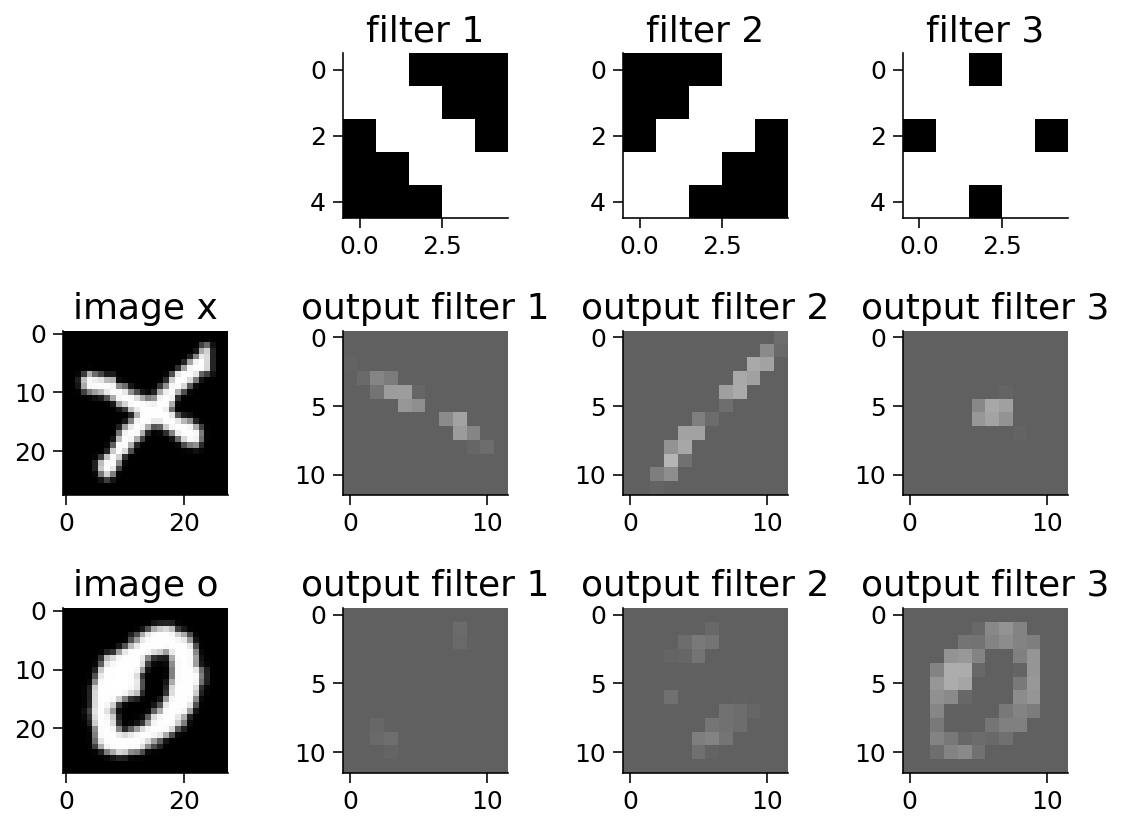

In [55]:
# @markdown *Run the cell to plot the outputs!*

fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4)
# show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net4.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net4.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net4.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x_pool[2], cmap='gray', vmin=vmin, vmax=vmax)

# show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o_pool[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

You should observe the size of the output as being half of what you saw after the ReLU section, which is due to the Maxpool layer. 

Despite the reduction in the size of the output, the important or high-level features in the output still remains intact.

---
# Section 4: Putting it all together

*Time estimate: ~33mins*

In [56]:
# @title Video 5: Putting it all together
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Fy4y1j7dU", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"-TJixd9fRCw", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 5: Putting it all together')

display(out)

## Section 4.1: Number of Parameters in Convolutional vs. Fully-connected Models
Convolutional networks encourage weight-sharing by learning a single kernel that is repeated over the entire input image. In general, this kernel is just a few parameters, compared to the huge number of parameters in a dense network. 

Let's use the animation below to calculate few-layer network parameters for image data of shape $32\times32$ using both convolutional layers and dense layers. The `Num_Dense` in this exercise is the number of dense layers we use in the network, with each dense layer having the same input and output dimensions. `Num_Convs` is the number of convolutional blocks in the network, with each block containing a single kernel. The kernel size is the length and width of this kernel.

**Note:** you must run the cell before you can use the sliders.

<br>
<center>
  <img src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D1_ConvnetsAndRecurrentNeuralNetworks/static/img_params.png>
  <figcaption> Parameter comparison</figcaption>
</center>


### Interactive Demo 4.1: Number of Parameters

In [57]:
# @markdown *Run this cell to enable the widget*
import io, base64
from ipywidgets import interact, interactive, fixed, interact_manual



def do_plot(image_size, batch_size, number_of_Linear, number_of_Conv2d,
            kernel_size, pooling, Final_Layer):

  sample_image = torch.rand(batch_size, 1, image_size, image_size)
  linear_layer = []
  linear_nets = []
  code_dense = ""

  code_dense += f"model_dense = nn.Sequential(\n"
  code_dense += f"    nn.Flatten(),\n"
  for i in range(number_of_Linear):
    linear_layer.append(nn.Linear(image_size * image_size * 1,
                                  image_size * image_size * 1,
                                  bias=False))
    linear_nets.append(nn.Sequential(*linear_layer))
    code_dense += f"    nn.Linear({image_size}*{image_size}*1, {image_size}*{image_size}*1, bias=False),\n"
  if Final_Layer is True:
    linear_layer.append(nn.Linear(image_size * image_size * 1, 10,
                                  bias=False))
    linear_nets.append(nn.Sequential(*linear_layer))
    code_dense += f"    nn.Linear({image_size}*{image_size}*1, 10, bias=False)\n"
  code_dense += ")\n"
  code_dense += "result_dense = model_dense(sample_image)\n"
  linear_layer = nn.Sequential(*linear_layer)

  conv_layer = []
  conv_nets = []
  code_conv = ""

  code_conv += f"model_conv = nn.Sequential(\n"
  for i in range(number_of_Conv2d):
    conv_layer.append(nn.Conv2d(in_channels=1,
                                out_channels=1,
                                kernel_size=kernel_size,
                                padding=kernel_size//2,
                                bias=False))

    conv_nets.append(nn.Sequential(*conv_layer))
    code_conv += f"    nn.Conv2d(in_channels=1, out_channels=1, kernel_size={kernel_size}, padding={kernel_size//2}, bias=False),\n"
    if pooling > 0:
      conv_layer.append(nn.MaxPool2d(2, 2))
      code_conv += f"    nn.MaxPool2d(2, 2),\n"
    conv_nets.append(nn.Sequential(*conv_layer))
  if Final_Layer is True:
    conv_layer.append(nn.Flatten())
    code_conv += f"    nn.Flatten(),\n"
    conv_nets.append(nn.Sequential(*conv_layer))
    shape_conv = conv_nets[-1](sample_image).shape
    conv_layer.append(nn.Linear(shape_conv[1], 10, bias=False))
    code_conv += f"    nn.Linear({shape_conv[1]}, 10, bias=False),\n"
    conv_nets.append(nn.Sequential(*conv_layer))
  conv_layer = nn.Sequential(*conv_layer)
  code_conv += ")\n"
  code_conv += "result_conv = model_conv(sample_image)\n"


  t_1 = time.time()
  shape_linear = linear_layer(torch.flatten(sample_image, 1)).shape
  t_2 = time.time()
  shape_conv = conv_layer(sample_image).shape
  t_3 = time.time()

  print("Time taken by Dense Layer {}".format(t_2 - t_1))
  print("Time taken by Conv Layer  {}".format(t_3 - t_2))

  ax = plt.axes((0, 0, 1, 1))
  ax.spines["left"].set_visible(False)
  plt.yticks([])
  ax.spines["bottom"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["top"].set_visible(False)
  plt.xticks([])
  p1 = sum(p.numel() for p in linear_layer.parameters())
  nl = '\n'
  p2 = sum(p.numel() for p in conv_layer.parameters())
  plt.text(0.1, 0.8, f"Total Parameters in Dense Layer {p1:10,d}{nl}Total Parameters in Conv Layer   {p2:10,d}")

  plt.text(0.23, 0.62, "Dense Net", rotation=90,
           color='k', ha="center", va="center")

  def addBox(x, y, w, h, color, text1, text2, text3):
      ax.add_patch(plt.Rectangle((x, y), w, h, fill=True, color=color,
                                 alpha=0.5, zorder=1000, clip_on=False))
      plt.text(x + 0.02, y + h / 2, text1, rotation=90,
               va="center", ha="center", size=12)
      plt.text(x + 0.05, y + h /2, text2, rotation=90,
               va="center", ha="center")
      plt.text(x + 0.08, y + h / 2, text3, rotation=90,
               va="center", ha="center", size=12)

  x = 0.25
  if 1:
    addBox(x, 0.5, 0.08, 0.25, [1, 0.5, 0], "Flatten",
           tuple(torch.flatten(sample_image, 1).shape), "")
    x += 0.08 + 0.01

  for i in range(number_of_Linear):
    addBox(x, 0.5, 0.1, 0.25, "g", "Dense",
           tuple(linear_nets[i](torch.flatten(sample_image, 1)).shape),
           list(linear_layer.parameters())[i].numel())
    x += 0.11

  if Final_Layer is True:
    i = number_of_Linear
    addBox(x, 0.5, 0.1, 0.25, "g", "Dense",
           tuple(linear_nets[i](torch.flatten(sample_image, 1)).shape),
           list(linear_layer.parameters())[i].numel())

  plt.text(0.23, 0.1 + 0.35 / 2, "Conv Net",
           rotation=90, color='k',
           ha="center", va="center")
  x = 0.25

  for i in range(number_of_Conv2d):
    addBox(x, 0.1, 0.1, 0.35, "r", "Conv",
           tuple(conv_nets[i * 2](sample_image).shape),
           list(conv_nets[i * 2].parameters())[-1].numel())
    x += 0.11
    if pooling > 0:
      addBox(x, 0.1, 0.08, 0.35, [0, 0.5, 1], "Pooling",
             tuple(conv_nets[i*2+1](sample_image).shape), "")
      x += 0.08 + 0.01

  if Final_Layer is True:
    i = number_of_Conv2d
    addBox(x, 0.1, 0.08, 0.35, [1, 0.5, 0], "Flatten",
           tuple(conv_nets[i * 2](sample_image).shape), "")
    x += 0.08 + 0.01

    addBox(x, 0.1, 0.1, 0.35, "g", "Dense",
            tuple(conv_nets[i * 2 + 1](sample_image).shape),
            list(conv_nets[i * 2 + 1].parameters())[-1].numel())
    x += 0.11

  plt.text(0.08,0.3+0.35/2, "Input", rotation=90, color='b', ha="center", va="center")

  ax.add_patch(plt.Rectangle((0.1, 0.3), 0.1, 0.35, fill=True, color='b',
                             alpha=0.5, zorder=1000, clip_on=False))
  plt.text(0.1 + 0.1 / 2, 0.3 + 0.35 / 2, tuple(sample_image.shape),
           rotation=90, va="center", ha="center")

  # Plot
  plt.gcf().set_tight_layout(False)
  my_stringIObytes = io.BytesIO()
  plt.savefig(my_stringIObytes, format='png', dpi=90)
  my_stringIObytes.seek(0)
  my_base64_jpgData = base64.b64encode(my_stringIObytes.read())

  del linear_layer, conv_layer

  plt.close()
  mystring = """<img src="data:image/png;base64,""" + str(my_base64_jpgData)[2:-1] + """" alt="Graph">"""

  return code_dense, code_conv, mystring


# Parameters
caption = widgets.Label(value='The values of range1 and range2 are synchronized')
slider_batch_size = widgets.IntSlider(value=100, min=10, max=100, step=10,
                                      description="BatchSize")
slider_image_size = widgets.IntSlider(value=32, min=32, max=128, step=32,
                                      description="ImageSize")
slider_number_of_Linear = widgets.IntSlider(value=1,min=1, max=3, step=1,
                                            description="NumDense")
slider_number_of_Conv2d = widgets.IntSlider(value=1, min=1, max=2, step=1,
                                            description="NumConv")
slider_kernel_size = widgets.IntSlider(value=5, min=3, max=21, step=2,
                                       description="KernelSize")
input_pooling = widgets.Checkbox(value=False,
                                 description="Pooling")
input_Final_Layer = widgets.Checkbox(value=False,
                                     description="Final_Layer")

output_code1 = widgets.HTML(value="", )

output_plot = widgets.HTML(value="", )


def plot_func(batch_size, image_size,
              number_of_Linear, number_of_Conv2d,
              kernel_size, pooling, Final_Layer):

    code1, code2, plot = do_plot(image_size, batch_size,
                                 number_of_Linear, number_of_Conv2d,
                                 kernel_size, pooling, Final_Layer)
    output_plot.value = plot

    output_code1.value = """
    <!DOCTYPE html>
    <html>
      <head>
        <style>
          * {
            box-sizing: border-box;
          }
          .column {
            float: left;
            /*width: 33.33%;*/
            padding: 5px;
          }
          /* Clearfix (clear floats) */
          .row::after {
            content: "";
            clear: both;
            display: table;
          }
          pre {
            line-height: 1.2em;
          }
        </style>
      </head>

      <body>
        <div class="row">
          <div class="column" style="overflow-x: scroll;">
          <h2>Code for Dense Network</h2>
          <pre>"""+code1+"""</pre>
        </div>
          <div class="column" style="overflow-x: scroll;">
          <h2>Code for Conv Network</h2>
          <pre>"""+code2+"""</pre>
          </div>
        </div>
      </body>
    </html>
"""

out = widgets.interactive_output(plot_func, {
    "batch_size": slider_batch_size,
    "image_size": slider_image_size,
    "number_of_Linear": slider_number_of_Linear,
    "number_of_Conv2d": slider_number_of_Conv2d,
    "kernel_size": slider_kernel_size,
    "pooling": input_pooling,
    "Final_Layer": input_Final_Layer,
})

ui = widgets.VBox([slider_batch_size, slider_image_size, slider_number_of_Linear, widgets.HBox([slider_number_of_Conv2d, slider_kernel_size, input_pooling]), input_Final_Layer])
display(widgets.HBox([output_plot, output_code1]), ui)
display(out)

Output()

The difference in parameters is huge, and it continues to increase as the input image size increases. Larger images require that the linear layer use a matrix that can be directly multiplied with the input pixels.

<br>

While pooling does not reduce the number of parameters for a subsequent convolutional layer, it does decreases the image size. Therefore, later dense layers will need fewer parameters.

<br>

The CNN parameter size, however, is invariant of the image size, as irrespective of the input that it gets, it keeps sliding the same learnable filter over the images.

The reduced parameter set not only brings down memory usage by huge chunks, but it also allows the model to generalize better.


In [58]:
# @title Video 6: Implement your own CNN
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV18f4y1j7e4", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"_gkF9Vv7MgE", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 6: Implement your own CNN')

display(out)

## Coding Exercise 4: Implement your own CNN

Let's stack up all we have learnt. Create a CNN with the following structure. <br>
- Convolution `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)`
- Convolution `nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)`
- Pool Layer `nn.MaxPool2d(kernel_size=2)`
- Fully Connected Layer `nn.Linear(in_features=9216, out_features=128)`
- Fully Connected layer `nn.Linear(in_features=128, out_features=2)`

Note: As discussed in the video, we would like to flatten the output from the Convolutional Layers before passing on the Linear layers, thereby converting an input of shape [BatchSize, Channels, Height, Width] to [BatchSize, Channels\\*Height\\*Width], which in this case would be from [32, 64, 12, 12] (output of second convolution layer) to [32, 64\*12\*12] = [32, 9216]. Recall that the input images have size [28, 28].

Hint: You could use `torch.flatten(x, 1)` in order to flatten the input at this stage. The 1 means it flattens dimensions starting with dimensions 1 in order to exclude the batch dimension from the flattening.

We should also stop to think about how we get the output of the pooling layer to be 12x12. It is because first, the two `Conv2d` with a `kernel_size=3` operations cause the image to be reduced to 26x26 and the second `Conv2d` reduces it to 24x24. Finally, the `MaxPool2d` operation reduces the output size by half to 12x12.

Also, don't forget the ReLUs (use e.g. `F.ReLU`)! No need to add a ReLU after the final fully connected layer.




In [59]:
# @title Train/Test Functions (Run Me)

# @markdown Double-click to see the contents!

def train(model, device, train_loader, epochs):
  model.train()

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)
  for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as tepoch:
      for data, target in tepoch:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        tepoch.set_postfix(loss=loss.item())
        time.sleep(0.1)

def test(model, device, data_loader):
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return acc

We download the data. Notice that here, we normalize the dataset.

In [60]:
set_seed(SEED)
emnist_train, emnist_test = get_Xvs0_dataset(normalize=True)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

Random seed 2021 has been set.


In [61]:
class EMNIST_Net(nn.Module):
  def __init__(self):
    super(EMNIST_Net, self).__init__()

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the required layers")
    ####################################################################
    self.conv1 = nn.Conv2d(...)
    self.conv2 = nn.Conv2d(...)
    self.fc1 = nn.Linear(...)
    self.fc2 = nn.Linear(...)
    self.pool = nn.MaxPool2d(...)

  def forward(self, x):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # Hint: Do not forget to flatten the image as it goes from
    # Convolution Layers to Linear Layers!
    raise NotImplementedError("Define forward pass for any input x")
    ####################################################################
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = ...
    x = ...
    x = ...
    x = ...
    x = ...
    x = ...
    return x


# add event to airtable
atform.add_event('Coding Exercise 4: Implement your own CNN')

## Uncomment the lines below to train your network
# emnist_net = EMNIST_Net().to(DEVICE)
# print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in emnist_net.parameters())))
# train(emnist_net, DEVICE, train_loader, 1)
## Uncomment to test your model
# print(f'Test accuracy is: {test(emnist_net, DEVICE, test_loader)}')

In [62]:
# to_remove solution
class EMNIST_Net(nn.Module):
  def __init__(self):
    super(EMNIST_Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 2)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x


# add event to airtable
atform.add_event('Coding Exercise 4: Implement your own CNN')

## Uncomment the lines below to train your network
emnist_net = EMNIST_Net().to(DEVICE)
print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in emnist_net.parameters())))
train(emnist_net, DEVICE, train_loader, 1)
## Uncomment to test your model
print(f'Test accuracy is: {test(emnist_net, DEVICE, test_loader)}')

Total Parameters in Network    1198850


  0%|          | 0/300 [00:00<?, ?batch/s]

Test accuracy is: 99.125


You should have been able to get a test accuracy of around $99%$!

**Note:** We are using a softmax function here which converts a real value to a value between 0 and 1, which can be interpreted as a probability.

Input:


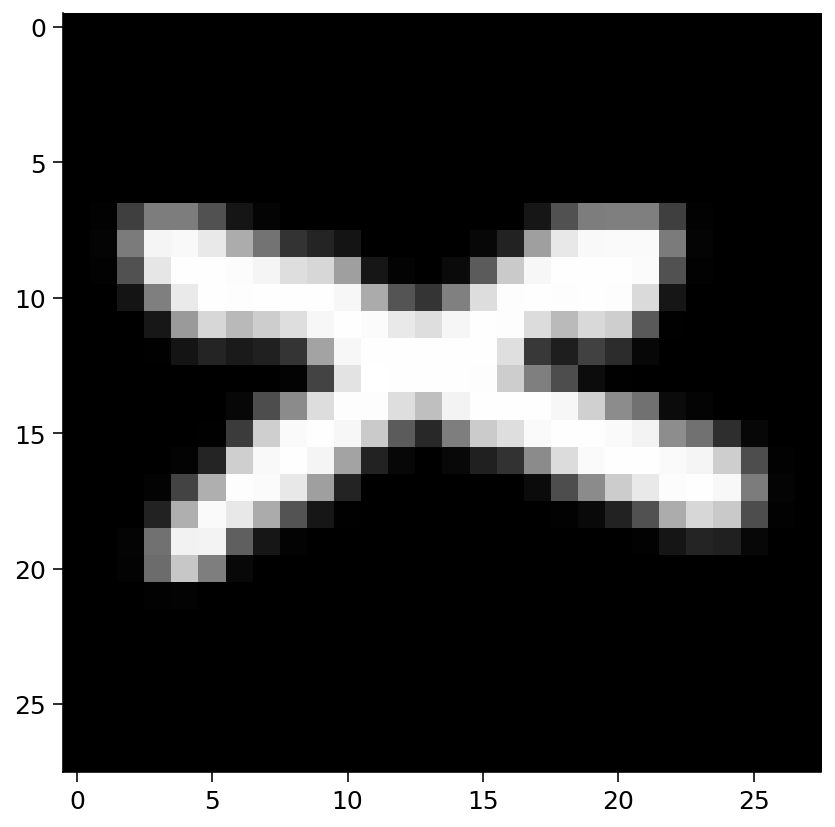


Result: tensor([[0.0022, 0.9978]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being an 'O': 0.002213139086961746
Confidence of image being an 'X': 0.9977868795394897


In [63]:
# index of an image in the dataset that corresponds to an X and O
x_img_idx = 11
o_img_idx = 0

print("Input:")
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[x_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(x_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

The network is quite confident that this image is an $X$!

Note that this is evident from the softmax output, which shows the probabilities of the image belonging to each of the classes. There is a higher probability of belonging to class 1; i.e., class $X$.

Let us also test the network on an $O$ image. 

Input:


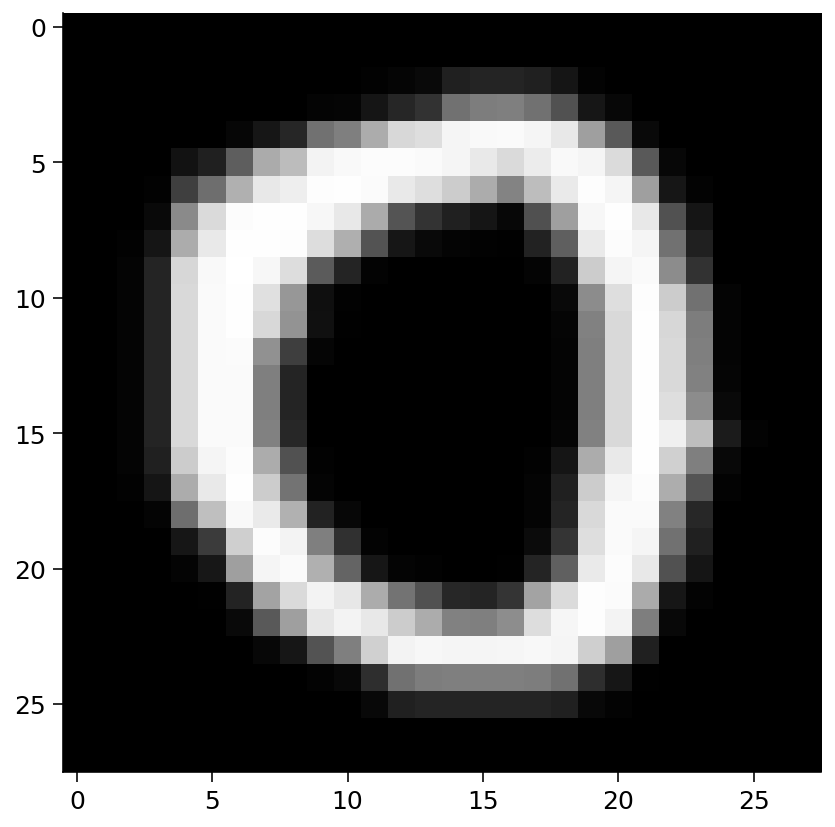


Result: tensor([[9.9972e-01, 2.8410e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being an 'O': 0.9997158646583557
Confidence of image being an 'X': 0.000284102134173736


In [64]:
print("Input:")
o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[o_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(o_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

---
# Summary

In this Tutorial we have familiarized ouselves with CNNs. We have leaned how the convolution operation works and be applied in various images. Also, we have learned to implement our own CNN. In the next Tutorial, we will go deeper in the training of CNNs!

Next we will talk about RNNs, which parameter share over time.

In [65]:
# @title Airtable Submission Link
from IPython import display as IPyDisplay
IPyDisplay.HTML(
    f"""
  <div>
    <a href= "{atform.url()}" target="_blank">
    <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/AirtableSubmissionButton.png?raw=1"
  alt="button link to Airtable" style="width:410px"></a>
    </div>""" )

---
# Bonus 1: Write your own training loop revisited

*Time estimate: ~20mins*

In the last section we coded up a CNN, but trained it with some predefined functions.  In this section, we will walk through an example of training loop for a convolution net. In this section, we will train a CNN using convolution layers and maxpool and then observe what the training and validation curves look like. In Section 6, we will add regularization and data augmentation to see what effects they have on the curves and why it is important to incorporate them while training our network.
<br>


In [66]:
# @title Video 7: Writing your own training loop
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Ko4y1Q7UG", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"L0XG-QKv5_w", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 7: Writing your own training loop')

display(out)

## Bonus 1.1: Understand the Dataset

The dataset we are going to use for this task is called Fashion-MNIST. It consists of a training set of 60,000 examples and a test set of 10,000 examples. We further divide the test set into a validation set and a test set (8000 and 2000 resp). Each example is a 28*28 gray scale image, associated with a label from 10 classes. Following are the labels of the dataset:

0 T-shirt/top <br>
1 Trouser <br>
2 Pullover <br>
3 Dress <br>
4 Coat <br> 
5 Sandal <br>
6 Shirt <br> 
7 Sneaker <br> 
8 Bag <br> 
9 Ankle boot <br> 

**NOTE:** we will reduce the dataset to just the two categories T-shirt/top and Shirt to reduce the training time from about 10min to 2min. We later provide pretrained results to give you an idea how the results would look on the whole dataset.

In [67]:
# @title Download Fashion MNIST dataset

# webpage: https://github.com/zalandoresearch/fashion-mnist
fname = 'FashionMNIST.tar.gz'
folder = 'FashionMNIST'
url = "https://osf.io/dfhu5/download"
download_data(fname, folder, url, tar=True)

FashionMNIST dataset has already been dowloaded.



In [68]:
# @title Loading Fashion-MNIST Data

# @markdown `reduce_classes(data)` to reduce Fashion-MNIST Data to two-categories

# need to split into train, validation, test
def reduce_classes(data):
  # only want T-Shirts (0) and Shirts (6) labels
  train_idx = (data.targets == 0) | (data.targets == 6)
  data.targets = data.targets[train_idx]
  data.data = data.data[train_idx]

  # convert Xs predictions to 1, Os predictions to 0
  data.targets[data.targets == 6] = 1

  return data


def get_fashion_mnist_dataset(binary=False, download=False, seed=0):
  transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                                  ])

  train_data = datasets.FashionMNIST(root='.',
                                     download=download,
                                     train=True,
                                     transform=transform)


  test_data = datasets.FashionMNIST(root='.',
                                    download=download,
                                    train=False,
                                    transform=transform)

  if binary:
    train_data = reduce_classes(train_data)
    test_data = reduce_classes(test_data)

  set_seed(seed)
  validation_data, test_data = torch.utils.data.random_split(test_data,
                                                             [int(0.8*len(test_data)),
                                                              int(0.2*len(test_data))])

  return train_data, validation_data, test_data

In [69]:
num_classes = 10
train_data, validation_data, test_data = get_fashion_mnist_dataset(seed=SEED)

Random seed 2021 has been set.


If you want to continue with the 10 class dataset, skip the next cell.

In [70]:
num_classes = 2
train_data, validation_data, test_data = get_fashion_mnist_dataset(binary=True, seed=SEED)

Random seed 2021 has been set.


Here's some code to visualize the dataset.

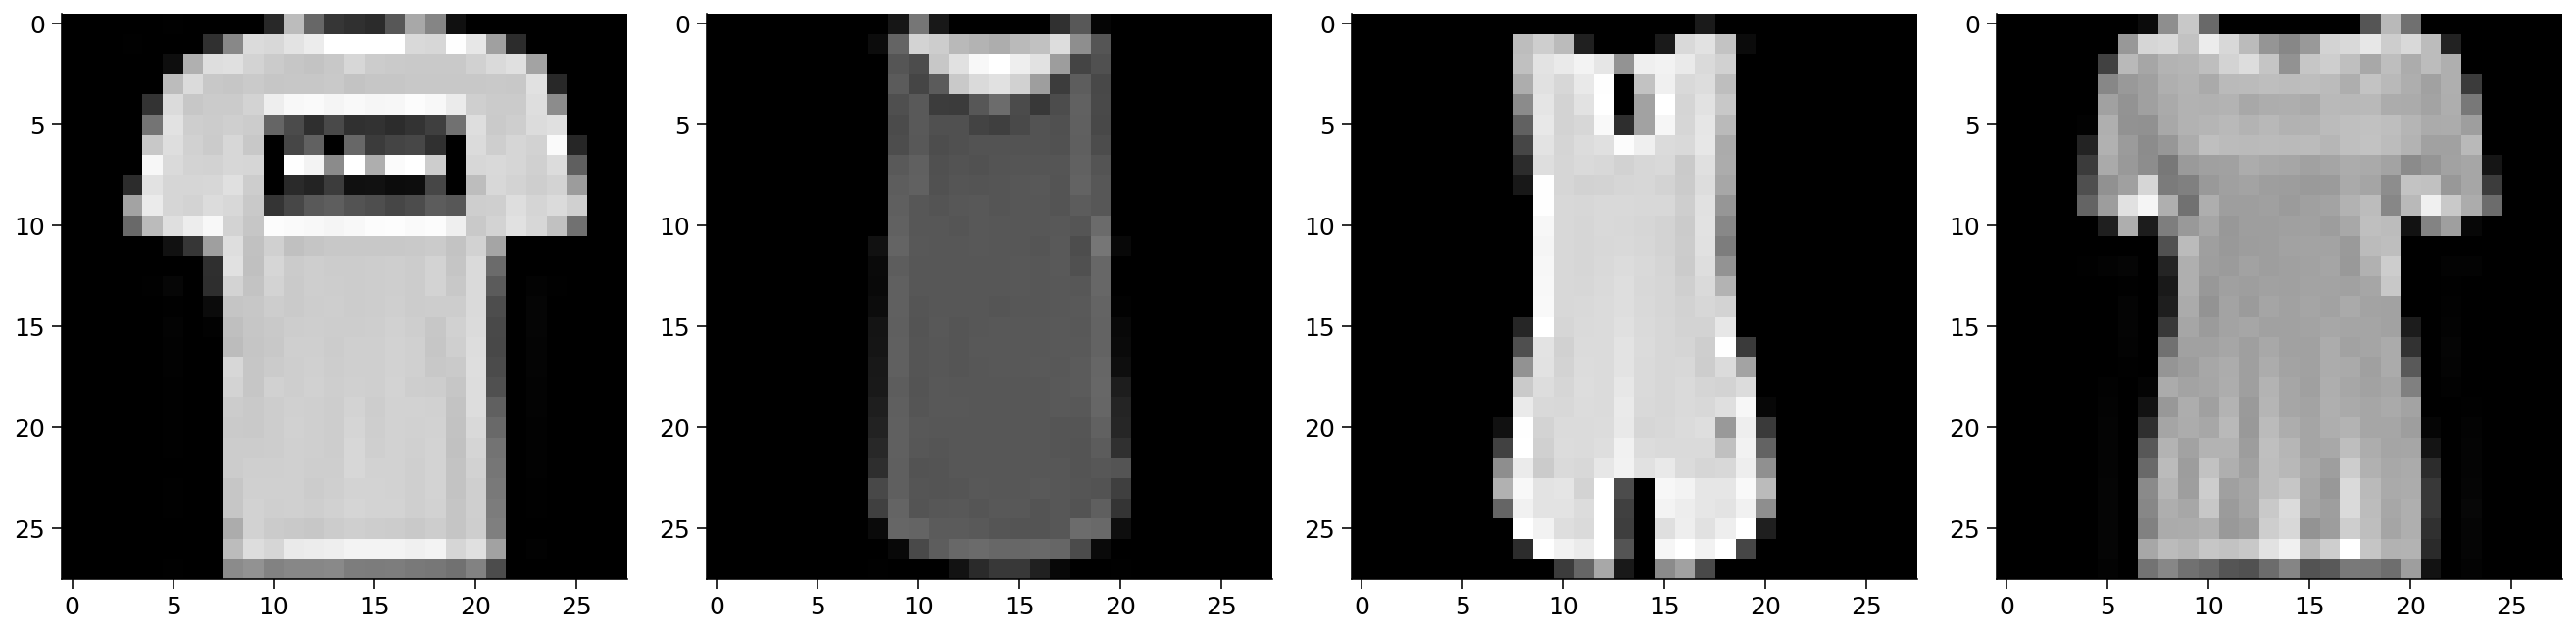

In [71]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(train_data[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(train_data[1][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(train_data[2][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(train_data[3][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

Take a minute with your pod and talk about which classes you think would be most confusable.  How hard will it be to differentiate t-shirt/tops from shirts?

In [72]:
# @title Video 8: The Training Loop
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1av411n7VJ", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"ZgYYgktqaP8", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 8: The Training Loop')

display(out)

## Bonus 1.2: Backpropagation Reminder

_Feel free to skip if you've got a good handle on Backpropagation_

We know that we multiply the input data/tensors with weight matrices to obtain some output. Initially, we don't know what the actual weight matrices are so we initialize them with some random values. These random weight matrices when applied as a transformation on the input gives us some output. At first the outputs/predictions will match the true labels only by chance. 

To improve performance, we need to change the weight matrices so that the predicted outputs are similar to the true outputs (labels). We first calculate how far away the predicted outputs are to the true outputs using a loss function. Based on the loss function, we change the values of our weight matrices using the gradients of the error with respect to the weight matrices. 

Since we are using PyTorch throughout the course, we will use the built-in functions to update the weights. We call the `backward()` method on our 'loss' variable to calculate the gradients/derivatives with respect to all the weight matrices and biases. And then we call the `step()` method on the optimizer variable to apply the gradient updates to our weight matrices.

Here's an animation of backpropagation works.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D1_ConvnetsAndRecurrentNeuralNetworks/static/Backpropagation.gif">


<br>

In [this article](https://machinelearningknowledge.ai/animated-explanation-of-feed-forward-neural-network-architecture/) you can find more animations!



Let's first see a sample training loop. First, we create the network and load a dataset. Then we look at the training loop.

In [73]:
# Create a sample network
class emnist_net(nn.Module):
  def __init__(self):
    super().__init__()
    # First define the layers.
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.fc1 = nn.Linear(7*7*64, 256)
    self.fc2 = nn.Linear(256, 26)

  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = x.view(-1, 7*7*64)  # You have to first flatten the ourput from the
                            # previous convolution layer.
    x = self.fc1(x)
    x = F.relu(x)

    # Fully connected layer 2.
    x = self.fc2(x)
    # x = F.softmax(x)

    return x

In [74]:
# @title Load a sample dataset (EMNIST)
# Download the data if there are not downloaded
fname = 'EMNIST.zip'
folder = 'EMNIST'
url = "https://osf.io/xwfaj/download"
download_data(fname, folder, url, tar=False)

mnist_train = datasets.EMNIST(root=".",
                              train=True,
                              transform=transforms.ToTensor(),
                              download=False,
                              split='letters')
mnist_test = datasets.EMNIST(root=".",
                             train=False,
                             transform=transforms.ToTensor(),
                             download=False,
                             split='letters')

# labels should start from 0
mnist_train.targets -= 1
mnist_test.targets -= 1

# create data loaders
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100,
                                           shuffle=False,
                                           num_workers=2,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100,
                                          shuffle=False,
                                          num_workers=2,
                                          worker_init_fn=seed_worker,
                                          generator=g_seed)

EMNIST dataset has already been dowloaded.



In [75]:
# Training
# Instantiate model
# Puts the Model on the GPU (Select runtime-type as GPU
#                            from the 'Runtime->Change Runtime type' option).

model = emnist_net().to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # <---- change here

# Iterate through train set minibatchs
for epoch in trange(3):  # <---- change here
  for images, labels in tqdm(train_loader):

    # Zero out the gradients
    optimizer.zero_grad() # Fill this out.

    # Forward pass
    x = images
    # Move the data to GPU for faster execution.
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    # Calculate loss.
    loss = criterion(y, labs)

    # Backpropagation and gradient update.
    loss.backward() # Calculate gradients.
    optimizer.step() # Apply gradient udpate.


## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
  # Iterate through test set minibatchs
  for images, labels in tqdm(test_loader):
    # Forward pass
    x = images
      # Move the data to GPU for faster execution.
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    predictions = torch.argmax(y, dim=1)
    correct += torch.sum((predictions == labs).float())

print(f'Test accuracy: {correct/total * 100:.2f}%')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Test accuracy: 93.27%


You already coded the structure of a CNN. Now, you are going to implement the training loop for a CNN. 
- Choose the correct criterion 
- Code up the training part (calculating gradients, loss, stepping forward)
- Keep a track of the running loss i.e for each epoch we want to to know the average loss of the batch size. We have already done the same for accuracy for you. 



## Bonus 1.3: Fashion-MNIST dataset
Now Let us train on the actual Fashion-MNIST dataset.

In [76]:
# @markdown Getting the DataLoaders (Run Me)
def get_data_loaders(train_dataset, validation_dataset, test_dataset, seed,
                     batch_size=64):

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  validation_loader = DataLoader(validation_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=2,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, validation_loader, test_loader


train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                validation_data,
                                                                test_data, SEED)

In [77]:
# This cell contains the code for the CNN we will be using in this section.
class FMNIST_Net1(nn.Module):
  def __init__(self, num_classes):
    super(FMNIST_Net1, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

## Coding Exercise Bonus 1: Code the training loop

Now try coding the training loop.

You should first have a `criterion` defined (you can use `CrossEntropyLoss` here, which you learned about last week) so that you can calculate the loss. Next, you should to put everything together. Start the training process by first obtaining the model output, calculating the loss, and finally updating the weights.

*Don't forget to zero out the gradients.*

NOTE: The comments in the `train` function provides many hints that will help you fill in the missing code. This will give you a solid understanding of the different steps involved in the training loop. 

In [78]:
def train(model, device, train_loader, validation_loader, epochs):

  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01, momentum=0.9)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keeps track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Update the steps of the train loop")
        ####################################################################
        # COMPLETE CODE FOR TRAINING LOOP by following these steps
        # 1. Get the model output (call the model with the data from this batch)
        output = ...

        # 2. Zero the gradients out (i.e. reset the gradient that the optimizer
        #                       has collected so far with optimizer.zero_grad())
        ...

        # 3. Get the Loss (call the loss criterion with the model's output
        #                  and the target values)
        loss = ...

        # 4. Calculate the gradients (do the pass backwards from the loss
        #                             with loss.backward())
        ...

        # 5. Update the weights (using the training step of the optimizer,
        #                        optimizer.step())
        ...

        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Update the set_postfix function")
        ####################################################################
        # set loss to whatever you end up naming your variable when
        # calling criterion
        # for example, loss = criterion(output, target)
        # then set loss = loss.item() in the set_postfix function
        tepochs.set_postfix(loss=...)
        running_loss += ...  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      ####################################################################
      # Fill in missing code below (...),
      # then remove or comment the line below to test your function
      raise NotImplementedError("Append the train_loss")
      ####################################################################
      train_loss.append(...)  # append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0
      for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc


set_seed(SEED)
## Uncomment to test your training loop
# net = FMNIST_Net1(num_classes=2).to(DEVICE)
# train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, validation_loader, 20)
# plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
# print(f'Test accuracy is: {test(net, DEVICE, test_loader)}')

Random seed 2021 has been set.


Random seed 2021 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 87.75


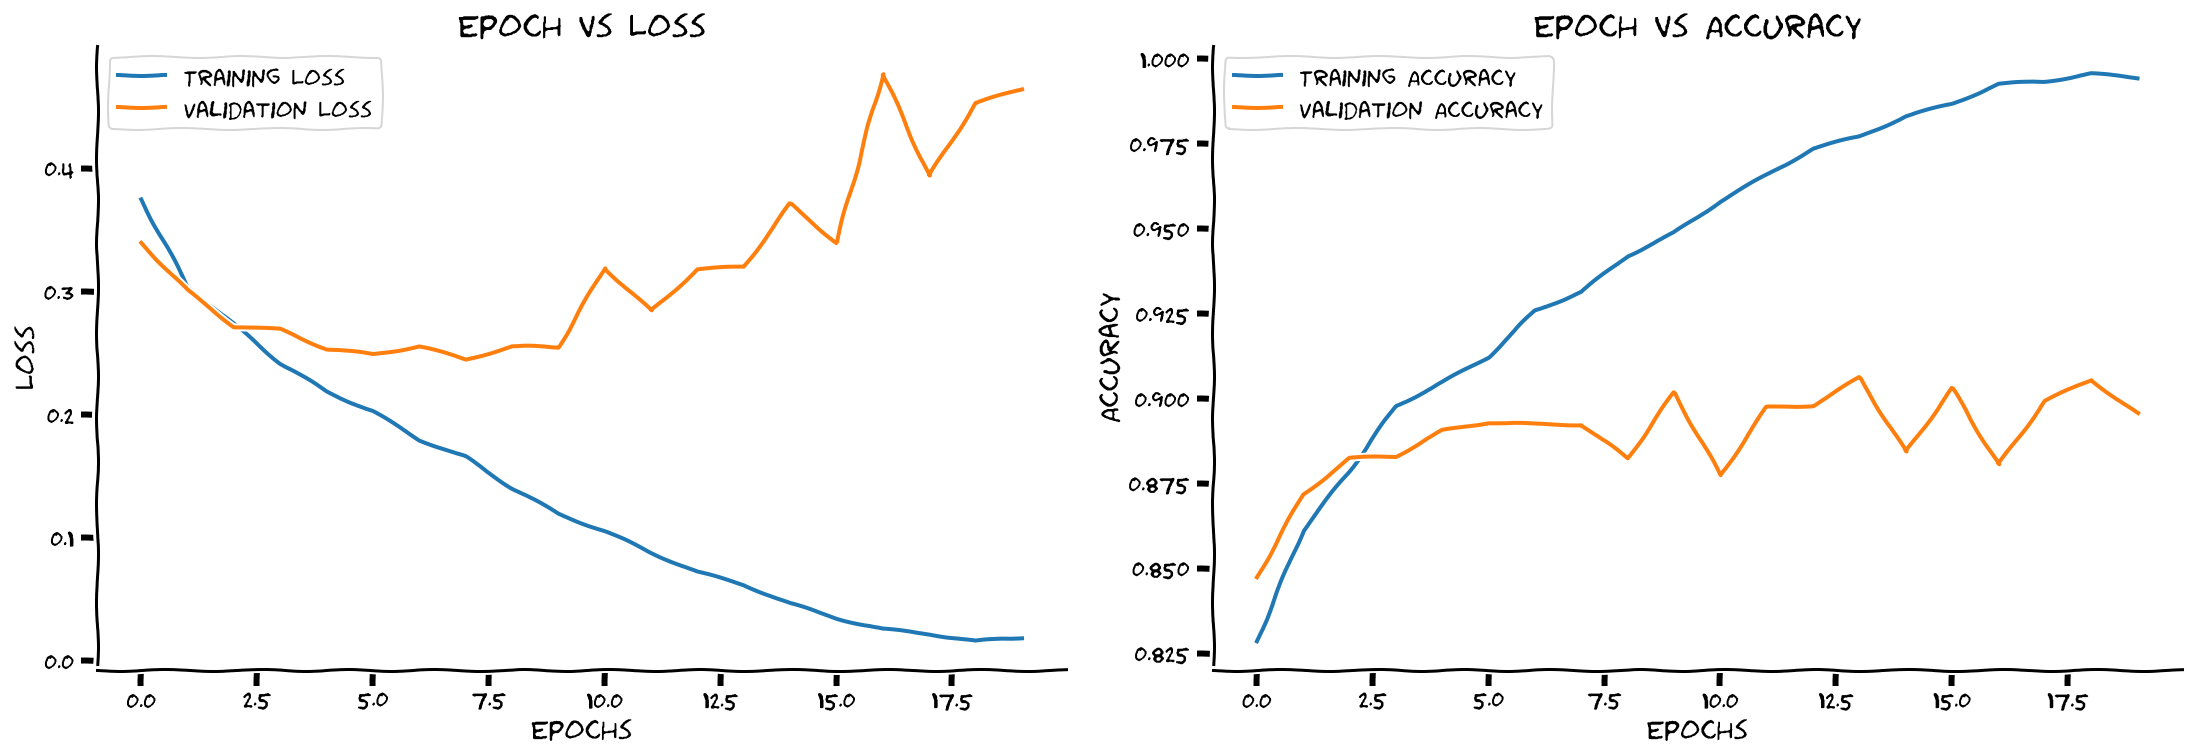

In [79]:
# to_remove solution
def train(model, device, train_loader, validation_loader, epochs):

  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01, momentum=0.9)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keeps track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # COMPLETE CODE FOR TRAINING LOOP by following these steps
        # 1. Get the model output (call the model with the data from this batch)
        output = model(data)

        # 2. Zero the gradients out (i.e. reset the gradient that the optimizer
        #                       has collected so far with optimizer.zero_grad())
        optimizer.zero_grad()

        # 3. Get the Loss (call the loss criterion with the model's output
        #                  and the target values)
        loss = criterion(output, target)

        # 4. Calculate the gradients (do the pass backwards from the loss
        #                             with loss.backward())
        loss.backward()

        # 5. Update the weights (using the training step of the optimizer,
        #                        optimizer.step())
        optimizer.step()

        # set loss to whatever you end up naming your variable when
        # calling criterion
        # for example, loss = criterion(output, target)
        # then set loss = loss.item() in the set_postfix function
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      train_loss.append(running_loss/len(train_loader))  # append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0
      for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc


set_seed(SEED)
## Uncomment to test your training loop
net = FMNIST_Net1(num_classes=2).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, validation_loader, 20)
with plt.xkcd():
  plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
print(f'Test accuracy is: {test(net, DEVICE, test_loader)}')

## Think! Bonus 1: Overfitting
Do you think this network is overfitting?
If yes, what can you do to combat this?

**Hint**: overfitting occurs when the training accuracy greatly exceeds the validation accuracy


In [80]:
# to_remove explanation

"""
The network is overfitting as the validation loss does not decrease further even
though the training loss still decreases. The validation loss even increases,
showing that further training is detrimental for the generalisation performance
of the network, hence it is overfitting.

To prevent overfitting, e.g. dropout can be used, as discussed in the next
section.
""";

---
# Bonus 2: Overfitting - symptoms and cures

*Time estimate: ~30mins*

So you spent some time last week learning about regularization techniques. Below is a copy of the CNN model we used previously.  Now we want you to add some dropout regularization, and check if that helps reduce overfitting. If you're up for a challenge, you can try methods other than dropout as well.

## Bonus 2.1: Regularization

### Coding Exercise Bonus 2.1: Adding Regularization

Add various regularization methods, feel free to add any and play around!

In [81]:
class FMNIST_Net2(nn.Module):
  def __init__(self, num_classes):
    super(FMNIST_Net2, self).__init__()
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Add regularization layers")
    ####################################################################
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = ...
    self.dropout2 = ...
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    ####################################################################
    # Now add the layers in your forward pass in appropriate order
    # then remove or comment the line below to test your function
    raise NotImplementedError("Add regularization in the forward pass")
    ####################################################################
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = ...
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = ...
    x = self.fc2(x)

    return x


# add event to airtable
atform.add_event('Coding Exercise Bonus 2.1: Adding Regularization')

set_seed(SEED)
## Uncomment below to check your code
# net2 = FMNIST_Net2(num_classes=2).to(DEVICE)
# train_loss, train_acc, validation_loss, validation_acc = train(net2, DEVICE, train_loader, validation_loader, 20)
# plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
# print(f'Test accuracy is: {test(net2, DEVICE, test_loader)}')

Random seed 2021 has been set.


Random seed 2021 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 88.5


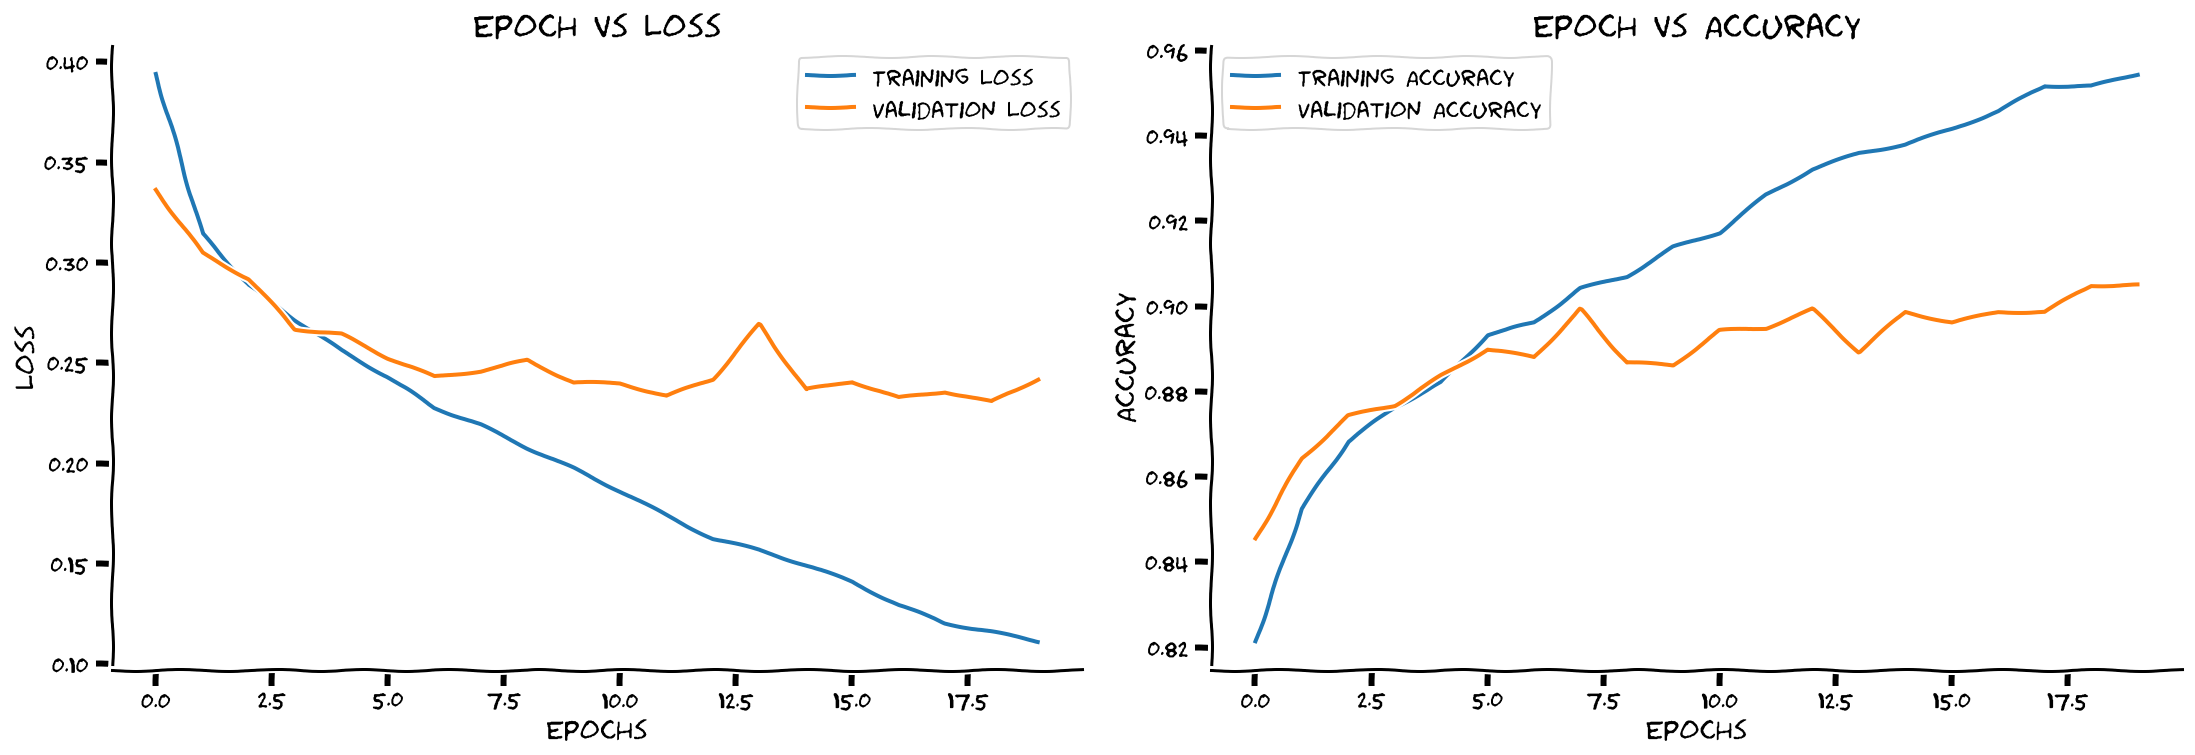

In [82]:
# to_remove solution
class FMNIST_Net2(nn.Module):
  def __init__(self, num_classes):
    super(FMNIST_Net2, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.5)
    self.dropout2 = nn.Dropout(0.25)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x


# add event to airtable
atform.add_event('Coding Exercise Bonus 2.1: Adding Regularization')

set_seed(SEED)
## Uncomment below to check your code
net2 = FMNIST_Net2(num_classes=2).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net2, DEVICE, train_loader, validation_loader, 20)
with plt.xkcd():
  plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
print(f'Test accuracy is: {test(net2, DEVICE, test_loader)}')

### Think! Bonus 2.1: Regularization 

1. Is the training accuracy slightly reduced from before adding regularization? What accuracy were you able to reduce it to?

2. Why does the validation accuracy start higher than training accuracy?


In [83]:
# to_remove explanation

"""
1. The overfitting is now reduced, as the validation loss now does not increase
   strongly anymore. But as the training loss still decreases while the
   validation loss stays constant, the network is still overfitting, but this
   time it at least does not affect the generalisation performance as strongly
   as before.

2. Since dropout is only applied to training process, the training accuracy is
   reduced but not the validation accuracy.
""";

### Interactive Demo Bonus 2.1: Dropout exploration

If you want to try out more dropout parameter combinations, but do not have the time to run them, we have here precalculated some combinations you can use the sliders to explore them.

In [84]:
# @markdown  *Run this cell to enable the widget*

from ipywidgets import interactive, widgets, interactive_output

data = [[0, 0, [0.3495898238046372, 0.2901147632522786, 0.2504794800931469, 0.23571575765914105, 0.21297093365896255, 0.19087818914905508, 0.186408187797729, 0.19487689035211472, 0.16774938120803934, 0.1548648244958926, 0.1390149021382503, 0.10919439224922593, 0.10054351237820501, 0.09900783193594914, 0.08370604479507088, 0.07831853718318521, 0.06859792241866285, 0.06152600247383197, 0.046342475851873885, 0.055123823092992796], [0.83475, 0.8659166666666667, 0.8874166666666666, 0.8913333333333333, 0.8998333333333334, 0.9140833333333334, 0.9178333333333333, 0.9138333333333334, 0.9251666666666667, 0.92975, 0.939, 0.9525833333333333, 0.9548333333333333, 0.9585833333333333, 0.9655833333333333, 0.9661666666666666, 0.9704166666666667, 0.9743333333333334, 0.9808333333333333, 0.9775], [0.334623601436615, 0.2977438402175903, 0.2655304968357086, 0.25506321132183074, 0.2588835284113884, 0.2336345863342285, 0.3029863876104355, 0.240766831189394, 0.2719801160693169, 0.25231350839138034, 0.2500132185220718, 0.26699506521224975, 0.2934862145781517, 0.361227530837059, 0.33196919202804565, 0.36985905408859254, 0.4042587959766388, 0.3716402840614319, 0.3707024946808815, 0.4652537405490875], [0.866875, 0.851875, 0.8775, 0.889375, 0.881875, 0.900625, 0.85, 0.898125, 0.885625, 0.876875, 0.899375, 0.90625, 0.89875, 0.87, 0.898125, 0.884375, 0.874375, 0.89375, 0.903125, 0.890625]], [0, 0.25, [0.35404509995528993, 0.30616586227366266, 0.2872369573946963, 0.27564131199045383, 0.25969504263806853, 0.24728168408445855, 0.23505379509260046, 0.21552803914280647, 0.209761732277718, 0.19977611067526518, 0.19632092922767427, 0.18672360206379535, 0.16564940239124476, 0.1654047035671612, 0.1684555298985636, 0.1627526102349796, 0.13878319327263755, 0.12881529055773577, 0.12628930977525862, 0.11346105090837846], [0.8324166666666667, 0.8604166666666667, 0.8680833333333333, 0.8728333333333333, 0.8829166666666667, 0.88625, 0.89425, 0.90125, 0.9015833333333333, 0.90925, 0.9114166666666667, 0.917, 0.9268333333333333, 0.92475, 0.921, 0.9255833333333333, 0.9385, 0.9428333333333333, 0.9424166666666667, 0.9484166666666667], [0.3533937376737595, 0.29569859683513644, 0.27531551957130435, 0.2576177391409874, 0.26947550356388095, 0.25361743807792664, 0.2527468180656433, 0.24179009914398195, 0.28664454460144045, 0.23347773611545564, 0.24672816634178163, 0.27822364538908007, 0.2380720081925392, 0.24426509588956832, 0.2443918392062187, 0.24207917481660843, 0.2519641682505608, 0.3075403380393982, 0.2798181238770485, 0.26709021866321564], [0.826875, 0.87, 0.870625, 0.8875, 0.883125, 0.88625, 0.891875, 0.891875, 0.890625, 0.903125, 0.89375, 0.885625, 0.903125, 0.888125, 0.899375, 0.898125, 0.905, 0.905625, 0.898125, 0.901875]], [0, 0.5, [0.39775496332886373, 0.33771887778284704, 0.321900939132939, 0.3079229625774191, 0.304149763301966, 0.28249239723416086, 0.2861261191044716, 0.27356165798103554, 0.2654648520686525, 0.2697350280557541, 0.25354846321204877, 0.24612889034633942, 0.23482802549892284, 0.2389904112416379, 0.23742155821875055, 0.232423192127905, 0.22337309338469455, 0.2141852991932884, 0.20677659985549907, 0.19355326712607068], [0.8155, 0.83625, 0.8481666666666666, 0.8530833333333333, 0.8571666666666666, 0.86775, 0.8623333333333333, 0.8711666666666666, 0.8748333333333334, 0.8685833333333334, 0.8785, 0.8804166666666666, 0.8835833333333334, 0.8840833333333333, 0.88875, 0.8919166666666667, 0.8946666666666667, 0.8960833333333333, 0.906, 0.9063333333333333], [0.3430288594961166, 0.4062050700187683, 0.29745822548866274, 0.27728439271450045, 0.28092808067798614, 0.2577864158153534, 0.2651400637626648, 0.25632822573184966, 0.3082498562335968, 0.2812121778726578, 0.26345942318439486, 0.2577408078312874, 0.25757989794015884, 0.26434457510709763, 0.24917411386966706, 0.27261342853307724, 0.2445397639274597, 0.26001051396131514, 0.24147838801145555, 0.2471102523803711], [0.82875, 0.795625, 0.87, 0.87375, 0.865625, 0.8825, 0.8825, 0.87625, 0.848125, 0.87875, 0.8675, 0.889375, 0.8925, 0.866875, 0.87375, 0.87125, 0.895625, 0.90375, 0.90125, 0.88625]], [0, 0.75, [0.4454924576777093, 0.43416607585993217, 0.42200265769311723, 0.40520024616667566, 0.41137005166804536, 0.404100904280835, 0.40118067664034823, 0.40139733080534223, 0.3797615355158106, 0.3596332479030528, 0.3600061919460905, 0.3554147962242999, 0.34480382890460337, 0.3329520877054397, 0.33164913056695716, 0.31860941466181836, 0.30702565340919696, 0.30605297186907304, 0.2953788426486736, 0.2877389984403519], [0.7788333333333334, 0.7825, 0.7854166666666667, 0.7916666666666666, 0.7885, 0.7833333333333333, 0.7923333333333333, 0.79525, 0.805, 0.81475, 0.8161666666666667, 0.8188333333333333, 0.817, 0.8266666666666667, 0.82225, 0.8360833333333333, 0.8456666666666667, 0.8430833333333333, 0.8491666666666666, 0.8486666666666667], [0.3507828885316849, 0.3337512403726578, 0.34320746660232543, 0.3476085543632507, 0.3326113569736481, 0.33033264458179473, 0.32014619171619413, 0.3182142299413681, 0.30076164126396177, 0.3263852882385254, 0.27597591280937195, 0.29062016785144806, 0.2765174686908722, 0.269492534995079, 0.2679423809051514, 0.2691828978061676, 0.2726386785507202, 0.2541181230545044, 0.2580208206176758, 0.26315389811992645], [0.839375, 0.843125, 0.823125, 0.821875, 0.81875, 0.819375, 0.8225, 0.826875, 0.835625, 0.865, 0.868125, 0.855625, 0.868125, 0.884375, 0.883125, 0.875, 0.87375, 0.883125, 0.8975, 0.885]], [0.25, 0, [0.34561181647029326, 0.2834314257699124, 0.2583787844298368, 0.23892096465730922, 0.23207981773513428, 0.20245029634617745, 0.183908417583146, 0.17489413774393975, 0.17696723581707857, 0.15615438255778652, 0.14469048382833283, 0.12424647461305907, 0.11314761043189371, 0.11249036608422373, 0.10725672634199579, 0.09081190969160896, 0.0942245383271353, 0.08525650047677312, 0.06622548752583246, 0.06039895973307021], [0.8356666666666667, 0.8675833333333334, 0.88175, 0.8933333333333333, 0.8975833333333333, 0.91175, 0.91825, 0.9249166666666667, 0.9238333333333333, 0.9305, 0.938, 0.9465833333333333, 0.9525833333333333, 0.9539166666666666, 0.9555, 0.9615, 0.9606666666666667, 0.96275, 0.9725, 0.9764166666666667], [0.31630186855792997, 0.2702121251821518, 0.2915778249502182, 0.26050266206264494, 0.27837209939956664, 0.24276352763175965, 0.3567117482423782, 0.2752074319124222, 0.2423130339384079, 0.2565067422389984, 0.28710135877132414, 0.266545415520668, 0.31818037331104276, 0.28757534325122835, 0.2777567034959793, 0.2998969575762749, 0.3292293107509613, 0.30775387287139894, 0.32681577146053314, 0.44882203072309496], [0.85375, 0.879375, 0.875625, 0.89, 0.86125, 0.884375, 0.851875, 0.8875, 0.89625, 0.875625, 0.8675, 0.895, 0.888125, 0.89125, 0.889375, 0.880625, 0.87875, 0.8875, 0.894375, 0.891875]], [0.25, 0.25, [0.35970850011452715, 0.31336131549261986, 0.2881505932421126, 0.2732012960267194, 0.26232245425753137, 0.2490472443639598, 0.24866499093935845, 0.22930880945096624, 0.21745950407645803, 0.20700296882460725, 0.197304340356842, 0.20665066804182022, 0.19864868348900308, 0.184807124210799, 0.1684703354703936, 0.17377675851767369, 0.16638460063791655, 0.15944768343754906, 0.14876513817208878, 0.1388207479835825], [0.83375, 0.85175, 0.86725, 0.8719166666666667, 0.8761666666666666, 0.8865833333333333, 0.88275, 0.8956666666666667, 0.8995833333333333, 0.9034166666666666, 0.90825, 0.9043333333333333, 0.9093333333333333, 0.9145, 0.9196666666666666, 0.9196666666666666, 0.9216666666666666, 0.9273333333333333, 0.9299166666666666, 0.93675], [0.3166788029670715, 0.28422485530376435, 0.38055971562862395, 0.2586472672224045, 0.2588653892278671, 0.27983254253864287, 0.25693483114242555, 0.26412731170654297, 0.2733065390586853, 0.24399636536836625, 0.24481021404266357, 0.2689305514097214, 0.2527604129910469, 0.24829535871744157, 0.2654112687706947, 0.23074268400669098, 0.24625462979078294, 0.26423920392990113, 0.25540480852127073, 0.25536185175180437], [0.856875, 0.86625, 0.815, 0.8825, 0.88125, 0.875625, 0.89, 0.8775, 0.870625, 0.895, 0.8975, 0.87375, 0.88625, 0.89125, 0.903125, 0.9, 0.893125, 0.89, 0.8925, 0.899375]], [0.25, 0.5, [0.3975753842040579, 0.34884724409339274, 0.3296900932142075, 0.3150389680361494, 0.31285368667003954, 0.30415422033439293, 0.29553352716438314, 0.289314468094009, 0.2806722329969102, 0.2724469883486311, 0.26634286379719035, 0.2645016222241077, 0.2619251853766594, 0.2551752221473354, 0.26411766035759704, 0.24515971153023394, 0.2390686312412962, 0.23573122312255362, 0.221005061562074, 0.22358600648635246], [0.8106666666666666, 0.8286666666666667, 0.844, 0.8513333333333334, 0.84975, 0.8570833333333333, 0.8624166666666667, 0.8626666666666667, 0.866, 0.8706666666666667, 0.8738333333333334, 0.8748333333333334, 0.8778333333333334, 0.8798333333333334, 0.87375, 0.8865, 0.8898333333333334, 0.8885833333333333, 0.8991666666666667, 0.8968333333333334], [0.3597823417186737, 0.31115993797779085, 0.29929635107517244, 0.2986589139699936, 0.2938830828666687, 0.28118040919303894, 0.2711684626340866, 0.2844697123765945, 0.26613601863384245, 0.2783134698867798, 0.2540236383676529, 0.25821100890636445, 0.2618845862150192, 0.2554920208454132, 0.26543013513088226, 0.24074569433927537, 0.26475649774074556, 0.25578504264354707, 0.2648500043153763, 0.25700133621692656], [0.825, 0.8375, 0.85875, 0.855625, 0.861875, 0.868125, 0.875, 0.85375, 0.886875, 0.86375, 0.88375, 0.885625, 0.875625, 0.87375, 0.8875, 0.895, 0.874375, 0.89125, 0.88625, 0.895625]], [0.25, 0.75, [0.4584837538447786, 0.4506375778545725, 0.4378386567089152, 0.4066803843734112, 0.3897064097542712, 0.3855383962868376, 0.39160584618753574, 0.3731403942120836, 0.37915910170116324, 0.36966170814443144, 0.35735995298687445, 0.35630573094525236, 0.346426092167484, 0.34040802899510303, 0.32829743726773464, 0.3284692421872565, 0.3186114077713895, 0.32295761503120685, 0.3201326223764014, 0.30581602454185486], [0.7803333333333333, 0.7709166666666667, 0.7723333333333333, 0.7850833333333334, 0.7885, 0.7903333333333333, 0.7986666666666666, 0.805, 0.8011666666666667, 0.8068333333333333, 0.8095833333333333, 0.8226666666666667, 0.8285, 0.83125, 0.8369166666666666, 0.8395, 0.8441666666666666, 0.8393333333333334, 0.8490833333333333, 0.8546666666666667], [0.43526833415031435, 0.3598956459760666, 0.3492005372047424, 0.33501910269260404, 0.31689528703689573, 0.3113307124376297, 0.32388085544109346, 0.3084335786104202, 0.3013568025827408, 0.28992725372314454, 0.28726822674274444, 0.26945948660373686, 0.276592333316803, 0.27462401330471037, 0.27574350595474245, 0.2710308712720871, 0.2702724140882492, 0.27323003828525544, 0.25551479041576386, 0.26488787233829497], [0.808125, 0.81625, 0.805, 0.8325, 0.846875, 0.835625, 0.850625, 0.838125, 0.836875, 0.861875, 0.85375, 0.866875, 0.858125, 0.8825, 0.879375, 0.874375, 0.874375, 0.886875, 0.883125, 0.86875]], [0.5, 0, [0.3579516930783049, 0.29596046564426826, 0.2779693031247626, 0.2563994538356015, 0.24771526356802342, 0.2324555875693864, 0.2139121579362991, 0.20474095547452886, 0.19138856208387842, 0.18883306279461434, 0.1763652620757831, 0.1698919345248253, 0.16033914366221808, 0.1557997044651432, 0.1432509447467771, 0.13817814606776896, 0.12609625801919622, 0.11830132696381275, 0.11182412960903441, 0.112559904720872], [0.8314166666666667, 0.8611666666666666, 0.8736666666666667, 0.8800833333333333, 0.885, 0.8944166666666666, 0.9036666666666666, 0.9090833333333334, 0.9193333333333333, 0.9161666666666667, 0.92225, 0.9255, 0.93075, 0.93225, 0.939, 0.9414166666666667, 0.94375, 0.9485833333333333, 0.9535833333333333, 0.9524166666666667], [0.30677567660808563, 0.32954772651195524, 0.25747098088264464, 0.2736126834154129, 0.2561805549263954, 0.23671718776226044, 0.24553639352321624, 0.2338863667845726, 0.24586652517318724, 0.23423030972480774, 0.26579618513584136, 0.2781539523601532, 0.27084136098623274, 0.23948652744293214, 0.26023868829011915, 0.2419952344894409, 0.2511997854709625, 0.23935708701610564, 0.2701922015845776, 0.27307246536016466], [0.870625, 0.855625, 0.886875, 0.875625, 0.878125, 0.8925, 0.885, 0.890625, 0.876875, 0.896875, 0.881875, 0.8875, 0.89, 0.898125, 0.896875, 0.89, 0.89875, 0.904375, 0.906875, 0.894375]], [0.5, 0.25, [0.3712943946903056, 0.3198322071594761, 0.29978102302931725, 0.295274139798068, 0.2861913934032968, 0.27165328782606635, 0.25972246442069397, 0.2543164194819141, 0.24795781916126292, 0.24630710007028378, 0.23296909834793272, 0.23382153587931015, 0.2239028559799524, 0.21443849290780564, 0.2149274461367663, 0.20642021417300752, 0.19801520536396097, 0.1978839404009124, 0.19118623847657062, 0.18144798041024107], [0.8235833333333333, 0.8538333333333333, 0.8604166666666667, 0.86075, 0.8664166666666666, 0.8754166666666666, 0.8799166666666667, 0.8815833333333334, 0.88725, 0.8848333333333334, 0.8936666666666667, 0.8935, 0.895, 0.8995, 0.89625, 0.9068333333333334, 0.9098333333333334, 0.9120833333333334, 0.91375, 0.9175833333333333], [0.3184810388088226, 0.2948088157176971, 0.29438531696796416, 0.27669853866100313, 0.2634278678894043, 0.25847582578659056, 0.2500907778739929, 0.2538330048322678, 0.25127841770648957, 0.2519759064912796, 0.2455715072154999, 0.2437664610147476, 0.259639236330986, 0.24515749186277389, 0.2553828465938568, 0.2324645048379898, 0.24492083072662355, 0.24482838332653045, 0.23327024638652802, 0.2520161652565002], [0.855, 0.865, 0.8525, 0.856875, 0.876875, 0.88125, 0.8825, 0.8875, 0.8925, 0.8925, 0.88875, 0.889375, 0.87375, 0.895, 0.889375, 0.90625, 0.883125, 0.895, 0.899375, 0.901875]], [0.5, 0.5, [0.40442772225496615, 0.36662670541951, 0.355034276367502, 0.3396551510755052, 0.3378269396563794, 0.32084332002287214, 0.31314464951766297, 0.2982726935693558, 0.2885229691387491, 0.2888992782285873, 0.2893476904706752, 0.281817957996688, 0.2771622718490185, 0.2693793097550565, 0.2617615883416952, 0.2657115764995205, 0.25631817549150043, 0.24793559907281654, 0.2538738044652533, 0.23912971732305718], [0.8093333333333333, 0.82825, 0.8341666666666666, 0.84525, 0.84525, 0.8515, 0.8583333333333333, 0.8626666666666667, 0.8688333333333333, 0.8685, 0.8689166666666667, 0.8693333333333333, 0.8711666666666666, 0.8766666666666667, 0.88275, 0.88175, 0.8839166666666667, 0.8866666666666667, 0.8839166666666667, 0.8929166666666667], [0.38392188608646394, 0.3653419762849808, 0.3050421380996704, 0.30614266455173494, 0.2937217426300049, 0.30008585572242735, 0.2794034606218338, 0.27541795969009397, 0.31378355383872986, 0.2670704126358032, 0.26745485186576845, 0.2471194839477539, 0.26509816259145735, 0.25458798944950106, 0.2481587851047516, 0.25591064751148224, 0.2596563971042633, 0.2569611769914627, 0.2435744071006775, 0.2507249677181244], [0.820625, 0.846875, 0.856875, 0.868125, 0.860625, 0.87125, 0.86625, 0.87375, 0.865625, 0.87875, 0.878125, 0.889375, 0.87875, 0.886875, 0.89125, 0.89, 0.87375, 0.884375, 0.88875, 0.89375]], [0.5, 0.75, [0.46106574311852455, 0.4519433615372536, 0.4446939624687459, 0.4284856241751224, 0.4527993325857406, 0.4220876024758562, 0.40969764266876463, 0.39233948219012704, 0.42498463344700793, 0.3869199570506177, 0.38021832910623954, 0.3855376149270129, 0.3721433773319772, 0.3662295250340979, 0.3629763710530514, 0.358500304691335, 0.3490118366131123, 0.34879197790584665, 0.33399240054348683, 0.3347948451149971], [0.7866666666666666, 0.7865, 0.784, 0.79375, 0.7755833333333333, 0.79125, 0.7973333333333333, 0.8085833333333333, 0.7913333333333333, 0.8125833333333333, 0.81675, 0.812, 0.8173333333333334, 0.8235833333333333, 0.831, 0.8306666666666667, 0.8353333333333334, 0.8320833333333333, 0.84375, 0.8410833333333333], [0.35159709095954894, 0.3579048192501068, 0.3501501774787903, 0.33594816565513613, 0.3741619431972504, 0.34183687329292295, 0.3353554099798203, 0.32617265462875367, 0.3640907108783722, 0.33187183618545535, 0.32401839792728426, 0.30536725163459777, 0.31303414940834046, 0.2893040508031845, 0.3063929396867752, 0.2909839802980423, 0.2858921372890472, 0.2850045281648636, 0.28049838364124297, 0.2873564797639847], [0.816875, 0.793125, 0.810625, 0.821875, 0.8175, 0.82, 0.816875, 0.814375, 0.828125, 0.83875, 0.818125, 0.843125, 0.834375, 0.85875, 0.874375, 0.85375, 0.870625, 0.85375, 0.883125, 0.848125]], [0.75, 0, [0.37716902824158366, 0.3260373148195287, 0.3128290904012132, 0.2998493126732238, 0.29384377892030045, 0.2759418967873492, 0.26431119905665834, 0.2577077782455277, 0.25772295725789474, 0.24954422610871335, 0.24065862928933285, 0.23703582263848882, 0.23237684028262787, 0.2200249534575863, 0.22110319957929722, 0.21804759631607126, 0.21419822757548473, 0.19927451733816812, 0.19864692467641323, 0.18966749441274938], [0.8215833333333333, 0.848, 0.8526666666666667, 0.8585, 0.8639166666666667, 0.8716666666666667, 0.8783333333333333, 0.8849166666666667, 0.88325, 0.88325, 0.8918333333333334, 0.8913333333333333, 0.896, 0.9010833333333333, 0.8996666666666666, 0.9016666666666666, 0.902, 0.9120833333333334, 0.9105833333333333, 0.9160833333333334], [0.3255926352739334, 0.3397491586208343, 0.3148202610015869, 0.30447013437747955, 0.27427292466163633, 0.2607581865787506, 0.2583494257926941, 0.24150457441806794, 0.24839721441268922, 0.24157819360494615, 0.24594406485557557, 0.2547012311220169, 0.24132476687431337, 0.2433958488702774, 0.2358475297689438, 0.24675665378570558, 0.23343635857105255, 0.22841362684965133, 0.2247604575753212, 0.24281086921691894], [0.85125, 0.85125, 0.853125, 0.851875, 0.876875, 0.87875, 0.883125, 0.888125, 0.89, 0.888125, 0.88375, 0.86625, 0.88375, 0.888125, 0.898125, 0.88875, 0.896875, 0.894375, 0.899375, 0.88625]], [0.75, 0.25, [0.3795942336796446, 0.33614943612446174, 0.3235826115024851, 0.3267444484728448, 0.30353531146303137, 0.29750882636042353, 0.2964640334248543, 0.28714796314214136, 0.2744278162717819, 0.27310871372514584, 0.2624819800257683, 0.2579742945889209, 0.25963644726954876, 0.25635017161356644, 0.2501001837960583, 0.24249463702769988, 0.23696896695393196, 0.23254455582417072, 0.22419108628751117, 0.22851746232110134], [0.8204166666666667, 0.839, 0.847, 0.8506666666666667, 0.8571666666666666, 0.8635, 0.8639166666666667, 0.8711666666666666, 0.8711666666666666, 0.87475, 0.87875, 0.87925, 0.8805833333333334, 0.8845, 0.88675, 0.8908333333333334, 0.8926666666666667, 0.89525, 0.8985, 0.8955833333333333], [0.3383863967657089, 0.31120560944080355, 0.32110977828502657, 0.3080899566411972, 0.2866462391614914, 0.27701647162437437, 0.29040718913078306, 0.2702513742446899, 0.2590403389930725, 0.26199558019638064, 0.26484714448451996, 0.2940529054403305, 0.2654808533191681, 0.25154681205749513, 0.26637687146663663, 0.24435366928577423, 0.24174826145172118, 0.2444209086894989, 0.247626873254776, 0.24192263156175614], [0.843125, 0.8575, 0.86, 0.86375, 0.87, 0.875625, 0.865, 0.88, 0.879375, 0.885, 0.888125, 0.85625, 0.87625, 0.88375, 0.879375, 0.888125, 0.8875, 0.886875, 0.8825, 0.8925]], [0.75, 0.5, [0.41032169133107715, 0.37122817583223605, 0.35897897873470125, 0.3438001747064768, 0.33858899811797954, 0.3389760729797343, 0.32536247420184156, 0.3152934226425404, 0.30936657058748795, 0.3078679118226183, 0.30974164977669716, 0.30031369174731537, 0.29489042173991814, 0.28921707251921613, 0.28369594476324445, 0.2849519875772456, 0.27076949349584734, 0.26930386248104116, 0.26349931491657774, 0.26431971300948176], [0.8086666666666666, 0.82875, 0.8284166666666667, 0.8381666666666666, 0.837, 0.8389166666666666, 0.8490833333333333, 0.8488333333333333, 0.8533333333333334, 0.8551666666666666, 0.8509166666666667, 0.8615, 0.8628333333333333, 0.86225, 0.8715, 0.86775, 0.8748333333333334, 0.8719166666666667, 0.8814166666666666, 0.8835], [0.3464747530221939, 0.3193131250143051, 0.3464068531990051, 0.3129056388139725, 0.3131117367744446, 0.30689118325710296, 0.2929005026817322, 0.3131696957349777, 0.302835636138916, 0.27934255003929137, 0.300513002872467, 0.26962003886699676, 0.2676294481754303, 0.26430738389492037, 0.2525753951072693, 0.2508367341756821, 0.25303518533706665, 0.24774718701839446, 0.24518848478794097, 0.26084545016288757], [0.8225, 0.85375, 0.849375, 0.853125, 0.85875, 0.848125, 0.856875, 0.8575, 0.87, 0.869375, 0.863125, 0.886875, 0.8725, 0.878125, 0.894375, 0.888125, 0.8875, 0.89125, 0.88875, 0.86875]], [0.75, 0.75, [0.4765880586619073, 0.4503744399928032, 0.4249279998401378, 0.42333967214886176, 0.4236916420941657, 0.4269233151002133, 0.4192506206479478, 0.41413671872083174, 0.41084911515738104, 0.389948022413127, 0.39566395788433706, 0.3741930383951106, 0.3794517093040842, 0.3692300356131919, 0.3640432547223061, 0.3608953575504587, 0.3419572095129084, 0.34907091543712515, 0.33601277535583113, 0.3408893179544743], [0.77625, 0.7823333333333333, 0.7916666666666666, 0.80075, 0.7973333333333333, 0.7810833333333334, 0.7928333333333333, 0.7930833333333334, 0.7951666666666667, 0.8015833333333333, 0.8000833333333334, 0.8126666666666666, 0.811, 0.81775, 0.8236666666666667, 0.8215, 0.8305833333333333, 0.8251666666666667, 0.8299166666666666, 0.836], [0.3674533206224442, 0.36733597874641416, 0.35894496202468873, 0.3514183223247528, 0.35345671892166136, 0.36494161546230314, 0.35217500329017637, 0.3447349113225937, 0.34697150766849516, 0.36931039452552794, 0.3350031852722168, 0.3416145300865173, 0.32389605045318604, 0.3109715062379837, 0.3322615468502045, 0.327584428191185, 0.31910278856754304, 0.311815539598465, 0.2950947880744934, 0.2948034608364105], [0.808125, 0.789375, 0.826875, 0.821875, 0.81375, 0.804375, 0.80625, 0.83, 0.820625, 0.848125, 0.816875, 0.8125, 0.83, 0.84625, 0.824375, 0.828125, 0.825625, 0.840625, 0.8475, 0.844375]]]
data = [[0, 0, [0.400307985173582, 0.2597426520640662, 0.20706942731312025, 0.17091670006251475, 0.13984850759524653, 0.11444453444522518, 0.0929887340481538, 0.07584588486117436, 0.06030314570384176, 0.04997897459031356, 0.037156337104278056, 0.02793900864590992, 0.02030197833807442, 0.01789472087045391, 0.0175876492686666, 0.019220354652448274, 0.013543135874294319, 0.006956856955481477, 0.0024507183060002227, 0.00206579088377317], [0.8547833333333333, 0.9049, 0.9241666666666667, 0.9360166666666667, 0.94695, 0.9585833333333333, 0.9658666666666667, 0.9723166666666667, 0.9780333333333333, 0.9820166666666666, 0.9868, 0.9906666666666667, 0.9936833333333334, 0.9941333333333333, 0.99405, 0.9932833333333333, 0.9960666666666667, 0.9979666666666667, 0.9996666666666667, 0.9995666666666667], [0.36797549843788147, 0.2586278670430183, 0.24208260095119477, 0.24353929474949837, 0.24164094921946525, 0.2638056704550982, 0.2579395814836025, 0.27675500786304474, 0.2851512663513422, 0.30380481338500975, 0.3235128371268511, 0.3284085538983345, 0.3443841063082218, 0.41086878085136413, 0.457796107493341, 0.4356938077956438, 0.4109785168170929, 0.4433729724138975, 0.4688420155197382, 0.4773445381522179], [0.87, 0.908375, 0.91475, 0.915125, 0.91525, 0.91725, 0.924875, 0.91975, 0.922375, 0.92025, 0.920375, 0.924875, 0.9235, 0.918125, 0.91525, 0.918875, 0.923625, 0.9235, 0.92625, 0.925]], [0, 0.25, [0.4710115425463424, 0.3166707545550647, 0.25890692547440275, 0.22350736999753187, 0.19296910860009794, 0.17304379170113154, 0.15315235079105285, 0.13728606270383925, 0.12178339355929034, 0.10961619754736898, 0.10074329449495337, 0.08793247367408294, 0.07651288138686625, 0.06934997136779089, 0.06243234033510685, 0.056774082654433795, 0.05116950291028218, 0.04961718403588313, 0.04289388027836952, 0.040430180404756245], [0.8289666666666666, 0.8851833333333333, 0.9045166666666666, 0.9167666666666666, 0.9294166666666667, 0.93545, 0.94275, 0.9486666666666667, 0.95365, 0.95855, 0.9618833333333333, 0.9667, 0.9717666666666667, 0.9745833333333334, 0.9765833333333334, 0.9793, 0.9809833333333333, 0.9820333333333333, 0.9839166666666667, 0.9849166666666667], [0.3629846270084381, 0.31240448981523516, 0.24729759228229523, 0.2697310926616192, 0.24718070650100707, 0.23403583562374114, 0.2295891786813736, 0.22117181441187858, 0.2475375788807869, 0.23771390727162361, 0.2562992911040783, 0.25533875498175623, 0.27057862806320193, 0.2820998176634312, 0.29471745146811007, 0.2795617451965809, 0.3008101430237293, 0.28815430629253386, 0.31814645100384953, 0.3106237706840038], [0.874125, 0.88875, 0.908875, 0.9045, 0.9145, 0.918125, 0.919375, 0.9245, 0.91975, 0.926, 0.923625, 0.925875, 0.92475, 0.926375, 0.925125, 0.92525, 0.924625, 0.930875, 0.924875, 0.926625]], [0, 0.5, [0.6091368444629316, 0.40709905083309106, 0.33330900164873106, 0.29541655938063605, 0.26824146830864043, 0.24633059249535552, 0.22803501166832219, 0.21262132842689435, 0.20038021789160745, 0.18430457027680647, 0.1744787511763288, 0.165271017740149, 0.15522625095554507, 0.1432937567076608, 0.13617747858651222, 0.12876031456241158, 0.12141566201230325, 0.11405601029369686, 0.11116664642408522, 0.10308189516060992], [0.7803833333333333, 0.8559166666666667, 0.8823, 0.89505, 0.9027333333333334, 0.9099166666666667, 0.9162333333333333, 0.9224833333333333, 0.9243166666666667, 0.9321, 0.9345833333333333, 0.9375333333333333, 0.9418833333333333, 0.9456666666666667, 0.9482333333333334, 0.9513666666666667, 0.9527333333333333, 0.9559, 0.9576166666666667, 0.9611], [0.36491659212112426, 0.29200539910793305, 0.2840233483910561, 0.2591339669823646, 0.24114771646261215, 0.2436459481716156, 0.2374294084906578, 0.24284198743104934, 0.22679156363010405, 0.2229055170416832, 0.21932773572206496, 0.23045065227150918, 0.23631879675388337, 0.22048399156332016, 0.2563135535418987, 0.2494968646839261, 0.24099056956171988, 0.23974315640330315, 0.24684958010911942, 0.25887142738699914], [0.8665, 0.8925, 0.897, 0.907375, 0.914125, 0.9125, 0.913875, 0.911875, 0.921125, 0.922625, 0.923375, 0.924125, 0.922625, 0.926, 0.915625, 0.926125, 0.932625, 0.927875, 0.93, 0.92525]], [0, 0.75, [1.187068938827718, 0.9080034740316842, 0.6863665148329887, 0.5706229420867301, 0.5069490017921432, 0.46316734996876485, 0.42913920047885573, 0.4107565824855874, 0.3908677859061054, 0.37283689377785745, 0.3606657798388111, 0.353545261082301, 0.34009441143986, 0.3239413740506559, 0.3193119444620253, 0.31045137204404577, 0.3003838519091164, 0.29092520530194615, 0.28635713599447504, 0.2760026559138349], [0.5551333333333334, 0.6467, 0.7338666666666667, 0.7841333333333333, 0.8128, 0.82845, 0.8430833333333333, 0.8501666666666666, 0.8580833333333333, 0.8646166666666667, 0.8667666666666667, 0.8709833333333333, 0.8766166666666667, 0.8816666666666667, 0.8812, 0.88465, 0.8898833333333334, 0.8934666666666666, 0.8940833333333333, 0.8977666666666667], [0.6463955206871033, 0.5193838343620301, 0.4155286856889725, 0.3316091845035553, 0.3148408111333847, 0.29354524302482604, 0.2875490103960037, 0.26903486740589144, 0.27737221759557723, 0.262776792883873, 0.25498255288600924, 0.2390553195178509, 0.24918611392378806, 0.23830307483673097, 0.23538302001357078, 0.24996423116326333, 0.2464654156267643, 0.24081429636478424, 0.23204647853970528, 0.23771219885349273], [0.763875, 0.81925, 0.8685, 0.8885, 0.8895, 0.895625, 0.902, 0.904125, 0.906125, 0.908, 0.909375, 0.9145, 0.916125, 0.9175, 0.91875, 0.91425, 0.915375, 0.918875, 0.91975, 0.91825]], [0.25, 0, [0.4140813298491654, 0.27481235485118843, 0.22397600941614174, 0.1890777693286951, 0.16538111197112848, 0.1448796250478132, 0.12440053254032313, 0.10817898457734855, 0.09634132136696025, 0.08548538653410352, 0.07339220296349257, 0.06470446296305314, 0.060030178171393875, 0.053294485403614034, 0.04429284706704323, 0.04014099264770115, 0.03974721442450951, 0.03304463665041803, 0.02955428938137994, 0.026940144761875052], [0.8496666666666667, 0.8982666666666667, 0.9162166666666667, 0.9292166666666667, 0.93805, 0.9457666666666666, 0.9534333333333334, 0.9596, 0.9645833333333333, 0.9679, 0.9726166666666667, 0.9761666666666666, 0.9775, 0.9800166666666666, 0.9842, 0.9855333333333334, 0.9857, 0.98805, 0.9895666666666667, 0.9905833333333334], [0.3327465409040451, 0.27738857254385946, 0.23834018683433533, 0.24359044748544692, 0.23630736249685289, 0.26239568686485293, 0.23089197066426276, 0.23183160039782524, 0.2287161501646042, 0.23795067170262338, 0.2680365410447121, 0.28079107534885406, 0.2745736412107945, 0.27641161236166956, 0.2967236565724015, 0.29836027943715454, 0.28526886811852453, 0.3188628684282303, 0.3159900237545371, 0.33990017675608397], [0.876875, 0.899875, 0.918125, 0.9105, 0.918125, 0.91, 0.92075, 0.922625, 0.924, 0.921, 0.920875, 0.921, 0.9285, 0.927625, 0.9265, 0.927375, 0.925875, 0.927, 0.92575, 0.925875]], [0.25, 0.25, [0.48859380523978013, 0.3269256727337075, 0.275135099903734, 0.24039912359244914, 0.21368402032566858, 0.19328243048317523, 0.17890911489359732, 0.16624130663682402, 0.15215728174088827, 0.1416037013468299, 0.13273427299440288, 0.12227611260405227, 0.11463099068699917, 0.10616964906720179, 0.09988978996809357, 0.09424899211093815, 0.08670466838887077, 0.0835973875783781, 0.0778748192367698, 0.07327510508696741], [0.82055, 0.8806666666666667, 0.9004333333333333, 0.9117333333333333, 0.9206333333333333, 0.92785, 0.9333, 0.9384166666666667, 0.9430333333333333, 0.9471833333333334, 0.95055, 0.9540166666666666, 0.9568833333333333, 0.9601666666666666, 0.9620333333333333, 0.9652, 0.9676833333333333, 0.9682666666666667, 0.9706, 0.9724333333333334], [0.34025013536214826, 0.29788709819316866, 0.2680273652672768, 0.2463292105793953, 0.23471139985322953, 0.22580294385552407, 0.21676637730002404, 0.20925517010688782, 0.23552959233522416, 0.21975916308164598, 0.23494828915596008, 0.21611644634604454, 0.22251244640350343, 0.22066593673825263, 0.2214409472346306, 0.22849382662773132, 0.24493269926309585, 0.2397777333110571, 0.23578458192944526, 0.2563280282020569], [0.870875, 0.8875, 0.900375, 0.906625, 0.9145, 0.921125, 0.92125, 0.92425, 0.916, 0.923125, 0.920375, 0.92675, 0.92575, 0.924875, 0.925, 0.924875, 0.922875, 0.931125, 0.932375, 0.929]], [0.25, 0.5, [0.6104797730917362, 0.42115319246994154, 0.3527538229359874, 0.3136731511446586, 0.2857721160565104, 0.26646374052426197, 0.24732486170523965, 0.23057452346613286, 0.21953405395769743, 0.20952929538100767, 0.19584925043811677, 0.18926965880162044, 0.18003955145856973, 0.17379174885878176, 0.16635702809354644, 0.15807223409366633, 0.1509416516620054, 0.1477138751140758, 0.14028569269798266, 0.13906246528172417], [0.7786833333333333, 0.8482166666666666, 0.8730833333333333, 0.888, 0.8978, 0.9033666666666667, 0.9089166666666667, 0.9147666666666666, 0.91955, 0.9221833333333334, 0.92715, 0.9309666666666667, 0.9334, 0.93495, 0.9376833333333333, 0.9402666666666667, 0.94405, 0.9439166666666666, 0.9466833333333333, 0.9464833333333333], [0.3859497320652008, 0.3124091213941574, 0.28177140313386917, 0.2564259949326515, 0.24969424712657928, 0.23137387067079543, 0.22758139592409135, 0.22978509336709976, 0.2293499847650528, 0.22430640310049058, 0.21563700905442237, 0.21529569518566133, 0.22171301135420798, 0.2105387990772724, 0.21190602815151213, 0.21494245541095733, 0.21312989933788776, 0.20670134457945824, 0.2146600303351879, 0.21474341893941165], [0.86, 0.888, 0.89625, 0.907, 0.908, 0.915, 0.917875, 0.92, 0.921125, 0.917625, 0.924, 0.921875, 0.925875, 0.92575, 0.928125, 0.92775, 0.928625, 0.93075, 0.92975, 0.930375]], [0.25, 0.75, [1.1724896589194789, 0.8803599189911315, 0.692622532690766, 0.5974764075837156, 0.5319996399920124, 0.49373906012028773, 0.4741932853007876, 0.45601858158927483, 0.43706520244892216, 0.4238534729236733, 0.41077356216813454, 0.38932509837882606, 0.3771154705856019, 0.3687882057305719, 0.34927689276937485, 0.3379922736602933, 0.33547254843212393, 0.3263144160448107, 0.31800466419251233, 0.3133781185822446], [0.5631833333333334, 0.6579333333333334, 0.7342166666666666, 0.7765833333333333, 0.8036333333333333, 0.8197166666666666, 0.82755, 0.8320166666666666, 0.8397833333333333, 0.8432666666666667, 0.8519333333333333, 0.85835, 0.86285, 0.8641, 0.87105, 0.8756666666666667, 0.8775166666666666, 0.87965, 0.88255, 0.8832333333333333], [0.5745115535259246, 0.4740168128013611, 0.4092038922309876, 0.345498643040657, 0.32894178831577303, 0.2999964846372604, 0.28456189918518066, 0.28186965006589887, 0.26958267349004744, 0.26703972268104553, 0.2667745503783226, 0.2553461962342262, 0.25764305877685545, 0.2528705199956894, 0.24987997275590895, 0.24210182267427444, 0.2366510547697544, 0.24053962442278862, 0.22825994032621383, 0.2270425768494606], [0.776875, 0.822625, 0.848875, 0.87825, 0.88925, 0.899875, 0.9015, 0.904375, 0.9035, 0.906, 0.906875, 0.91125, 0.907, 0.908625, 0.91175, 0.917125, 0.91675, 0.916125, 0.919875, 0.917625]], [0.5, 0, [0.43062501005145276, 0.29807482149078646, 0.2541527441585623, 0.21918726423338278, 0.1950343672964555, 0.17517360023010387, 0.16213757058244144, 0.14869415854364, 0.13477844860392815, 0.12352272007129848, 0.11392300839184412, 0.10589898744228679, 0.09751250602896692, 0.089864786467088, 0.08516462990539526, 0.07973235945548934, 0.07441158362824137, 0.07053931183896578, 0.06258528833356954, 0.06177985634201014], [0.8429, 0.88905, 0.9052166666666667, 0.9182166666666667, 0.92755, 0.9337666666666666, 0.93835, 0.944, 0.9489333333333333, 0.95365, 0.9565333333333333, 0.9599166666666666, 0.9637833333333333, 0.9659666666666666, 0.9685666666666667, 0.9705, 0.9713666666666667, 0.9738, 0.9770166666666666, 0.9769833333333333], [0.32814766228199005, 0.29447353577613833, 0.25052148789167406, 0.22761481428146363, 0.23280890756845474, 0.23155913531780242, 0.21984874603152274, 0.2166314404308796, 0.2202563073039055, 0.22508277136087418, 0.2237191815972328, 0.2246915928721428, 0.22815296687185765, 0.2254556802213192, 0.2337513281852007, 0.2381753808259964, 0.24798179551959038, 0.24766947883367538, 0.24877363580465317, 0.2518915164768696], [0.879625, 0.89025, 0.907875, 0.916625, 0.91625, 0.91825, 0.920875, 0.923625, 0.922625, 0.923, 0.92575, 0.927125, 0.928625, 0.92625, 0.925375, 0.925625, 0.926375, 0.92475, 0.9255, 0.92675]], [0.5, 0.25, [0.5022556754285847, 0.3545388207554436, 0.2965180559564374, 0.2689443711818917, 0.24340009927622544, 0.22504497168144819, 0.21177587015574167, 0.19926073912507308, 0.18498492261557692, 0.1792394390810273, 0.16716771742809555, 0.16088557891500022, 0.15540826101420022, 0.1471743908549931, 0.14383414784458273, 0.1351151093741311, 0.1312572255915305, 0.12904865093140014, 0.12332957751079918, 0.11934908895072208], [0.8186333333333333, 0.8711666666666666, 0.8905666666666666, 0.9020666666666667, 0.9106333333333333, 0.9169333333333334, 0.9227, 0.9258166666666666, 0.9317, 0.9329666666666667, 0.9384833333333333, 0.9394333333333333, 0.94185, 0.9447666666666666, 0.9449833333333333, 0.9489, 0.9506, 0.9520333333333333, 0.95295, 0.9556833333333333], [0.37072600054740906, 0.2894986196160316, 0.2896255247592926, 0.2553737629055977, 0.2347450014948845, 0.23144772934913635, 0.22532679361104965, 0.2152210614681244, 0.21610748746991157, 0.22872606116533278, 0.22058768355846406, 0.20230921444296837, 0.2118315652012825, 0.20028054055571556, 0.20844366964697839, 0.20884322375059128, 0.21231223946809769, 0.19875787001848222, 0.2072589308321476, 0.22480831852555275], [0.862, 0.894, 0.892375, 0.906375, 0.912625, 0.91375, 0.916875, 0.918875, 0.92125, 0.9185, 0.920375, 0.92825, 0.9255, 0.92925, 0.926875, 0.9285, 0.926375, 0.93075, 0.931125, 0.922875]], [0.5, 0.5, [0.6208003907124879, 0.4341448332582201, 0.3655890760454796, 0.3245583019102179, 0.3000562671722888, 0.2840681741280215, 0.2686156402947679, 0.25843519997844566, 0.24892204790227196, 0.23988707410469493, 0.22968693327770304, 0.22323107979953416, 0.21376596502403714, 0.21353628940340172, 0.208721635311143, 0.20283085862393063, 0.19862186088204892, 0.1939613972542319, 0.18833921627917968, 0.18451892669552933], [0.7769666666666667, 0.8453333333333334, 0.86965, 0.88425, 0.8911, 0.8957666666666667, 0.90125, 0.9056666666666666, 0.9083833333333333, 0.9122666666666667, 0.91455, 0.9176833333333333, 0.92035, 0.9217, 0.9232333333333334, 0.9238333333333333, 0.9270333333333334, 0.9283, 0.93035, 0.9312333333333334], [0.390482270359993, 0.3140819278359413, 0.286346542596817, 0.26530489122867584, 0.25648517191410064, 0.25534764647483826, 0.24066219604015351, 0.22813884472846985, 0.22091108289361, 0.22591463786363603, 0.22548504903912545, 0.21807716876268388, 0.23463654381036758, 0.21917386519908905, 0.2077158398628235, 0.2112607652246952, 0.205703763961792, 0.21748955991864205, 0.20092388433218003, 0.20742826372385026], [0.859125, 0.884375, 0.89225, 0.9035, 0.9045, 0.904875, 0.907875, 0.915375, 0.914875, 0.915375, 0.916375, 0.92075, 0.91575, 0.91825, 0.92375, 0.924, 0.924875, 0.917125, 0.926875, 0.920875]], [0.5, 0.75, [1.1608194957918196, 0.8736483463918222, 0.7270457689632485, 0.6118623841482439, 0.5539627463769302, 0.5169604117872872, 0.4843029365547176, 0.4664089765979537, 0.449539397952399, 0.4308713404481599, 0.4170197155842903, 0.4104185118508746, 0.3983522486299086, 0.3890672579232945, 0.38423672571047535, 0.38125834129512437, 0.36963055836461756, 0.36898326972273116, 0.3608236700328174, 0.35822524538617145], [0.56785, 0.6591833333333333, 0.71765, 0.7660333333333333, 0.7931666666666667, 0.8079666666666667, 0.8198833333333333, 0.8275166666666667, 0.8349833333333333, 0.8422, 0.8473666666666667, 0.8486833333333333, 0.85425, 0.85675, 0.8578666666666667, 0.8603333333333333, 0.8643333333333333, 0.8637833333333333, 0.8684333333333333, 0.8680166666666667], [0.5984484012126923, 0.5152713191509247, 0.42289899206161496, 0.3746640253067017, 0.3369040569067001, 0.32359291434288023, 0.2978636801838875, 0.2998174095153809, 0.2883352539539337, 0.2839300352931023, 0.2775397801399231, 0.2616970262527466, 0.259125192284584, 0.25470315623283385, 0.2535187450051308, 0.2600560383200645, 0.25031394577026367, 0.2547155976295471, 0.23950587111711502, 0.24401323813199996], [0.750875, 0.78025, 0.86225, 0.869875, 0.884875, 0.891625, 0.898875, 0.89275, 0.901875, 0.9005, 0.899875, 0.908375, 0.91125, 0.910375, 0.910375, 0.907, 0.9135, 0.910375, 0.914125, 0.911625]], [0.75, 0, [0.5018121279410716, 0.3649225841834347, 0.31199926770985253, 0.2825479824850554, 0.25993211727057186, 0.2431308363737074, 0.22870161555913973, 0.22126636312587428, 0.2113911879540824, 0.20279224649834227, 0.19300907663603836, 0.18686007729360163, 0.1815741605866057, 0.1759802805684777, 0.17041425832084564, 0.16513840764014323, 0.15892388751861383, 0.1548161118118557, 0.1498002242614656, 0.14744469122107284], [0.8158, 0.8648, 0.8846833333333334, 0.8954666666666666, 0.9035333333333333, 0.9097666666666666, 0.9142666666666667, 0.91615, 0.9219166666666667, 0.9239333333333334, 0.9268166666666666, 0.9287666666666666, 0.9304833333333333, 0.9327333333333333, 0.9365, 0.9368666666666666, 0.9395333333333333, 0.9418833333333333, 0.9445, 0.9450166666666666], [0.35916801404953, 0.30038927191495896, 0.2824265750646591, 0.28094157111644746, 0.2402345055937767, 0.24779821130633353, 0.2263277245759964, 0.22270147562026976, 0.22010754531621932, 0.20850908517837524, 0.21723379525542258, 0.20454896742105483, 0.2065480750799179, 0.20593296563625335, 0.21030707907676696, 0.2015896993279457, 0.19770563289523124, 0.19552358242869378, 0.197759574085474, 0.19900305101275445], [0.867125, 0.890875, 0.896875, 0.896, 0.912125, 0.90875, 0.9185, 0.916875, 0.920375, 0.925125, 0.919375, 0.92675, 0.927125, 0.924625, 0.924125, 0.9275, 0.928, 0.928875, 0.93325, 0.930125]], [0.75, 0.25, [0.564780301424359, 0.41836969141385705, 0.3581543931924204, 0.3251280398018706, 0.30215959723538427, 0.28700008430778345, 0.27507679125488693, 0.26540731782439164, 0.25373875692105496, 0.24964979071734048, 0.24098571216357922, 0.23604591902512223, 0.2270722362135392, 0.2229606584985373, 0.22031292727570545, 0.21439386613126885, 0.21020108821200156, 0.2042837777872012, 0.20376247368149283, 0.20021205727082453], [0.7927, 0.8474166666666667, 0.8672166666666666, 0.8811833333333333, 0.8883, 0.8952833333333333, 0.89795, 0.9011333333333333, 0.9055833333333333, 0.9071166666666667, 0.9100333333333334, 0.911, 0.91515, 0.9162166666666667, 0.91775, 0.9197833333333333, 0.9218666666666666, 0.9239, 0.9236833333333333, 0.92455], [0.39558523416519165, 0.3187315353155136, 0.30105597496032716, 0.2717038299441338, 0.25286867189407347, 0.24664685553312302, 0.24286985045671464, 0.23643679201602935, 0.23006864881515504, 0.2277349520921707, 0.22591854375600814, 0.2165311907827854, 0.21385486593842506, 0.21402871897816658, 0.2096972267627716, 0.21242560443282127, 0.2098898750245571, 0.2062524998188019, 0.19932547932863234, 0.20170186588168143], [0.850625, 0.88125, 0.8845, 0.897125, 0.9065, 0.9085, 0.907625, 0.91275, 0.917125, 0.9135, 0.91825, 0.922625, 0.91925, 0.921125, 0.923625, 0.92225, 0.923375, 0.922875, 0.925625, 0.92775]], [0.75, 0.5, [0.6916971901205303, 0.4947840944567977, 0.41710148827988963, 0.38678343986460906, 0.36429949198513906, 0.34339441834831796, 0.33055868282564665, 0.3199633415272114, 0.31550557391920575, 0.3022628513289921, 0.2959158662110885, 0.2941135993993867, 0.28555906579089063, 0.27903660322462065, 0.2769482293601102, 0.27154609372716215, 0.26548120195963487, 0.26188135733291795, 0.2588035051009929, 0.2574938320115939], [0.7497333333333334, 0.8236833333333333, 0.8482333333333333, 0.8618666666666667, 0.8703666666666666, 0.8772166666666666, 0.8803333333333333, 0.8829166666666667, 0.88525, 0.88945, 0.89275, 0.8937166666666667, 0.8969, 0.8977666666666667, 0.9, 0.90175, 0.9041666666666667, 0.9035, 0.9049, 0.9046166666666666], [0.41916924858093263, 0.3380992366075516, 0.31549062132835387, 0.2921286026239395, 0.2786481494307518, 0.28516836106777194, 0.25556409001350405, 0.2538892236948013, 0.24726227968931197, 0.24262803781032563, 0.24080126863718032, 0.24242325466871262, 0.23416680485010147, 0.22847312396764755, 0.22423979061841964, 0.2311997367441654, 0.22794704174995423, 0.21943940049409866, 0.21820387506484987, 0.21150743806362152], [0.8435, 0.87725, 0.88425, 0.890375, 0.898125, 0.89275, 0.905625, 0.906125, 0.911, 0.910625, 0.911, 0.909875, 0.914875, 0.915375, 0.917875, 0.915, 0.91475, 0.919625, 0.923875, 0.92425]], [0.75, 0.75, [1.162218615571573, 0.8284856370453642, 0.7309887468624217, 0.6590983641744931, 0.6089096262510906, 0.5663433943285363, 0.5383681068733048, 0.5242803116787725, 0.49926126579930785, 0.48940120944018556, 0.4789252862779062, 0.46633604049746163, 0.4596060775458686, 0.4464966354847971, 0.4418302221593064, 0.43759817490254893, 0.42892070028827645, 0.4226101264516428, 0.418694807601763, 0.4110745745840103], [0.58005, 0.6824666666666667, 0.7223333333333334, 0.7464333333333333, 0.7711333333333333, 0.7891833333333333, 0.8012333333333334, 0.80635, 0.8172666666666667, 0.82225, 0.8271833333333334, 0.831, 0.8335833333333333, 0.8371833333333333, 0.8412166666666666, 0.84265, 0.8458833333333333, 0.8471166666666666, 0.8497666666666667, 0.8522833333333333], [0.5945872340202332, 0.518519122838974, 0.4681703653335571, 0.42978407418727876, 0.40349935555458066, 0.37377681517601014, 0.35234942865371705, 0.3359788683652878, 0.3217720929384232, 0.3279728285074234, 0.3114012089371681, 0.3060767319202423, 0.2949701727628708, 0.2981588536500931, 0.2855641575455666, 0.28112928783893587, 0.28212732630968096, 0.27846804082393645, 0.27372796374559405, 0.27415593349933626], [0.78525, 0.8215, 0.820125, 0.844375, 0.86375, 0.875125, 0.876625, 0.882, 0.887875, 0.884625, 0.890375, 0.892125, 0.897125, 0.894125, 0.902625, 0.89975, 0.89975, 0.90125, 0.902, 0.90075]]]


Dropout1 = 0.25 #param {type:"slider", min:0, max:0.75, step:0.25}
Dropout2 = 0.75 #param {type:"slider", min:0, max:0.75, step:0.25}

def plot(Dropout1, Dropout2):
  d1, d2, train_loss, train_acc, validation_loss, validation_acc = data[int(Dropout1*4)*4+int(Dropout2*4)]
  print(d1, d2)
  plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
  plt.gcf().axes[0].set_ylim(0, 1.2)
  plt.gcf().axes[1].set_ylim(0.5, 1)
  import io, base64
  my_stringIObytes = io.BytesIO()
  plt.savefig(my_stringIObytes, format='png', dpi=90)
  my_stringIObytes.seek(0)
  my_base64_jpgData = base64.b64encode(my_stringIObytes.read())
  plt.close()
  p.value = """<img src="data:image/png;base64,"""+str(my_base64_jpgData)[2:-1]+"""" alt="Graph">"""

d1 = widgets.FloatSlider(min=0, max=0.75, value=0.25, step=0.25, description="Dropout 1", style={'description_width': 'initial', 'width': '800px'}, )
d2 = widgets.FloatSlider(min=0, max=0.75, value=0.25, step=0.25, description="Dropout 2", style={'description_width': 'initial', 'width': '800px'}, )
p = widgets.HTML(value="aasdsd")

w = interactive_output(plot, {"Dropout1":d1, "Dropout2": d2})
#w.layout.height = '450px'

display(widgets.VBox([d1, d2, p, w]))

### Coding Exercise Bonus 2.2: How much does augmentation help?

Last week you also learned how data augmentation can  regularize a network. Let's add data augmentation to our model via transforms and see if that helps our model to better generalize! In the following cell, add the transforms you want in the list `augmentation_transforms`. We will then run the same network you created in the above exercise (with regularization) and then plot the loss and accuracies.

Here's the link to the list of transforms available in pytorch: https://pytorch.org/vision/stable/transforms.html


In [85]:
# @title Download Fashion-MNIST, if it has not been downloaded.
fname = 'FashionMNIST.tar.gz'
folder = 'FashionMNIST'
url = "https://osf.io/dfhu5/download"
download_data(fname, folder, url, tar=True)

FashionMNIST dataset has already been dowloaded.



In [86]:
def transforms_custom(binary=False, download=False, seed=0):
  # basic preprocessing
  preprocessing_transforms = [transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]
  # add the augmentation transforms to the preprocessing
  train_transform = transforms.Compose(get_augmentation_transforms() + \
                                      preprocessing_transforms)
  # load the Fashion MNIST dataset with the transforms
  train_data = datasets.FashionMNIST(root='.',
                                     download=download,
                                     train=True,
                                     transform=train_transform)
  if binary:
    # reduce to our two classes to speed up training
    train_data = reduce_classes(train_data)

  # get the data loader instances for the dataset
  train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                  validation_data,
                                                                  test_data,
                                                                  seed)

  return train_loader, validation_loader, test_loader

In [87]:
def get_augmentation_transforms():
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line beCreated using Colaboratorylow to test your function
  raise NotImplementedError("Add Transforms")
  ####################################################################
  augmentation_transforms = [..., ...]

  return augmentation_transforms


set_seed(SEED)
net3 = FMNIST_Net2(num_classes=2).to(DEVICE)  # get the network

## Uncomment below to test your function
# train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)
# train_loss, train_acc, validation_loss, validation_acc = train(net3, DEVICE, train_loader, validation_loader, 20)
# plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
# print(f'Test accuracy is: {test(net3, DEVICE, test_loader)}')

Random seed 2021 has been set.


Random seed 2021 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 87.5


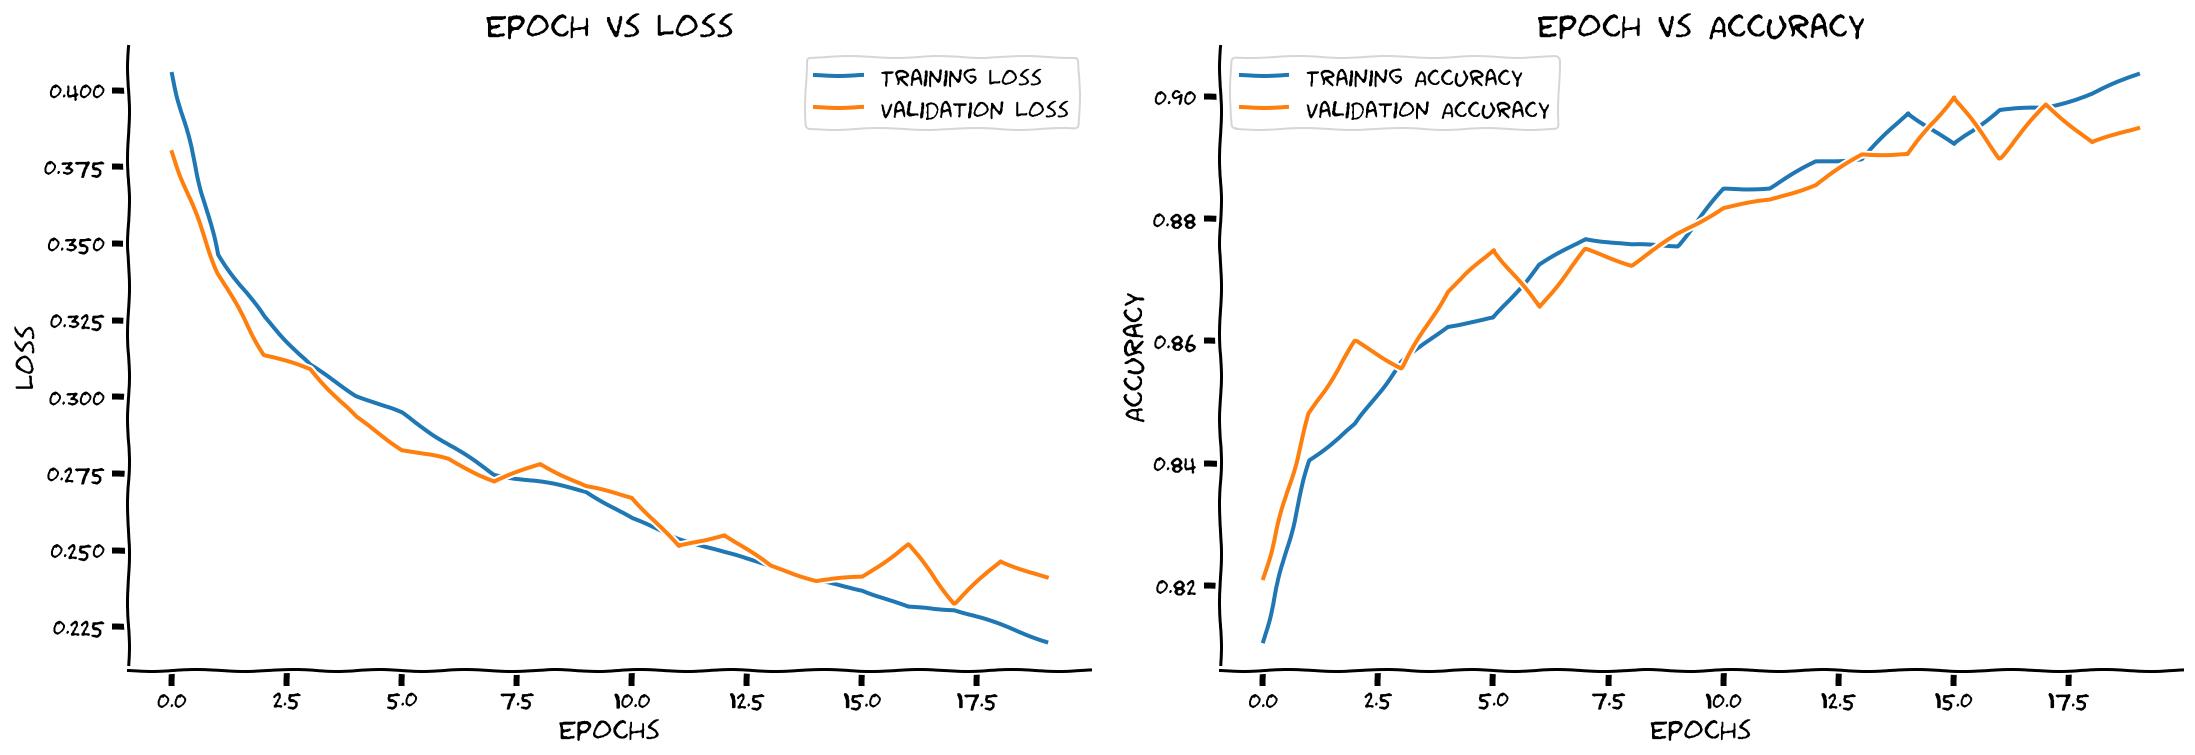

In [88]:
# to_remove solution
def get_augmentation_transforms():
  augmentation_transforms = [transforms.RandomRotation(10), transforms.RandomHorizontalFlip()]

  return augmentation_transforms


set_seed(SEED)
net3 = FMNIST_Net2(num_classes=2).to(DEVICE)  # get the network

## Uncomment below to test your function
train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)
train_loss, train_acc, validation_loss, validation_acc = train(net3, DEVICE, train_loader, validation_loader, 20)
with plt.xkcd():
  plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
print(f'Test accuracy is: {test(net3, DEVICE, test_loader)}')

### Think! Bonus 2.2: Data Augmentation

Did the training accuracy reduce further compared to with dropout alone? Is the model still overfitting?

In [89]:
# to_remove explanation

"""
The model does not overfit anymore as both training and validation loss decrease
during training.
""";

Great! In this section you trained what may have been your very first CNN. You added regularization and data augmentation in order to get a model that generalizes well. All the pieces are beginning to fit together!